# LoanTap

LoanTap is an online platform committed to delivering customized loan products to millennials. They innovate in an otherwise dull loan segment, to deliver instant, flexible loans on consumer friendly terms to salaried professionals and businessmen.

The data science team at LoanTap is building an underwriting layer to determine the creditworthiness of MSMEs as well as individuals.

LoanTap deploys formal credit to salaried individuals and businesses 4 main financial instruments:

- Personal Loan
- EMI Free Loan
- Personal Overdraft
- Advance Salary Loan

[Dataset](https://drive.google.com/file/d/1ZPYj7CZCfxntE8p2Lze_4QO4MyEOy6_d/view)

Data dictionary:

- loan_amnt : The listed amount of the loan applied for by the borrower. If at some point in time, the credit department reduces the loan amount, then it will be reflected in this value.
- term : The number of payments on the loan. Values are in months and can be either 36 or 60.
- int_rate : Interest Rate on the loan
- installment : The monthly payment owed by the borrower if the loan originates.
- grade : LoanTap assigned loan grade
- sub_grade : LoanTap assigned loan subgrade
- emp_title :The job title supplied by the Borrower when applying for the loan.*
- emp_length : Employment length in years. Possible values are between 0 and 10 where 0 means less than one year and 10 means ten or more years.
- home_ownership : The home ownership status provided by the borrower during - registration or obtained from the credit report.
- annual_inc : The self-reported annual income provided by the borrower during registration.
- verification_status : Indicates if income was verified by LoanTap, not verified, or if the income source was verified
- issue_d : The month which the loan was funded
- loan_status : Current status of the loan - Target Variable
- purpose : A category provided by the borrower for the loan request.
- title : The loan title provided by the borrower
- dti : A ratio calculated using the borrower’s total monthly debt payments on the total debt obligations, excluding mortgage and the requested LoanTap loan, divided by the borrower’s self-reported monthly income.
- earliest_cr_line :The month the borrower's earliest reported credit line was opened
- open_acc : The number of open credit lines in the borrower's credit file.
- pub_rec : Number of derogatory public records
- revol_bal : Total credit revolving balance
- revol_util : Revolving line utilization rate, or the amount of credit the borrower is using relative to all available revolving credit.
- total_acc : The total number of credit lines currently in the borrower's credit file
- initial_list_status : The initial listing status of the loan. Possible values are W, F
- application_type : Indicates whether the loan is an individual application or a joint application with two co-borrowers
- mort_acc : Number of mortgage accounts.
- pub_rec_bankruptcies : Number of public record bankruptcies
- Address: Address of the individual

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('ggplot')
pd.set_option('display.max_columns', 100)
import warnings
warnings.filterwarnings("ignore")

import math

import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

from sklearn.preprocessing import LabelEncoder, StandardScaler, OneHotEncoder
from sklearn.cluster import KMeans
from sklearn.impute import SimpleImputer, KNNImputer

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier, VotingClassifier, StackingClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, accuracy_score, roc_curve, auc, make_scorer, f1_score

from scipy import stats
from tqdm.notebook import tqdm
import pickle

!pip install xgboost
import xgboost as xgb
from xgboost import XGBClassifier

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
data_folder = '/content/drive/MyDrive/Colab Notebooks/Scaler work/LoanTap'

In [ ]:
df = pd.read_csv(f"{data_folder}/LoanTapData.csv", parse_dates=['issue_d', 'earliest_cr_line'])
# df['issue_d'] = df['issue_d'].dt.date
# df['earliest_cr_line'] = df['earliest_cr_line'].dt.date
df.head()

loan_amnt        term  int_rate  installment grade sub_grade  \
0    10000.0   36 months     11.44       329.48     B        B4   
1     8000.0   36 months     11.99       265.68     B        B5   
2    15600.0   36 months     10.49       506.97     B        B3   
3     7200.0   36 months      6.49       220.65     A        A2   
4    24375.0   60 months     17.27       609.33     C        C5   

                 emp_title emp_length home_ownership  annual_inc  \
0                Marketing  10+ years           RENT    117000.0   
1          Credit analyst     4 years       MORTGAGE     65000.0   
2             Statistician   < 1 year           RENT     43057.0   
3          Client Advocate    6 years           RENT     54000.0   
4  Destiny Management Inc.    9 years       MORTGAGE     55000.0   

  verification_status    issue_d  loan_status             purpose  \
0        Not Verified 2015-01-01   Fully Paid            vacation   
1        Not Verified 2015-01-01   Fully Paid  debt_consolidation   
2     Source Verified 2015-01-01   Fully Paid         credit_card   
3        Not Verified 2014-11-01   Fully Paid         credit_card   
4            Verified 2013-04-01  Charged Off         credit_card   

                     title    dti earliest_cr_line  open_acc  pub_rec  \
0                 Vacation  26.24       1990-06-01      16.0      0.0   
1       Debt consolidation  22.05       2004-07-01      17.0      0.0   
2  Credit card refinancing  12.79       2007-08-01      13.0      0.0   
3  Credit card refinancing   2.60       2006-09-01       6.0      0.0   
4    Credit Card Refinance  33.95       1999-03-01      13.0      0.0   

   revol_bal  revol_util  total_acc initial_list_status application_type  \
0    36369.0        41.8       25.0                   w       INDIVIDUAL   
1    20131.0        53.3       27.0                   f       INDIVIDUAL   
2    11987.0        92.2       26.0                   f       INDIVIDUAL   
3     5472.0        21.5       13.0                   f       INDIVIDUAL   
4    24584.0        69.8       43.0                   f       INDIVIDUAL   

   mort_acc  pub_rec_bankruptcies  \
0       0.0                   0.0   
1       3.0                   0.0   
2       0.0                   0.0   
3       0.0                   0.0   
4       1.0                   0.0   

                                             address  
0     0174 Michelle Gateway\r\nMendozaberg, OK 22690  
1  1076 Carney Fort Apt. 347\r\nLoganmouth, SD 05113  
2  87025 Mark Dale Apt. 269\r\nNew Sabrina, WV 05113  
3            823 Reid Ford\r\nDelacruzside, MA 00813  
4             679 Luna Roads\r\nGreggshire, VA 11650

In [ ]:
df.shape

(396030, 27)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 396030 entries, 0 to 396029
Data columns (total 27 columns):
 #   Column                Non-Null Count   Dtype         
---  ------                --------------   -----         
 0   loan_amnt             396030 non-null  float64       
 1   term                  396030 non-null  object        
 2   int_rate              396030 non-null  float64       
 3   installment           396030 non-null  float64       
 4   grade                 396030 non-null  object        
 5   sub_grade             396030 non-null  object        
 6   emp_title             373103 non-null  object        
 7   emp_length            377729 non-null  object        
 8   home_ownership        396030 non-null  object        
 9   annual_inc            396030 non-null  float64       
 10  verification_status   396030 non-null  object        
 11  issue_d               396030 non-null  datetime64[ns]
 12  loan_status           396030 non-null  object        
 13 

# Missing Values Imputation

In [ ]:
missing_values = df.isna().sum()
missing_values = missing_values[missing_values > 0]
missing_values

emp_title               22927
emp_length              18301
title                    1756
revol_util                276
mort_acc                37795
pub_rec_bankruptcies      535
dtype: int64

In [ ]:
rect_df = df.copy()

**Imputing `revol_util`**

In [ ]:
# Fill NA for revol_util where revol_bal is 0
rect_df.loc[rect_df['revol_bal'] == 0, 'revol_util'] = rect_df['revol_util'].fillna(0)

In [ ]:
train_df = rect_df.select_dtypes(exclude=['object','datetime']).dropna()
X = train_df.drop(['revol_util'], axis=1)
y = train_df['revol_util']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X.columns

Index(['loan_amnt', 'int_rate', 'installment', 'annual_inc', 'dti', 'open_acc',
       'pub_rec', 'revol_bal', 'total_acc', 'mort_acc',
       'pub_rec_bankruptcies'],
      dtype='object')

In [ ]:
# Impute 'revol_util' using LinearRegression
model = LinearRegression()
model.fit(X_train, y_train)
r2_score(y_test, model.predict(X_test))

0.18252765852218944

In [ ]:
# Impute 'revol_util' using Random Forest
model_rf = RandomForestRegressor(n_estimators=100, random_state=42)
model_rf.fit(X, y)
r2_score(y_train, model_rf.predict(X_train)), r2_score(y_test, model_rf.predict(X_test))

(0.9273116293028068, 0.9276363031337239)

R2 92% with no overfitting using Random Forest for revol_utils

In [ ]:
# Imputing revol_util missing values
missing_df = rect_df[rect_df['revol_util'].isna()]
X_missing = missing_df.select_dtypes(exclude=['object','datetime']).drop('revol_util', axis=1)
rect_df.loc[rect_df['revol_util'].isna(), 'revol_util'] = model_rf.predict(X_missing)
print('Missing values imputed for `revol_util`')

Missing values imputed for `revol_util`


In [ ]:
del model_rf, model

**Imputing `emp_length`**

In [ ]:
rect_df['pincode'] = rect_df['address'].str.extract(r'(\d+)(?=\D*$)').astype('int')

In [ ]:
# Imputing emp_length based on locality and Annual Income
def impute_emp_length(row, map):
    if pd.isna(row['emp_length']):
        # Look for rows with the same pincode in the map
        matching_rows = map[map['pincode'] == row['pincode']]
        if matching_rows.empty:
            return None

        # Calculate a score based on the loan amount proximity and cnt priority
        matching_rows['annual_inc_diff'] = (matching_rows['avg_annual_inc'] - row['annual_inc']).abs()
        matching_rows['score'] = matching_rows['annual_inc_diff'] / matching_rows['cnt']

        # Find the row with the lowest score (since lower score means better match)
        best_match_idx = matching_rows['score'].idxmin()
        best_match = matching_rows.loc[best_match_idx]

        return best_match['emp_length']

    return row['emp_length']

map = (rect_df[~rect_df['emp_length'].isna()].groupby(['pincode', 'emp_length']).agg(cnt= ('address', 'count'), avg_annual_inc = ('annual_inc', 'mean'))
        .reset_index().sort_values(by=['pincode', 'cnt', 'avg_annual_inc'], ascending=[True, False, False]))
emp_length_imp = rect_df.apply(impute_emp_length, axis=1, map=map)
# print("Accuracy:", (rect_df['emp_length'] == emp_length_imp).sum()/len(rect_df))
rect_df['emp_length'] = emp_length_imp

In [ ]:
# Store Employee Length Imputation Map
map.to_pickle(f"{data_folder}/utils/emp_length_imputation_map.pkl")

In [ ]:
loaded_map = pd.read_pickle(f"{data_folder}/utils/emp_length_imputation_map.pkl")

**Imputing `mort_acc`**

In [ ]:
# Using Business Intitution to impute
len(rect_df[((rect_df['mort_acc']==0) & (rect_df['home_ownership']=='MORTGAGE'))])/len(rect_df[((~rect_df['mort_acc'].isnull()) & (rect_df['home_ownership']=='MORTGAGE'))])

0.08016246023796683

There seem to be cases where `home_ownership = 'MORTGAGE'` but `mort_acc=0`, hence we can't really apply this business logic to impute missing values in `mort_acc`

In [ ]:
# Impute 'mort_acc' using Random Forest
train_df = rect_df[['total_acc', 'annual_inc', 'loan_amnt', 'mort_acc']].dropna()
X = train_df.drop('mort_acc', axis=1)
y = train_df['mort_acc']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
model_rf = RandomForestRegressor(random_state=42)
model_rf.fit(X_train, y_train)
print(r2_score(y_train, model_rf.predict(X_train)), r2_score(y_test, model_rf.predict(X_test)))

0.9272645144705931 0.47272368060288805


High Overfitting

In [ ]:
# Label Encoding
label_encoder = LabelEncoder()
encoded_df = rect_df.copy()
object_columns = encoded_df.select_dtypes(include='object').columns
for col in object_columns:
    encoded_df[col] = label_encoder.fit_transform(encoded_df[col])

In [ ]:
# Compute correlation matrix
correlation_matrix = encoded_df.corr()

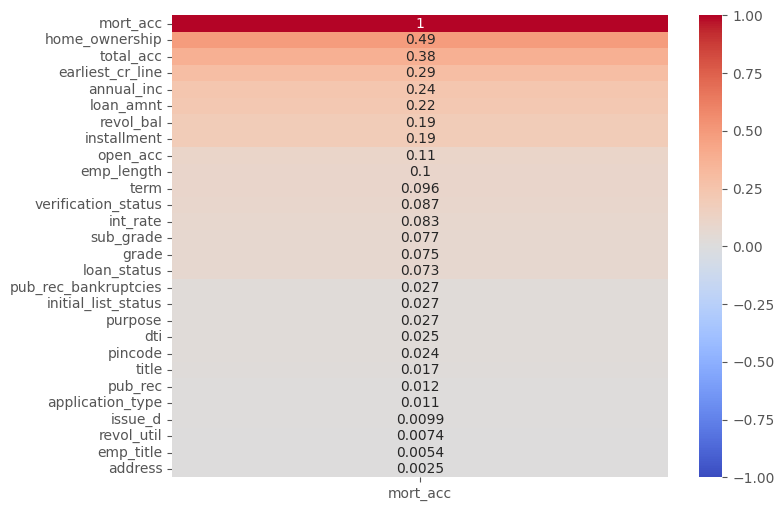

In [ ]:
# Get the correlation of specific column with other columns
fet_corr = correlation_matrix[['mort_acc']].apply(abs).sort_values(by='mort_acc', ascending=False) # High Value not focusing on +ve/-ve correlation
plt.figure(figsize=(8, 6))
sns.heatmap(fet_corr, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.show()

In [ ]:
# Impute 'mort_acc' using Random Forest on High correlated features
imp_fets = fet_corr[fet_corr['mort_acc']>0.2].index.to_list()
imp_fets.remove('earliest_cr_line')
train_df = encoded_df[imp_fets].dropna()
X = train_df.drop('mort_acc', axis=1)
y = train_df['mort_acc']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
model_rf = RandomForestRegressor(random_state=42)
model_rf.fit(X_train, y_train)
print(r2_score(y_train, model_rf.predict(X_train)), r2_score(y_test, model_rf.predict(X_test)))

0.7889194463196255 0.21236034667861814


In [ ]:
# Impute 'mort_acc' using Clustering
temp = encoded_df.drop(['issue_d', 'earliest_cr_line', 'emp_title', 'title', 'pub_rec_bankruptcies'], axis=1).copy()
# Scale the numerical columns for clustering
scaler = StandardScaler()
scaled_features = scaler.fit_transform(temp.drop(columns="mort_acc"))

X_train, X_test, y_train, y_test = train_test_split(scaled_features, temp["mort_acc"], test_size=0.2, random_state=42)

# Apply KMeans clustering to group the data
kmeans = KMeans(n_clusters=3, random_state=42)
temp["cluster"] = kmeans.fit_predict(scaled_features)

# Calculate the median 'mort_acc' for each cluster
cluster_medians = temp.groupby("cluster")["mort_acc"].median()

# Impute missing values in 'mort_acc' based on the median of the respective cluster
temp["mort_acc_impute"] = temp.apply(lambda row: cluster_medians[row["cluster"]], axis=1)
r2_score(temp['mort_acc'].dropna(), temp[~temp['mort_acc'].isna()]['mort_acc_impute'])

0.0014898064532292699

In [ ]:
# Impute 'mort_acc' using Clustering on Customer Persona
temp = encoded_df[['home_ownership', 'emp_length', 'pincode', 'mort_acc']].copy()
# Scale the numerical columns for clustering
scaler = StandardScaler()
scaled_features = scaler.fit_transform(temp.drop(columns="mort_acc"))

X_train, X_test, y_train, y_test = train_test_split(scaled_features, temp["mort_acc"], test_size=0.2, random_state=42)

# Apply KMeans clustering to group the data
kmeans = KMeans(n_clusters=3, random_state=42)
temp["cluster"] = kmeans.fit_predict(scaled_features)

# Calculate the median 'mort_acc' for each cluster
cluster_medians = temp.groupby("cluster")["mort_acc"].median()

# Impute missing values in 'mort_acc' based on the median of the respective cluster
temp["mort_acc_impute"] = temp.apply(lambda row: cluster_medians[row["cluster"]], axis=1)
r2_score(temp['mort_acc'].dropna(), temp[~temp['mort_acc'].isna()]['mort_acc_impute'])

0.035762981749575595

Not working here

In [ ]:
# Using Business Intitution (as only 8% of our data didn't supported the intitution but rest did)
def impute_mort_acc_from_map(row, map):
    if pd.isna(row['mort_acc']):
        # Find the corresponding row in the map
        matching_row = map[
            (map['home_ownership'] == row['home_ownership']) &
            (map['emp_length'] == row['emp_length']) &
            (map['pincode'] == row['pincode'])
        ]
        if not matching_row.empty:
            return round(matching_row['mort_acc'].iloc[0])
        else:
            return round(map['mort_acc'].mean())
    return row['mort_acc']

map = rect_df[((~rect_df['mort_acc'].isna()))].groupby(['home_ownership', 'emp_length', 'pincode'])['mort_acc'].mean().reset_index()
rect_df['mort_acc'] = rect_df.apply(impute_mort_acc_from_map, axis=1, map=map)

In [ ]:
# Store Employee Length Imputation Map
map.to_pickle(f"{data_folder}/utils/mort_acc_imputation_map.pkl")

In [ ]:
loaded_map = pd.read_pickle(f"{data_folder}/utils/mort_acc_imputation_map.pkl")

**Imputing `pub_rec_bankruptcies`**

In [ ]:
# Impute 'pub_rec_bankruptcies' using Random Forest
# train_df = encoded_df.drop(['issue_d', 'earliest_cr_line', 'emp_title', 'title'], axis=1).copy().dropna()
train_df = encoded_df[['pub_rec', 'revol_bal', 'pub_rec_bankruptcies']].dropna()
X = train_df.drop('pub_rec_bankruptcies', axis=1)
y = rect_df[rect_df.index.isin(X.index)]['pub_rec_bankruptcies']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
model_rf = RandomForestClassifier(
    max_depth=8,
    min_samples_split=20,
    min_samples_leaf=10,
    max_features=0.5,
    n_estimators=50,
    random_state=42
)
model_rf.fit(X_train, y_train)
print(f"Train Accuracy: {model_rf.score(X_train, y_train):.4f}")
print(f"Test Accuracy: {model_rf.score(X_test, y_test):.4f}")

Train Accuracy: 0.9657
Test Accuracy: 0.9652


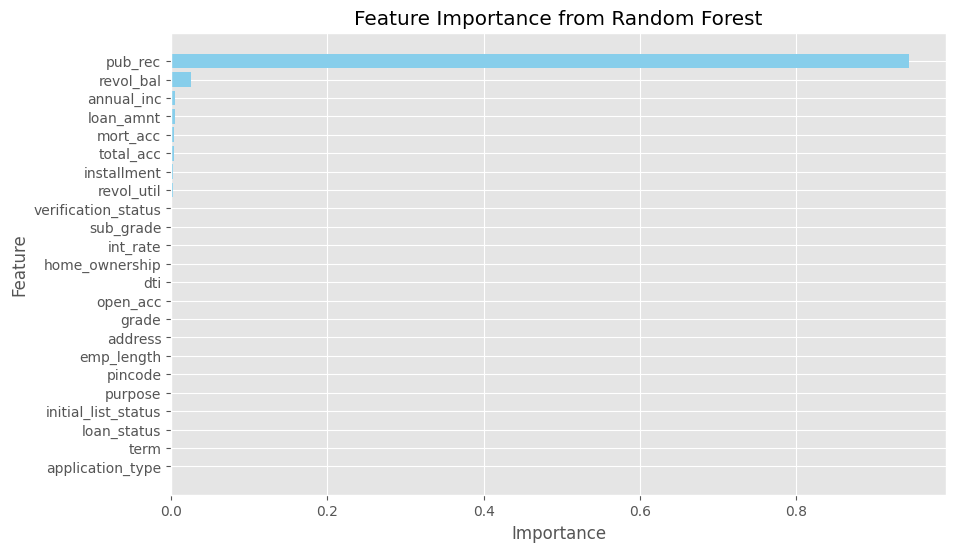

In [ ]:
# Get Feature Importance
feature_importance = model_rf.feature_importances_
importance_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': feature_importance
}).sort_values(by='Importance', ascending=False)
plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'], importance_df['Importance'], color='skyblue')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance from Random Forest')
plt.gca().invert_yaxis()  # To display the most important feature at the top
plt.show()

The Importance Features to predict `pub_rec_bankruptcies` are very intuitive. Tho the variance explained by 1 variable is huge, they might be high correlation hence will have to drop one while modelling later.

In [ ]:
missing_indices = encoded_df[encoded_df['pub_rec_bankruptcies'].isna()].index
missing_features = encoded_df.loc[missing_indices, X.columns]
predicted_values = model_rf.predict(missing_features)
rect_df.loc[missing_indices, 'pub_rec_bankruptcies'] = predicted_values

**Imputing `emp_title` and `title`**

In [ ]:
rect_df['emp_title'] = rect_df['emp_title'].fillna('Unknown')
rect_df['title'] = rect_df['title'].fillna('Unknown')

In [ ]:
# Check missing values
missing_values = rect_df.isna().sum()
missing_values = missing_values[missing_values > 0]
missing_values

Series([], dtype: int64)

In [ ]:
# Saving Imputed DF
rect_df.to_csv(f"{data_folder}/LoanTapData_Imputed.csv", index=False)

In [ ]:
# Load Imputed DF
rect_df = pd.read_csv(f"{data_folder}/LoanTapData_Imputed.csv", parse_dates=['issue_d', 'earliest_cr_line'])
rect_df.head()

loan_amnt        term  int_rate  installment grade sub_grade  \
0    10000.0   36 months     11.44       329.48     B        B4   
1     8000.0   36 months     11.99       265.68     B        B5   
2    15600.0   36 months     10.49       506.97     B        B3   
3     7200.0   36 months      6.49       220.65     A        A2   
4    24375.0   60 months     17.27       609.33     C        C5   

                 emp_title emp_length home_ownership  annual_inc  \
0                Marketing  10+ years           RENT    117000.0   
1          Credit analyst     4 years       MORTGAGE     65000.0   
2             Statistician   < 1 year           RENT     43057.0   
3          Client Advocate    6 years           RENT     54000.0   
4  Destiny Management Inc.    9 years       MORTGAGE     55000.0   

  verification_status    issue_d  loan_status             purpose  \
0        Not Verified 2015-01-01   Fully Paid            vacation   
1        Not Verified 2015-01-01   Fully Paid  debt_consolidation   
2     Source Verified 2015-01-01   Fully Paid         credit_card   
3        Not Verified 2014-11-01   Fully Paid         credit_card   
4            Verified 2013-04-01  Charged Off         credit_card   

                     title    dti earliest_cr_line  open_acc  pub_rec  \
0                 Vacation  26.24       1990-06-01      16.0      0.0   
1       Debt consolidation  22.05       2004-07-01      17.0      0.0   
2  Credit card refinancing  12.79       2007-08-01      13.0      0.0   
3  Credit card refinancing   2.60       2006-09-01       6.0      0.0   
4    Credit Card Refinance  33.95       1999-03-01      13.0      0.0   

   revol_bal  revol_util  total_acc initial_list_status application_type  \
0    36369.0        41.8       25.0                   w       INDIVIDUAL   
1    20131.0        53.3       27.0                   f       INDIVIDUAL   
2    11987.0        92.2       26.0                   f       INDIVIDUAL   
3     5472.0        21.5       13.0                   f       INDIVIDUAL   
4    24584.0        69.8       43.0                   f       INDIVIDUAL   

   mort_acc  pub_rec_bankruptcies  \
0       0.0                   0.0   
1       3.0                   0.0   
2       0.0                   0.0   
3       0.0                   0.0   
4       1.0                   0.0   

                                             address  pincode  
0     0174 Michelle Gateway\r\nMendozaberg, OK 22690    22690  
1  1076 Carney Fort Apt. 347\r\nLoganmouth, SD 05113     5113  
2  87025 Mark Dale Apt. 269\r\nNew Sabrina, WV 05113     5113  
3            823 Reid Ford\r\nDelacruzside, MA 00813      813  
4             679 Luna Roads\r\nGreggshire, VA 11650    11650

In [ ]:
# Check missing values
missing_values = rect_df.isna().sum()
missing_values = missing_values[missing_values > 0]
missing_values

Series([], dtype: int64)

# Business Analysis

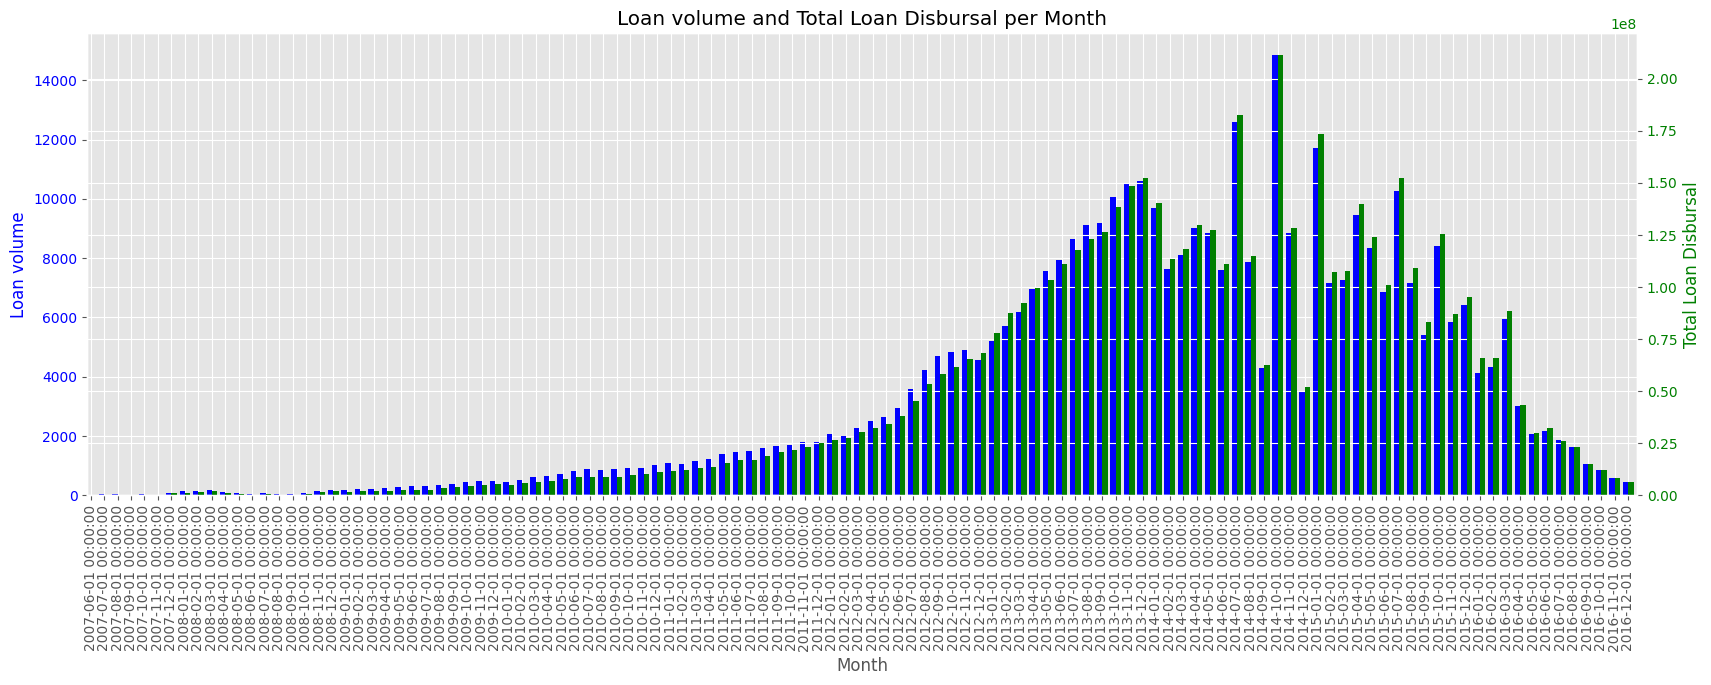

In [ ]:
# Plot Loan volume
fig, ax1 = plt.subplots(figsize=(20, 6))

count_of_loans = rect_df.groupby('issue_d')['issue_d'].count()
total_loan_disbursal = rect_df.groupby('issue_d')['loan_amnt'].sum()

count_of_loans.plot(kind='bar', ax=ax1, color='blue', position=1, width=0.4)
ax1.set_xlabel('Month')
ax1.set_ylabel('Loan volume', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')

# Create a second y-axis for total loan disbursal
ax2 = ax1.twinx()
total_loan_disbursal.plot(kind='bar', ax=ax2, color='green', position=0, width=0.4)
ax2.set_ylabel('Total Loan Disbursal', color='green')
ax2.tick_params(axis='y', labelcolor='green')

# Set title
plt.title('Loan volume and Total Loan Disbursal per Month')

plt.show()

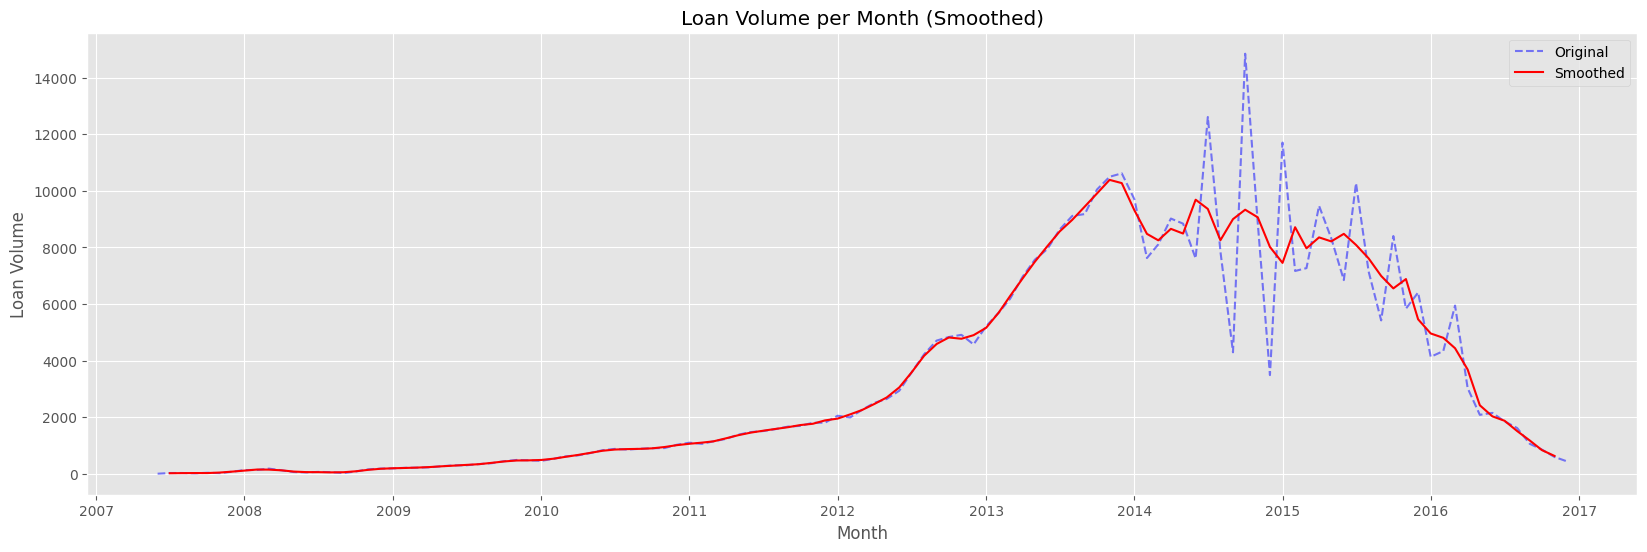

In [ ]:
# Apply a rolling mean to smoothen the line plot
smoothed_loans = count_of_loans.rolling(window=3, center=True).mean()

# Plot the original and smoothed data
plt.figure(figsize=(20, 6))
plt.plot(count_of_loans, label='Original', alpha=0.5, color='blue', linestyle='--')
plt.plot(smoothed_loans, label='Smoothed', color='red')
plt.xlabel('Month')
plt.ylabel('Loan Volume')
plt.title('Loan Volume per Month (Smoothed)')
plt.legend()
plt.show()

- Our loan volume has been on a declining trend since 2014, presenting a critical area of concern for future growth strategies.
- Interestingly, both total loan disbursal and loan volume follow a similar trajectory, highlighting that the Average Loan Value (ALV) has remained consistent over the observed period.

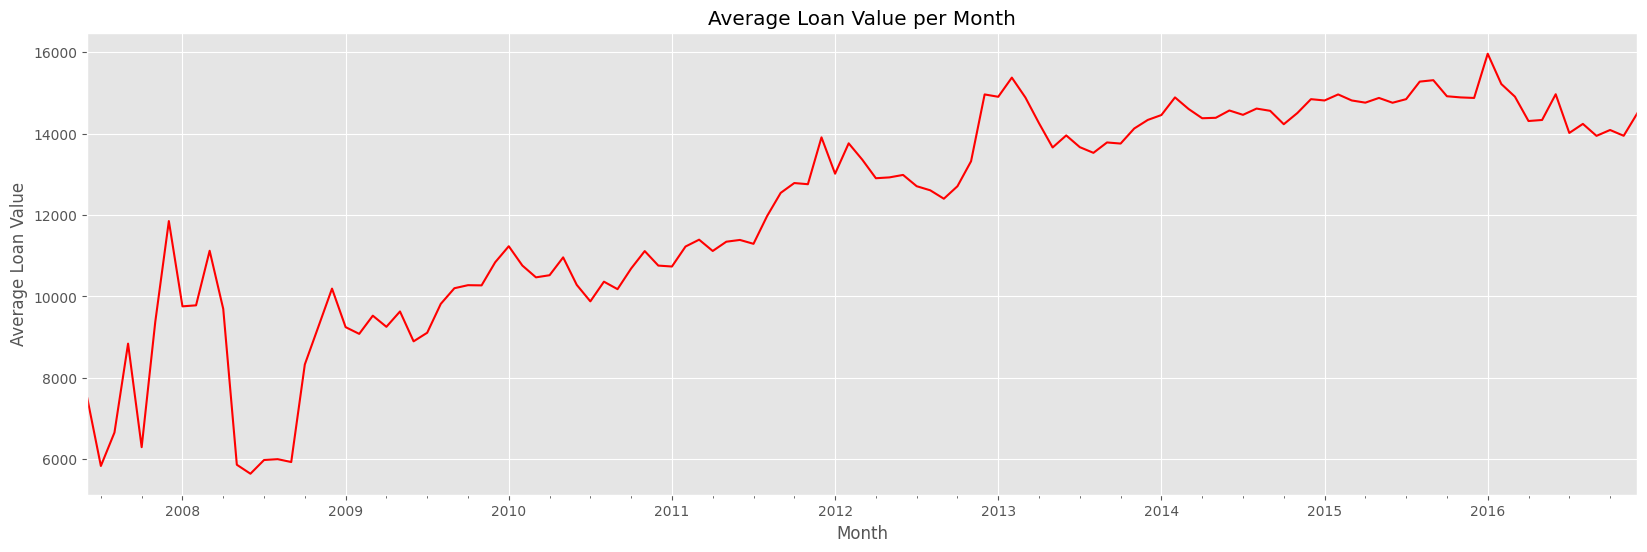

In [ ]:
# Calculate Average Loan Value (ALV)
aov = total_loan_disbursal / count_of_loans

aov.plot(figsize=(20, 6), color='red')
plt.xlabel('Month')
plt.ylabel('Average Loan Value')
plt.title('Average Loan Value per Month')
plt.show()

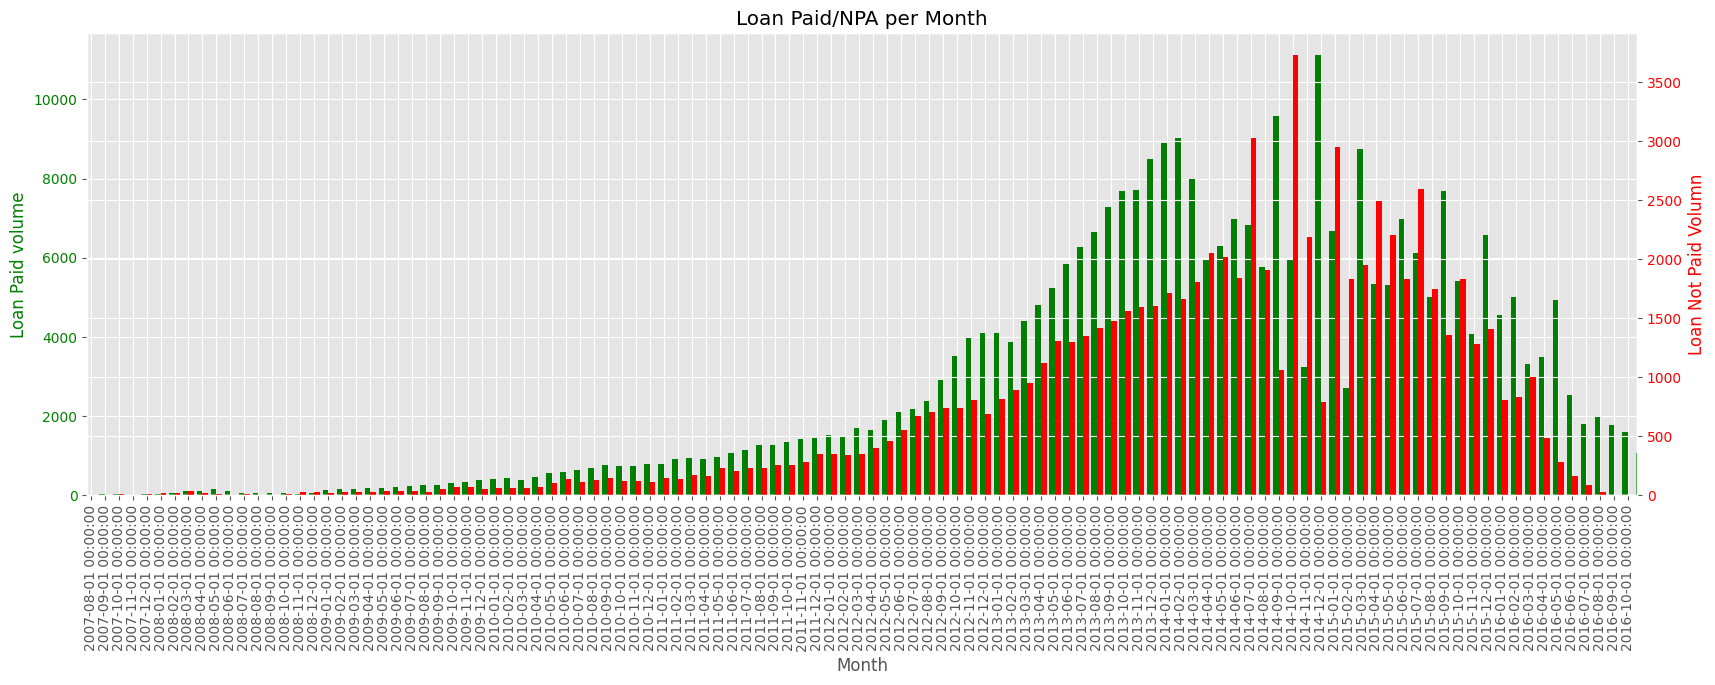

In [ ]:
# Paid/NPA
fig, ax1 = plt.subplots(figsize=(20, 6))

count_of_loans_paid = rect_df[rect_df['loan_status'] == 'Fully Paid'].groupby('issue_d')['issue_d'].count()
count_of_loans_NPA = rect_df[rect_df['loan_status'] != 'Fully Paid'].groupby('issue_d')['loan_amnt'].count()

count_of_loans_paid.plot(kind='bar', ax=ax1, color='green', position=1, width=0.4)
ax1.set_xlabel('Month')
ax1.set_ylabel('Loan Paid volume', color='green')
ax1.tick_params(axis='y', labelcolor='green')

ax2 = ax1.twinx()
count_of_loans_NPA.plot(kind='bar', ax=ax2, color='red', position=0, width=0.4)
ax2.set_ylabel('Loan Not Paid Volumn', color='red')
ax2.tick_params(axis='y', labelcolor='red')

# Set title
plt.title('Loan Paid/NPA per Month')

plt.show()

Since this graph is based on cohorts rather than a rolling basis—due to the unavailability of actual payment transaction data—I have to perform analysis only on cohort basis.

# Loan Category Overview

In [ ]:
rect_df['pincode'] = rect_df['pincode'].astype('object') # Change from int

  0%|          | 0/10 [00:00<?, ?it/s]

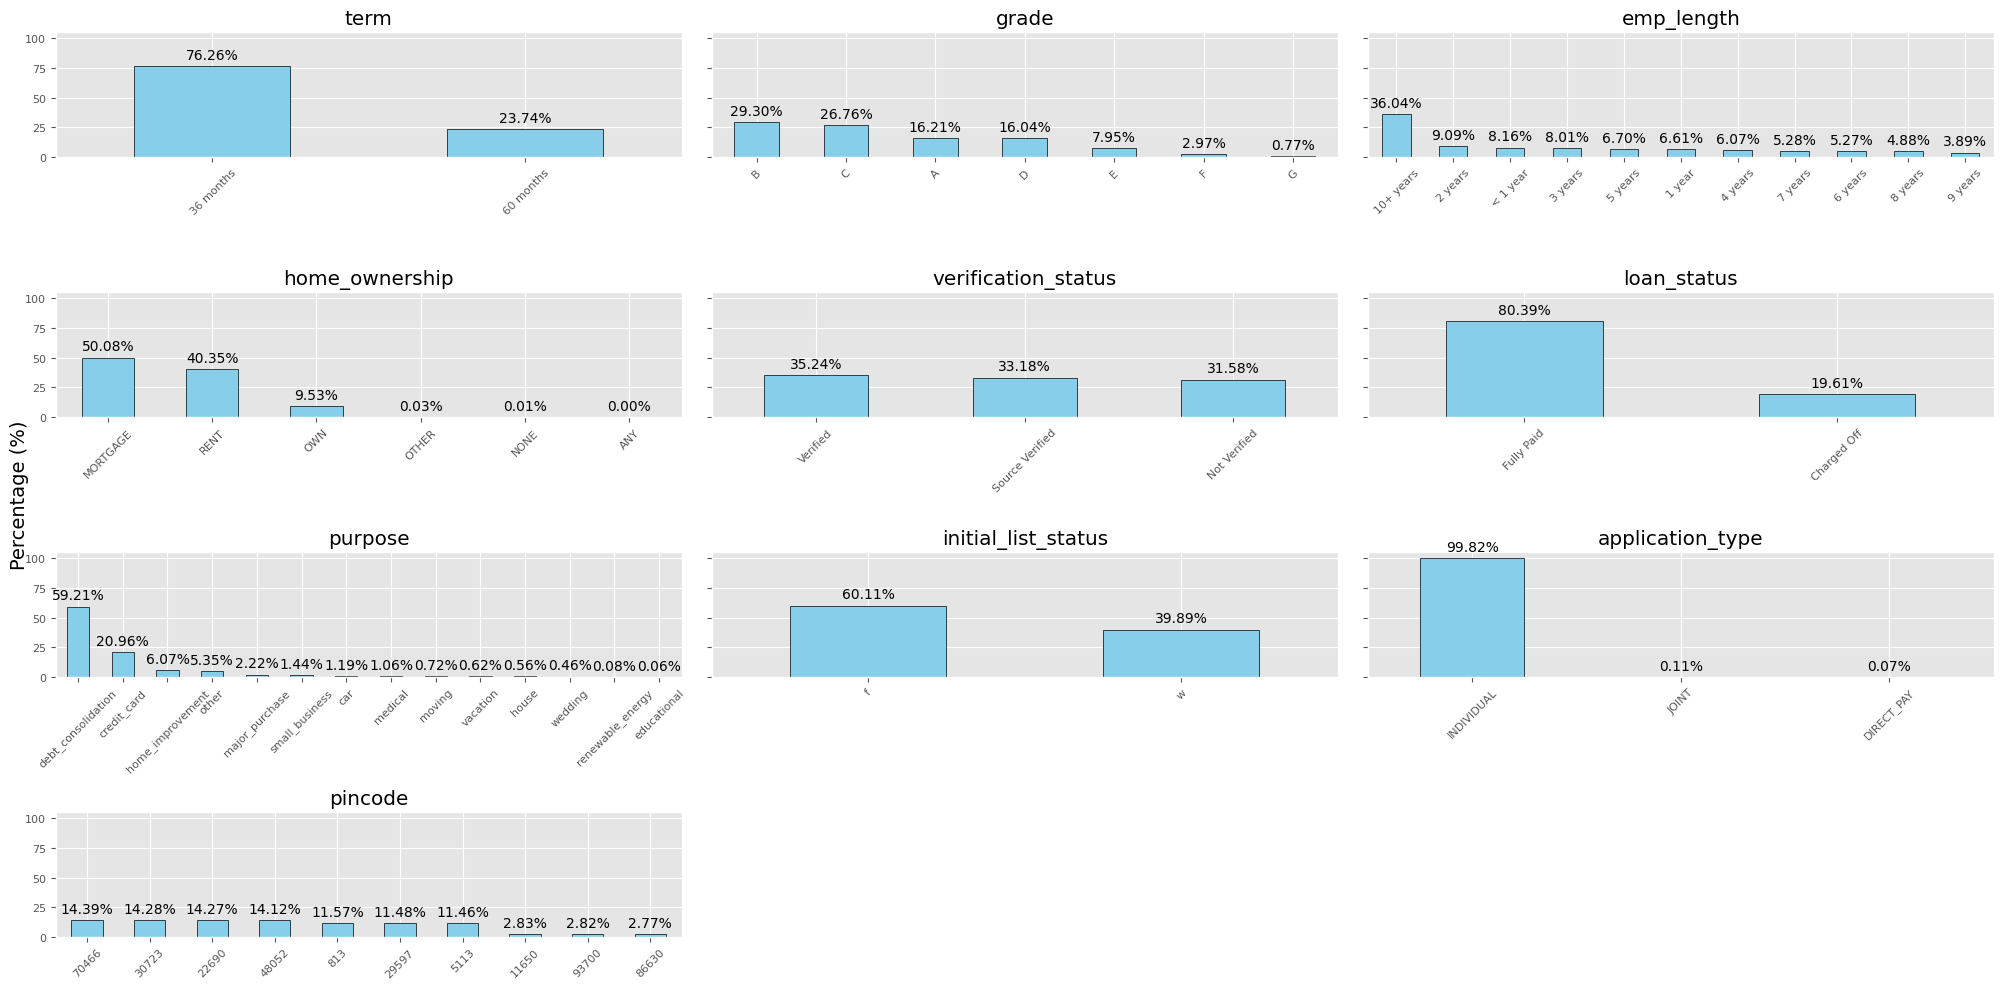

In [ ]:
object_features = rect_df.select_dtypes(include='object').drop(['address', 'emp_title', 'title', 'sub_grade'], axis=1).columns
fig, ax = plt.subplots(math.ceil(len(object_features) / 3), 3, figsize=(20, 10), sharey=True, constrained_layout=True)
ax = ax.flatten()
# Plot Count bars
for i, col in tqdm(enumerate(object_features), total=len(object_features)):
    percentages = (rect_df[col].value_counts(normalize=True) * 100).sort_values(ascending=False)
    bars = percentages.plot(kind='bar', ax=ax[i], color='skyblue', edgecolor='black')
    ax[i].set_title(col)
    ax[i].tick_params(axis='x', rotation=45, labelsize=8)
    ax[i].tick_params(axis='y', labelsize=8)
    ax[i].set_xlabel('')

    # Add percentage labels on each bar
    for bar in bars.patches:
        height = bar.get_height()
        ax[i].annotate(f'{height:.2f}%',  # Format the percentage with 2 decimal places
                       xy=(bar.get_x() + bar.get_width() / 2, height),  # Position the label
                       xytext=(0, 3),  # Offset the label slightly above the bar
                       textcoords='offset points',
                       ha='center', va='bottom', fontsize=10)

# Show
# fig.text(0.5, 0.0, 'Categories', ha='center', fontsize=14)  # x-axis label
fig.text(0.0, 0.5, 'Percentage (%)', va='center', rotation='vertical', fontsize=14)  # y-axis label
for i in range(len(object_features), len(ax)):
    ax[i].axis('off')
plt.tight_layout()
plt.show()

**Feature Engineering - Removing Unnecessary rows (Focusing on certain data)**
- 'MORTGAGE' and 'RENT' contributes ~90% of the data
- 'debt_consolidation', 'credit_card' contributes ~80% of the data
- similarly 'INDIVIDUAL' application_type contributes ~99% of the data
- 'application_type' and 'address' not important columns for analysis

In [ ]:
# Remove Unnecessary data
new_df = rect_df[rect_df['home_ownership'].isin(['MORTGAGE', 'RENT'])]
new_df = new_df[new_df['purpose'].isin(['debt_consolidation', 'credit_card'])]
new_df = new_df[new_df['application_type']=='INDIVIDUAL']

# Remove Unnecessary columns
new_df.drop(['application_type', 'address'], axis=1, inplace=True)

# Adjustments
new_df['loan_status'] = new_df['loan_status'].replace({'Fully Paid': 1, 'Charged Off': 0})

new_df.head()

loan_amnt        term  int_rate  installment grade sub_grade  \
1     8000.0   36 months     11.99       265.68     B        B5   
2    15600.0   36 months     10.49       506.97     B        B3   
3     7200.0   36 months      6.49       220.65     A        A2   
4    24375.0   60 months     17.27       609.33     C        C5   
5    20000.0   36 months     13.33       677.07     C        C3   

                 emp_title emp_length home_ownership  annual_inc  \
1          Credit analyst     4 years       MORTGAGE     65000.0   
2             Statistician   < 1 year           RENT     43057.0   
3          Client Advocate    6 years           RENT     54000.0   
4  Destiny Management Inc.    9 years       MORTGAGE     55000.0   
5            HR Specialist  10+ years       MORTGAGE     86788.0   

  verification_status    issue_d  loan_status             purpose  \
1        Not Verified 2015-01-01            1  debt_consolidation   
2     Source Verified 2015-01-01            1         credit_card   
3        Not Verified 2014-11-01            1         credit_card   
4            Verified 2013-04-01            0         credit_card   
5            Verified 2015-09-01            1  debt_consolidation   

                     title    dti earliest_cr_line  open_acc  pub_rec  \
1       Debt consolidation  22.05       2004-07-01      17.0      0.0   
2  Credit card refinancing  12.79       2007-08-01      13.0      0.0   
3  Credit card refinancing   2.60       2006-09-01       6.0      0.0   
4    Credit Card Refinance  33.95       1999-03-01      13.0      0.0   
5       Debt consolidation  16.31       2005-01-01       8.0      0.0   

   revol_bal  revol_util  total_acc initial_list_status  mort_acc  \
1    20131.0        53.3       27.0                   f       3.0   
2    11987.0        92.2       26.0                   f       0.0   
3     5472.0        21.5       13.0                   f       0.0   
4    24584.0        69.8       43.0                   f       1.0   
5    25757.0       100.6       23.0                   f       4.0   

   pub_rec_bankruptcies pincode  
1                   0.0    5113  
2                   0.0    5113  
3                   0.0     813  
4                   0.0   11650  
5                   0.0   30723

In [ ]:
new_df['loan_status'].value_counts(normalize=True)*100

loan_status
1    80.407282
0    19.592718
Name: proportion, dtype: float64

In [ ]:
new_df.shape

(288449, 26)

# Outlier Analysis

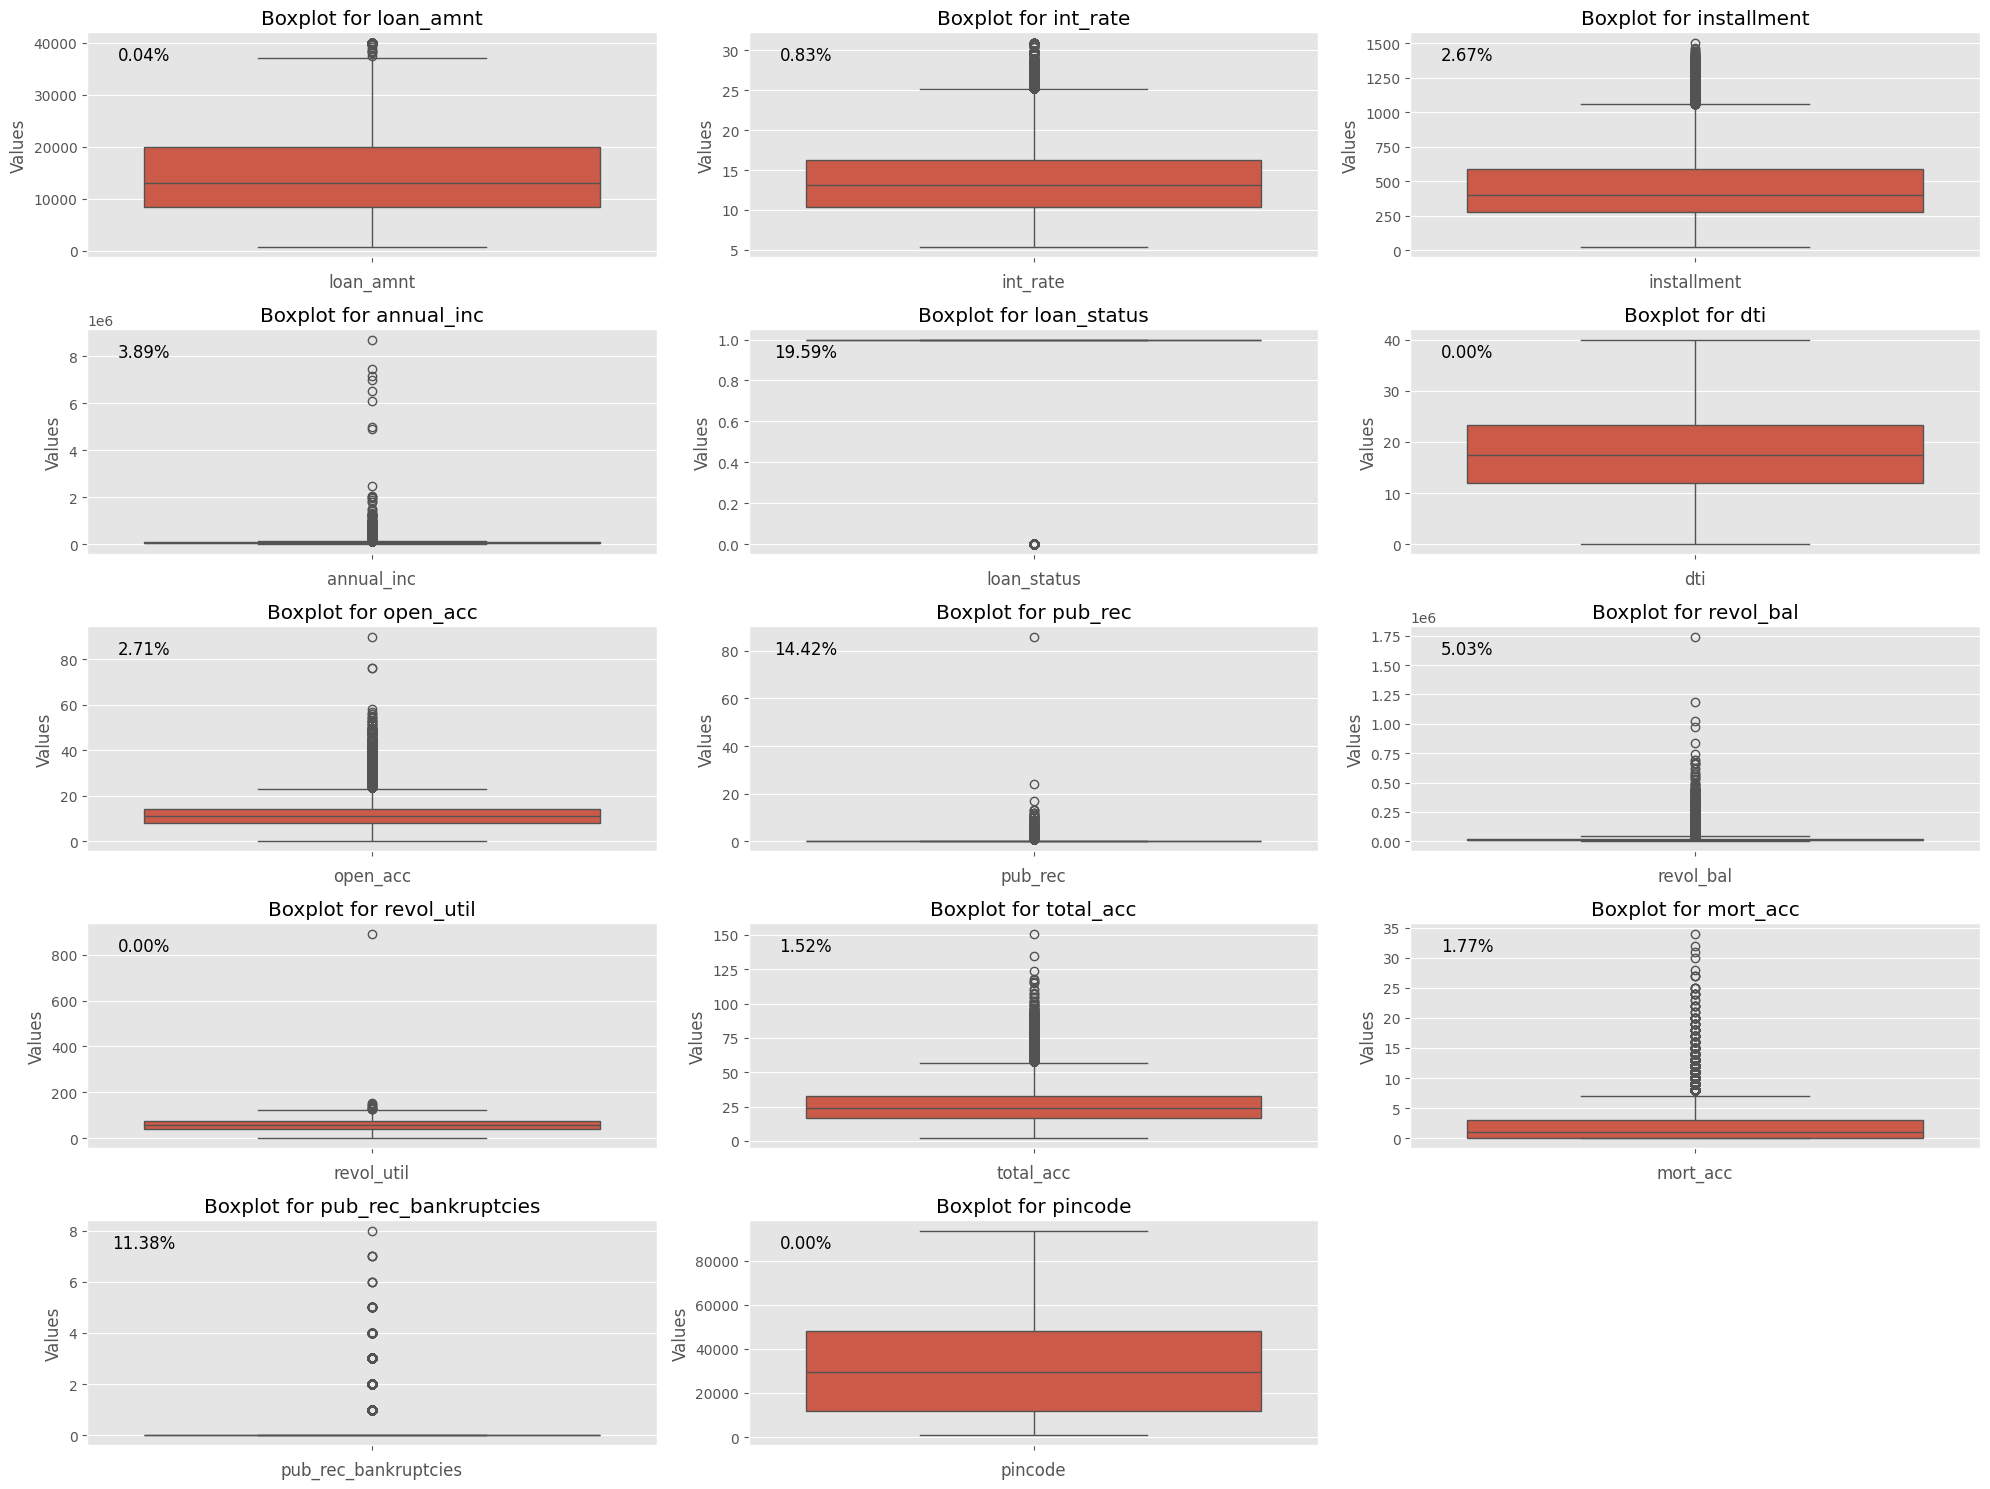

In [ ]:
numeric_fets = new_df.select_dtypes(exclude=['object', 'datetime'])
num_columns = len(numeric_fets.columns)
fig, axes = plt.subplots(math.ceil(num_columns / 3), 3, figsize=(20, 15))
axes = axes.flatten()

# Function to calculate the percentage of outliers based on IQR
def calculate_outliers_percentage(column):
    Q1 = column.quantile(0.25)
    Q3 = column.quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = column[(column < lower_bound) | (column > upper_bound)]
    outlier_percentage = (len(outliers) / len(column)) * 100
    return outlier_percentage

for i, column in enumerate(numeric_fets.columns):
    # Outlier percentage
    outlier_percentage = calculate_outliers_percentage(numeric_fets[column])
    # Box Plot
    sns.boxplot(data=numeric_fets[column], ax=axes[i])
    axes[i].set_title(f'Boxplot for {column}')
    axes[i].set_xlabel(column)
    axes[i].set_ylabel('Values')

    # Outlier percentage annotation
    axes[i].annotate(f'{outlier_percentage:.2f}%',
                     xy=(0.1, 0.9),
                     xycoords='axes fraction',
                     ha='center',
                     va='center',
                     fontsize=12,
                     color='black')

# Turn off any unused axes
for j in range(num_columns, len(axes)):
    axes[j].set_visible(False)

plt.tight_layout()
plt.show()

In [ ]:
def outlier_bounds(df, col):
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return lower_bound, upper_bound
lower_bound, upper_bound = outlier_bounds(new_df, 'loan_amnt')
loan_amnt_outliers = new_df[(new_df['loan_amnt'] < lower_bound) | (new_df['loan_amnt'] > upper_bound)].index
lower_bound, upper_bound = outlier_bounds(new_df, 'int_rate')
int_rate_outliers = new_df[(new_df['int_rate'] < lower_bound) | (new_df['int_rate'] > upper_bound)].index
lower_bound, upper_bound = outlier_bounds(new_df, 'installment')
installment_outliers = new_df[(new_df['installment'] < lower_bound) | (new_df['installment'] > upper_bound)].index

In [ ]:
print("%age of outliers in the int_rate column that correspond to outliers in the same rows of the loan_amnt column:", f"{(int_rate_outliers.isin(loan_amnt_outliers).sum()*100.0/len(int_rate_outliers)):.2f}%")
print("%age of outliers in the installment column that correspond to outliers in the same rows of the loan_amnt column:", f"{(installment_outliers.isin(loan_amnt_outliers).sum()*100.0/len(installment_outliers)):.2f}%")
print("%age of outliers in the int_rate column that correspond to outliers in the same rows of the installment column:", f"{(int_rate_outliers.isin(installment_outliers).sum()*100.0/len(int_rate_outliers)):.2f}%")

%age of outliers in the int_rate column that correspond to outliers in the same rows of the loan_amnt column: 0.04%
%age of outliers in the installment column that correspond to outliers in the same rows of the loan_amnt column: 0.97%
%age of outliers in the installment column that correspond to outliers in the same rows of the loan_amnt column: 5.03%


We can't perform outlier treament on `int_rate` and `installment` as they derives from `loan_amnt`, `term`, etc.

The dependency of these outliers on each other column is low, so we really can't perform outlier treatment on the `loan_amnt` column as the primary reference, and manually calculate the outliers for the other 2 columns.

Other simple option is to drop rows where there are outliers in `int_rate` or `installment` ~3.4% of the rows will be dropped

Skewness: 0.7382073227424355
Kurtosis: -0.12031888554177383


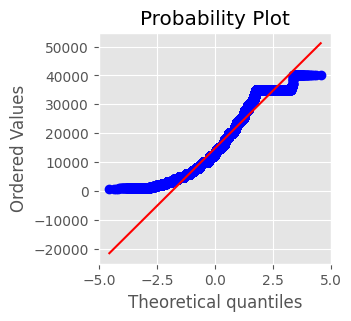

In [ ]:
from scipy.stats import skew, kurtosis
skewness = skew(new_df['loan_amnt'])
kurt = kurtosis(new_df['loan_amnt'])

print(f"Skewness: {skewness}")
print(f"Kurtosis: {kurt}")

plt.figure(figsize=(3, 3))
stats.probplot(new_df['loan_amnt'], dist="norm", plot=plt)
plt.show()

The column is not clearly normally distributed, but outlier are just 0.4% hence will go with simplest outlier treatment

In [ ]:
treated_df = new_df.copy()

In [ ]:
# Capping for loan_amnt
lower_bound, upper_bound = outlier_bounds(treated_df, 'loan_amnt')
treated_df['loan_amnt'] = treated_df['loan_amnt'].apply(lambda x: upper_bound if x > upper_bound else (lower_bound if x < lower_bound else x))

# Compute new installment (emi)
treated_df['loan_term'] = treated_df['term'].str.extract('(\d+)').astype('int')
P = treated_df['loan_amnt']
r = (treated_df['int_rate'] / 100) / 12
n = treated_df['loan_term']
treated_df['installment'] = (P * r * (1 + r)**n) / ((1 + r)**n - 1)

# Drop where outliers in int_rate and installment column
treated_df = treated_df.drop(index=int_rate_outliers)
treated_df = treated_df.drop(index=installment_outliers, errors='ignore')
treated_df = treated_df.reset_index(drop=True)

In [ ]:
# Variables to treat
continuous_columns = ['annual_inc', 'open_acc', 'revol_bal', 'total_acc', 'mort_acc']
categorical_columns = ['pub_rec', 'pub_rec_bankruptcies']

In [ ]:
from sklearn.ensemble import IsolationForest
features = new_df[continuous_columns+categorical_columns]
model = IsolationForest(contamination=0.05, random_state=42)
outliers = model.fit_predict(features)
np.unique(outliers, return_counts=True)

(array([-1,  1]), array([ 14423, 274026]))

Estimated 14k outlier when combined these many columns

In [ ]:
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# Preprocessor (scaling continuous features and one-hot encoding categorical features)
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), continuous_columns),
        ('cat', OneHotEncoder(), categorical_columns)
    ]
)

# Pipeline
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', IsolationForest(contamination=0.05, random_state=42))
])

# Fit the model
pipeline.fit(treated_df)

# Predict outliers
treated_df['outlier'] = pipeline.predict(treated_df)  # -1 indicates outliers

# Check outliers in the dataset
outliers = treated_df[treated_df['outlier'] == -1]

In [ ]:
temp = treated_df[continuous_columns+categorical_columns+['outlier']]
before_variance = temp.drop(columns=['outlier']).var()
after_variance = temp[temp['outlier'] == 1].drop(columns=['outlier']).var()
print("Variance reduction:\n", before_variance - after_variance)

Variance reduction:
 annual_inc              1.887466e+08
open_acc                1.256806e+00
revol_bal               9.079844e+07
total_acc               7.822891e+00
mort_acc                3.532794e-01
pub_rec                 1.013546e-01
pub_rec_bankruptcies    4.088088e-02
dtype: float64


The process was most impactful for annual_inc and revol_bal, likely because they contained the most extreme outliers.

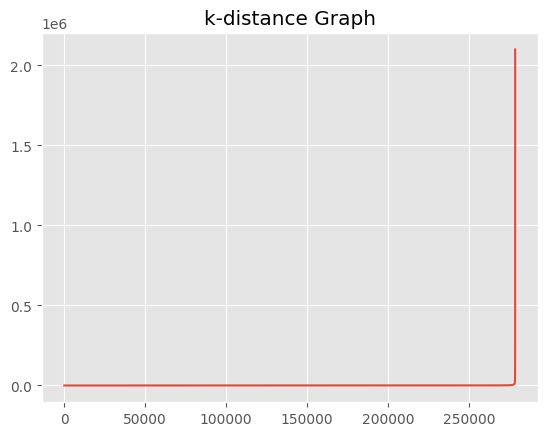

In [ ]:
from sklearn.neighbors import NearestNeighbors
import matplotlib.pyplot as plt

k = 4  # You can experiment with different k values
neighbors = NearestNeighbors(n_neighbors=k)
neighbors_fit = neighbors.fit(treated_df[continuous_columns+categorical_columns])
distances, indices = neighbors_fit.kneighbors(treated_df[continuous_columns+categorical_columns])
distances = np.sort(distances[:, k-1], axis=0)
plt.plot(distances)
plt.title('k-distance Graph')
plt.show()

No appropriate number of clusters present. Shows islands of clusters

In [ ]:
from sklearn.cluster import DBSCAN

# Apply DBSCAN to identify outliers
dbscan = DBSCAN(eps=0.7, min_samples=20)
dbscan.fit(treated_df[continuous_columns+categorical_columns])

# Mark outliers as -1 (points not belonging to any cluster)
dbscan.labels_

array([-1, -1, -1, ..., -1, -1, -1])

In [ ]:
np.unique(dbscan.labels_, return_counts=True)

(array([-1]), array([288449]))

Neither dense clusters nor spherical clusters were identified in the data.

In [ ]:
# Outlier Treatment - Winsorization
for column in continuous_columns+categorical_columns+['revol_util']:
    lower_bound = treated_df[column].quantile(0.05)
    upper_bound = treated_df[column].quantile(0.95)
    if column == 'pub_rec':
        treated_df[column] = treated_df[column].clip(lower=None, upper=upper_bound)
    treated_df[column] = treated_df[column].clip(lower_bound, upper_bound)

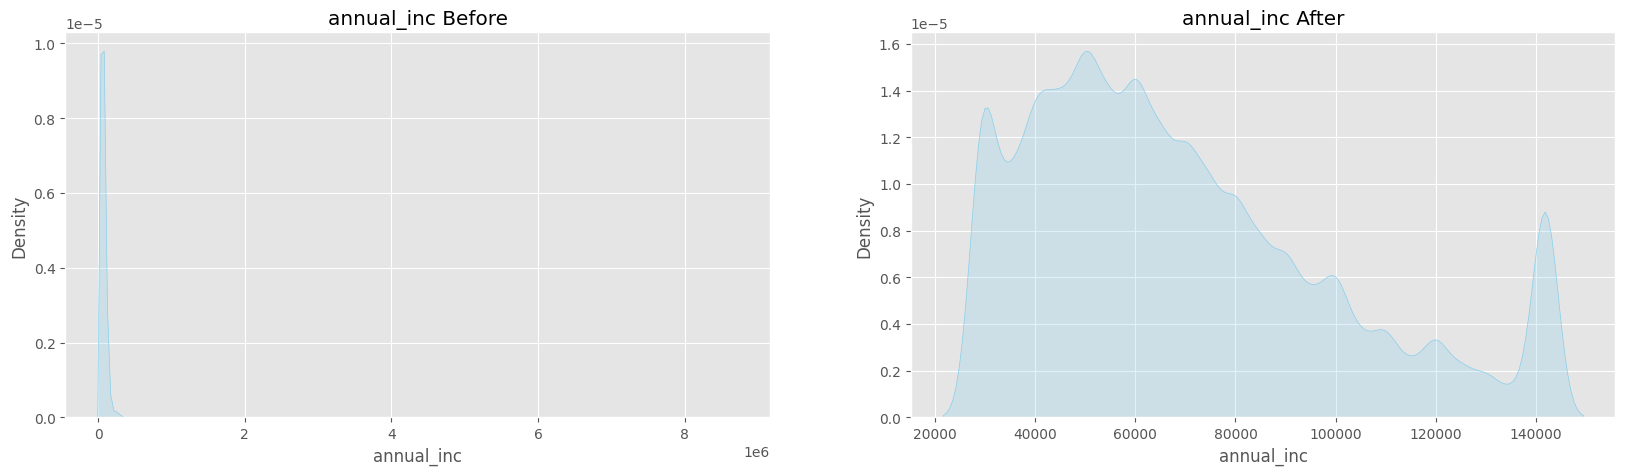

In [ ]:
fig, ax = plt.subplots(1,2, figsize=(20, 5))
sns.kdeplot(data=new_df['annual_inc'], ax=ax[0], fill=True, color='skyblue'); ax[0].set_title('annual_inc Before')
sns.kdeplot(data=treated_df['annual_inc'], ax=ax[1], fill=True, color='skyblue'); ax[1].set_title('annual_inc After')
plt.show()

In [ ]:
treated_df.drop('outlier', axis=1, inplace=True)

In [ ]:
# Saving Imputed DF
treated_df.to_csv(f"{data_folder}/LoanTapData_outlier_treated.csv", index=False)

In [ ]:
# Load Imputed DF
treated_df = pd.read_csv(f"{data_folder}/LoanTapData_outlier_treated.csv", parse_dates=['issue_d', 'earliest_cr_line'])
treated_df.head()

loan_amnt        term  int_rate  installment grade sub_grade  \
0     8000.0   36 months     11.99   265.676271     B        B5   
1    15600.0   36 months     10.49   506.964563     B        B3   
2     7200.0   36 months      6.49   220.640051     A        A2   
3    24375.0   60 months     17.27   609.325862     C        C5   
4    20000.0   36 months     13.33   677.062405     C        C3   

                 emp_title emp_length home_ownership  annual_inc  \
0          Credit analyst     4 years       MORTGAGE     65000.0   
1             Statistician   < 1 year           RENT     43057.0   
2          Client Advocate    6 years           RENT     54000.0   
3  Destiny Management Inc.    9 years       MORTGAGE     55000.0   
4            HR Specialist  10+ years       MORTGAGE     86788.0   

  verification_status    issue_d  loan_status             purpose  \
0        Not Verified 2015-01-01            1  debt_consolidation   
1     Source Verified 2015-01-01            1         credit_card   
2        Not Verified 2014-11-01            1         credit_card   
3            Verified 2013-04-01            0         credit_card   
4            Verified 2015-09-01            1  debt_consolidation   

                     title    dti earliest_cr_line  open_acc  pub_rec  \
0       Debt consolidation  22.05       2004-07-01      17.0      0.0   
1  Credit card refinancing  12.79       2007-08-01      13.0      0.0   
2  Credit card refinancing   2.60       2006-09-01       6.0      0.0   
3    Credit Card Refinance  33.95       1999-03-01      13.0      0.0   
4       Debt consolidation  16.31       2005-01-01       8.0      0.0   

   revol_bal  revol_util  total_acc initial_list_status  mort_acc  \
0    20131.0        53.3       27.0                   f       3.0   
1    11987.0        92.2       26.0                   f       0.0   
2     5472.0        21.5       13.0                   f       0.0   
3    24584.0        69.8       43.0                   f       1.0   
4    25757.0        92.2       23.0                   f       4.0   

   pub_rec_bankruptcies  pincode  loan_term  
0                   0.0     5113         36  
1                   0.0     5113         36  
2                   0.0      813         36  
3                   0.0    11650         60  
4                   0.0    30723         36

# Category Analysis

  0%|          | 0/7 [00:00<?, ?it/s]

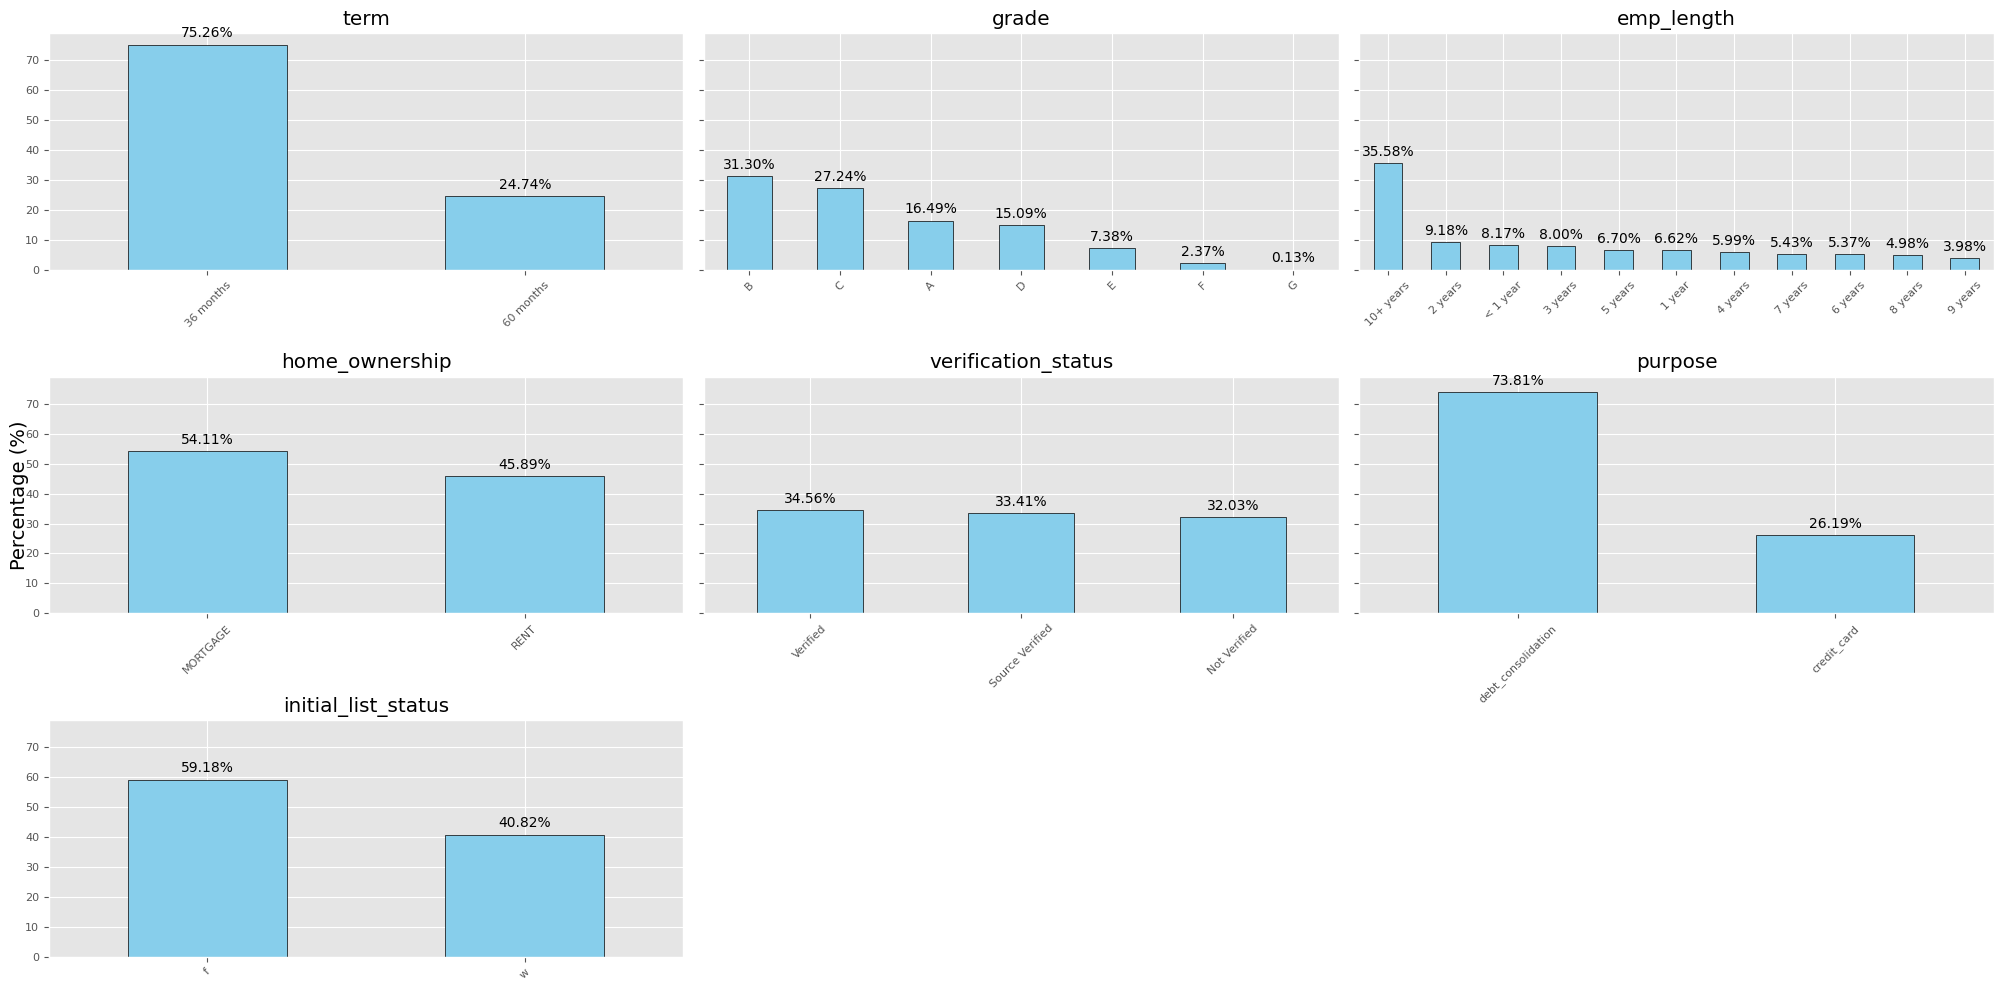

In [ ]:
object_features = treated_df.select_dtypes(include='object').drop(['emp_title', 'title', 'sub_grade'], axis=1).columns
fig, ax = plt.subplots(math.ceil(len(object_features) / 3), 3, figsize=(20, 10), sharey=True, constrained_layout=True)
ax = ax.flatten()
# Plot Count bars
for i, col in tqdm(enumerate(object_features), total=len(object_features)):
    percentages = (treated_df[col].value_counts(normalize=True) * 100).sort_values(ascending=False)
    bars = percentages.plot(kind='bar', ax=ax[i], color='skyblue', edgecolor='black')
    ax[i].set_title(col)
    ax[i].tick_params(axis='x', rotation=45, labelsize=8)
    ax[i].tick_params(axis='y', labelsize=8)
    ax[i].set_xlabel('')

    # Add percentage labels on each bar
    for bar in bars.patches:
        height = bar.get_height()
        ax[i].annotate(f'{height:.2f}%',  # Format the percentage with 2 decimal places
                       xy=(bar.get_x() + bar.get_width() / 2, height),  # Position the label
                       xytext=(0, 3),  # Offset the label slightly above the bar
                       textcoords='offset points',
                       ha='center', va='bottom', fontsize=10)

# Show
fig.text(0.0, 0.5, 'Percentage (%)', va='center', rotation='vertical', fontsize=14)  # y-axis label
for i in range(len(object_features), len(ax)):
    ax[i].axis('off')
plt.tight_layout()
plt.show()

**Analysis**
- 76% of credit lines are set to a 36-month term, reflecting a clear preference for medium-term financing.
- More than 25% of customers fall below grade C, indicating a notable segment with room for financial improvement.
- A significant portion of our customer base is senior and experienced, bringing valuable financial maturity to the mix.
- One-third of customers are 'Not Verified', highlighting an opportunity to enhance our verification processes and customer trust.
- 76% of customers seek debt consolidation, showcasing a strong demand for solutions to manage existing financial obligations.

  0%|          | 0/7 [00:00<?, ?it/s]

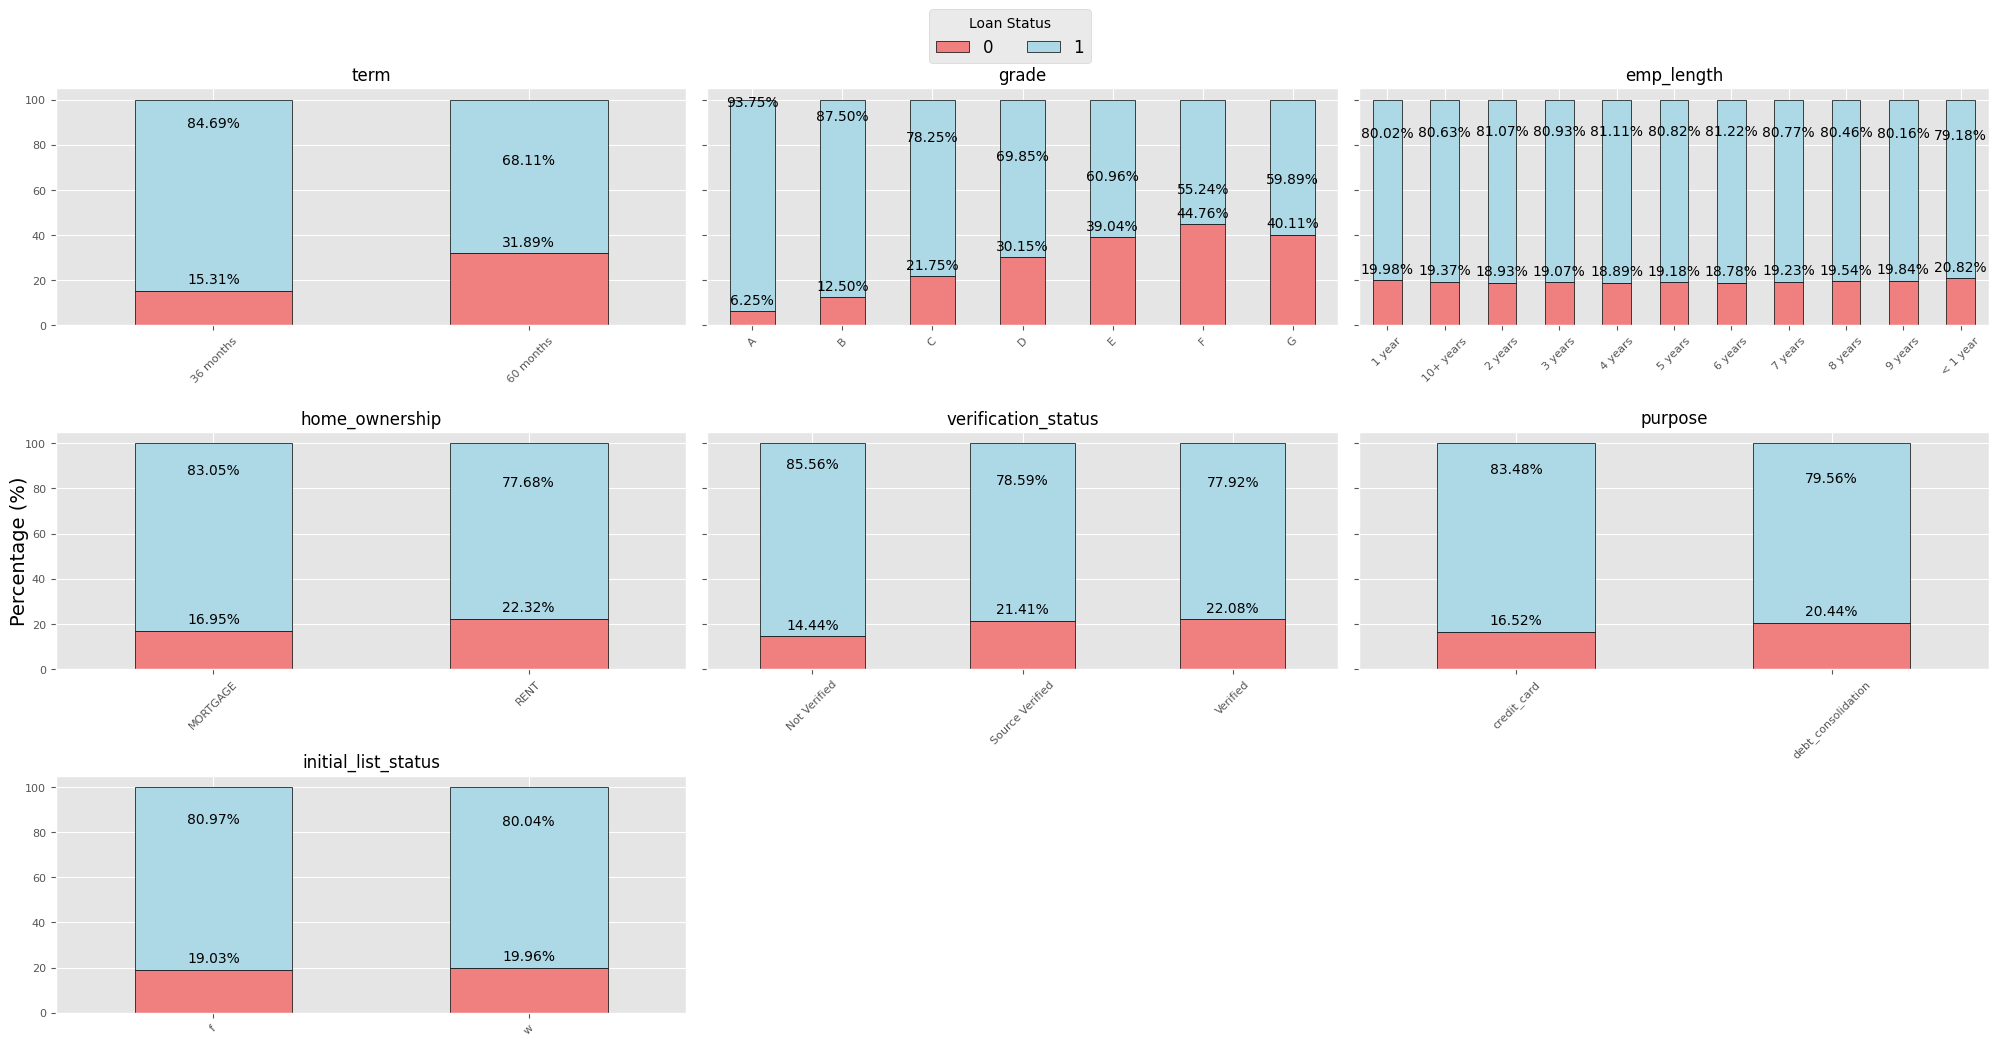

In [ ]:
object_features = treated_df.select_dtypes(include='object').drop(['emp_title', 'title', 'sub_grade'], axis=1).columns
fig, ax = plt.subplots(math.ceil(len(object_features) / 3), 3, figsize=(20, 10), sharey=True, constrained_layout=True)
ax = ax.flatten()

# Plot Count bars with percentages as labels and hue for loan_status (stacked)
for i, col in tqdm(enumerate(object_features), total=len(object_features)):
    # Create a dataframe with counts for the feature and loan_status
    counts = treated_df.groupby([col, 'loan_status']).size().unstack().fillna(0)

    # Normalize by row to get percentage for each 'loan_status' within each category of the feature
    percentages = counts.div(counts.sum(axis=1), axis=0) * 100

    # Plot stacked bar chart
    percentages.plot(kind='bar', stacked=True, ax=ax[i], color=['lightcoral', 'lightblue'], edgecolor='black', legend=False)
    ax[i].set_title(col, fontsize=12)
    ax[i].tick_params(axis='x', rotation=45, labelsize=8)  # Rotate x-axis labels for better readability
    ax[i].tick_params(axis='y', labelsize=8)
    ax[i].set_xlabel('')

    # Add percentage labels on each bar
    for bar in ax[i].patches:
        height = bar.get_height()
        ax[i].annotate(f'{height:.2f}%',  # Format the percentage with 2 decimal places
                       xy=(bar.get_x() + bar.get_width() / 2, bar.get_height()),  # Position the label
                       xytext=(0, 3),  # Offset the label slightly above the bar
                       textcoords='offset points',
                       ha='center', va='bottom', fontsize=10)

# Show
handles, labels = ax[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center', fontsize=12, title='Loan Status', ncol=2, bbox_to_anchor=(0.5, 1.05))
fig.text(0.0, 0.5, 'Percentage (%)', va='center', rotation='vertical', fontsize=14)
for i in range(len(object_features), len(ax)):
    ax[i].axis('off')
plt.tight_layout()
plt.show()

- Lower credit grades correlate with higher NPAs
- Employee experience does not predict payment behavior
- Interestingly, *Not Verified* customers exhibit a higher repayment rate

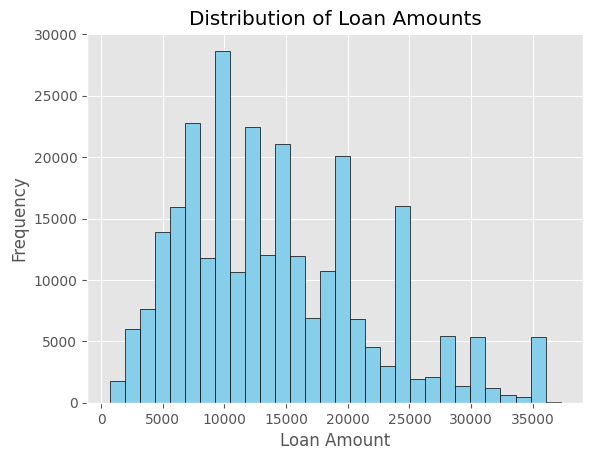

In [ ]:
treated_df['loan_amnt'].plot(kind='hist', bins=30, edgecolor='black', color='skyblue')
plt.xlabel('Loan Amount')
plt.ylabel('Frequency')
plt.title('Distribution of Loan Amounts')
plt.show()

In [ ]:
# Creating Feature
bins = [0, 5000, 15000, 25000, 30000, float('inf')]
labels = ['<5k', '5k-15k', '15k-25k', '25k-30k', '30k+']
treated_df['loan_amnt_bin'] = pd.cut(treated_df['loan_amnt'], bins=bins, labels=labels, include_lowest=True)
treated_df['loan_amnt_bin'] = treated_df['loan_amnt_bin'].astype('object')

  0%|          | 0/8 [00:00<?, ?it/s]

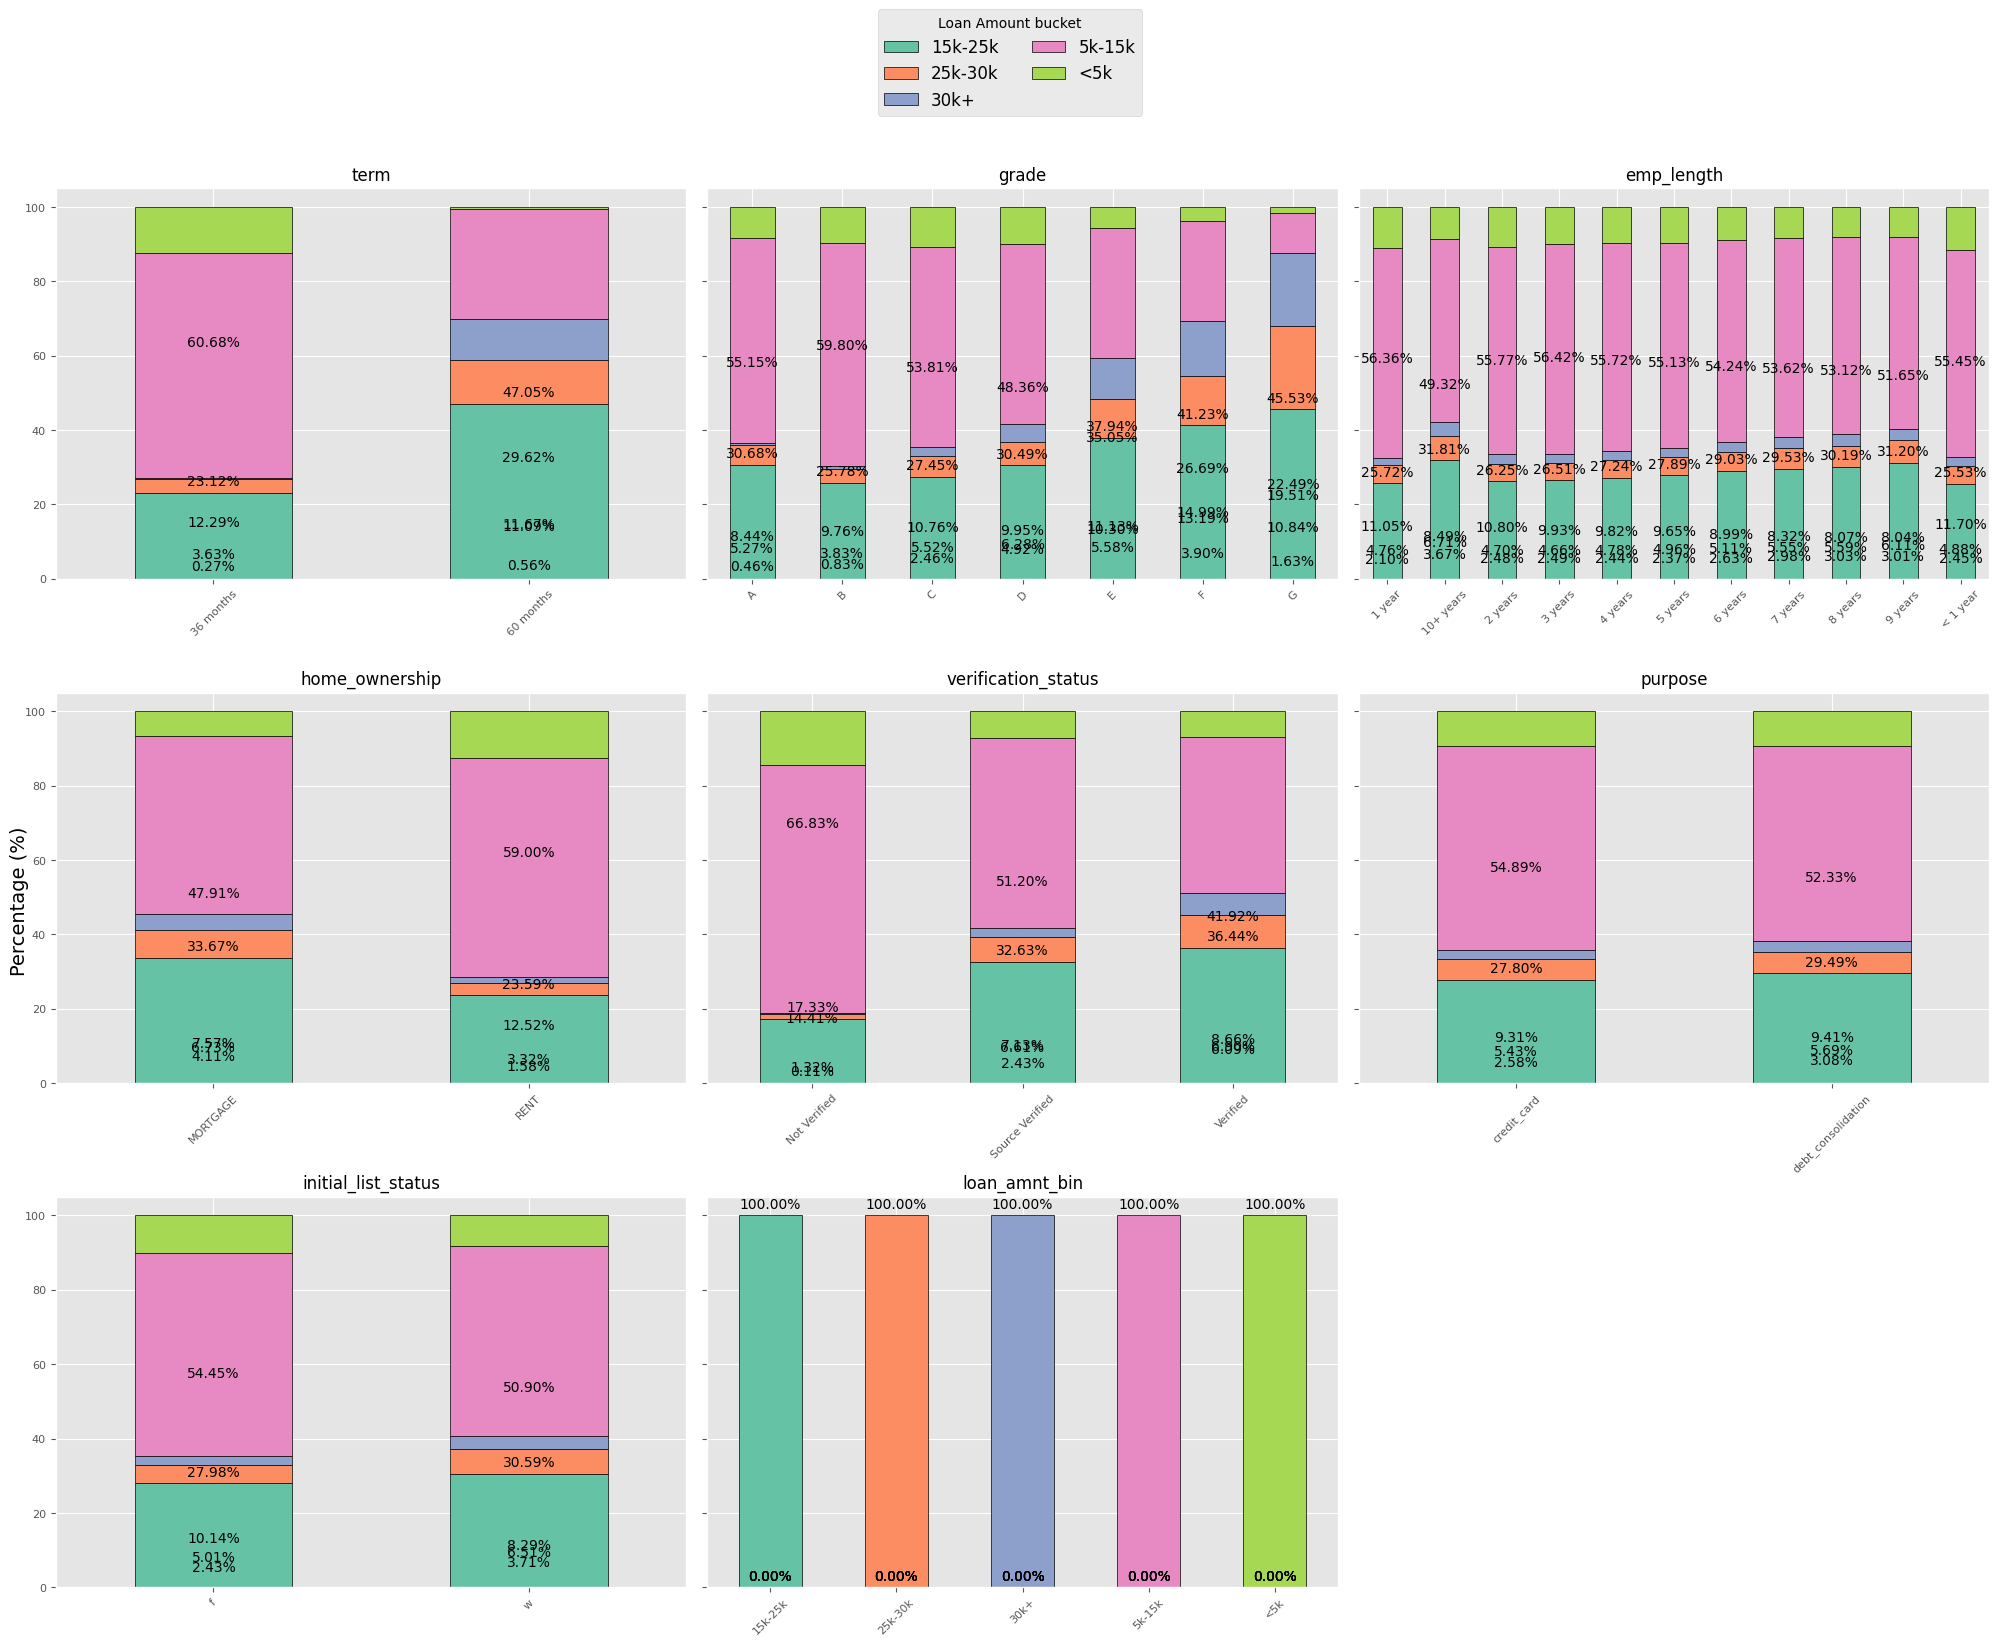

In [ ]:
object_features = treated_df.select_dtypes(include='object').drop(['emp_title', 'title', 'sub_grade'], axis=1).columns
fig, ax = plt.subplots(math.ceil(len(object_features) / 3), 3, figsize=(20, 15), sharey=True, constrained_layout=True)
ax = ax.flatten()

# Plot Count bars with percentages as labels and hue for loan_amnt_bin (stacked)
for i, col in tqdm(enumerate(object_features), total=len(object_features)):
    # Create a dataframe with counts for the feature and loan_amnt_bin
    counts = treated_df.groupby([col, 'loan_amnt_bin']).size().unstack().fillna(0)
    palette = sns.color_palette("Set2", n_colors=len(counts.columns))

    # Normalize by row to get percentage for each 'loan_amnt_bin' within each category of the feature
    percentages = counts.div(counts.sum(axis=1), axis=0) * 100

    # Plot stacked bar chart
    percentages.plot(kind='bar', stacked=True, ax=ax[i], color=palette, edgecolor='black', legend=False)
    ax[i].set_title(col, fontsize=12)
    ax[i].tick_params(axis='x', rotation=45, labelsize=8)  # Rotate x-axis labels for better readability
    ax[i].tick_params(axis='y', labelsize=8)
    ax[i].set_xlabel('')

    # Add percentage labels on each bar
    for bar in ax[i].patches:
        height = bar.get_height()
        ax[i].annotate(f'{height:.2f}%',  # Format the percentage with 2 decimal places
                       xy=(bar.get_x() + bar.get_width() / 2, bar.get_height()),  # Position the label
                       xytext=(0, 3),  # Offset the label slightly above the bar
                       textcoords='offset points',
                       ha='center', va='bottom', fontsize=10)

# Show
handles, labels = ax[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center', fontsize=12, title='Loan Amount bucket', ncol=2, bbox_to_anchor=(0.5, 1.1))
# fig.text(0.5, 0.0, 'Categories', ha='center', fontsize=14)  # x-axis label
fig.text(0.0, 0.5, 'Percentage (%)', va='center', rotation='vertical', fontsize=14)  # y-axis label
for i in range(len(object_features), len(ax)):
    ax[i].axis('off')
plt.tight_layout()
plt.show()

- The largest segment of customers falls within the loan amount range of 5k to 15k.
- Notably, loan amounts tend to be higher in grades lower than C, which may indicate higher risk-reward lending behavior.
- Interestingly, the 5k to 15k loan bucket contributes significantly to both the `debt consolidation` and `credit card` categories.

In [ ]:
def create_stacked_bars(counts, perc_label=True):
    palette = sns.color_palette("Set2", n_colors=len(counts.columns))

    # Normalize by row to get percentage for each value within each category of the feature
    percentages = counts.div(counts.sum(axis=1), axis=0) * 100

    percentages.plot(kind='bar', stacked=True, ax=ax[i], color=palette, edgecolor='black')
    ax[i].set_title(col, fontsize=12)
    ax[i].tick_params(axis='x', rotation=45, labelsize=8)  # Rotate x-axis labels for better readability
    ax[i].tick_params(axis='y', labelsize=8)
    ax[i].set_xlabel('')

    # Add percentage labels on each bar
    if perc_label:
        for p in ax[i].patches:
            height = p.get_height()
            width = p.get_width()
            x_pos = p.get_x() + width / 2
            y_pos = p.get_y() + height / 2
            if height > 0:
                ax[i].annotate(f'{height:.1f}%',
                            xy=(x_pos, y_pos),
                            ha='center', va='center',
                            fontsize=10, color='black')

  0%|          | 0/9 [00:00<?, ?it/s]

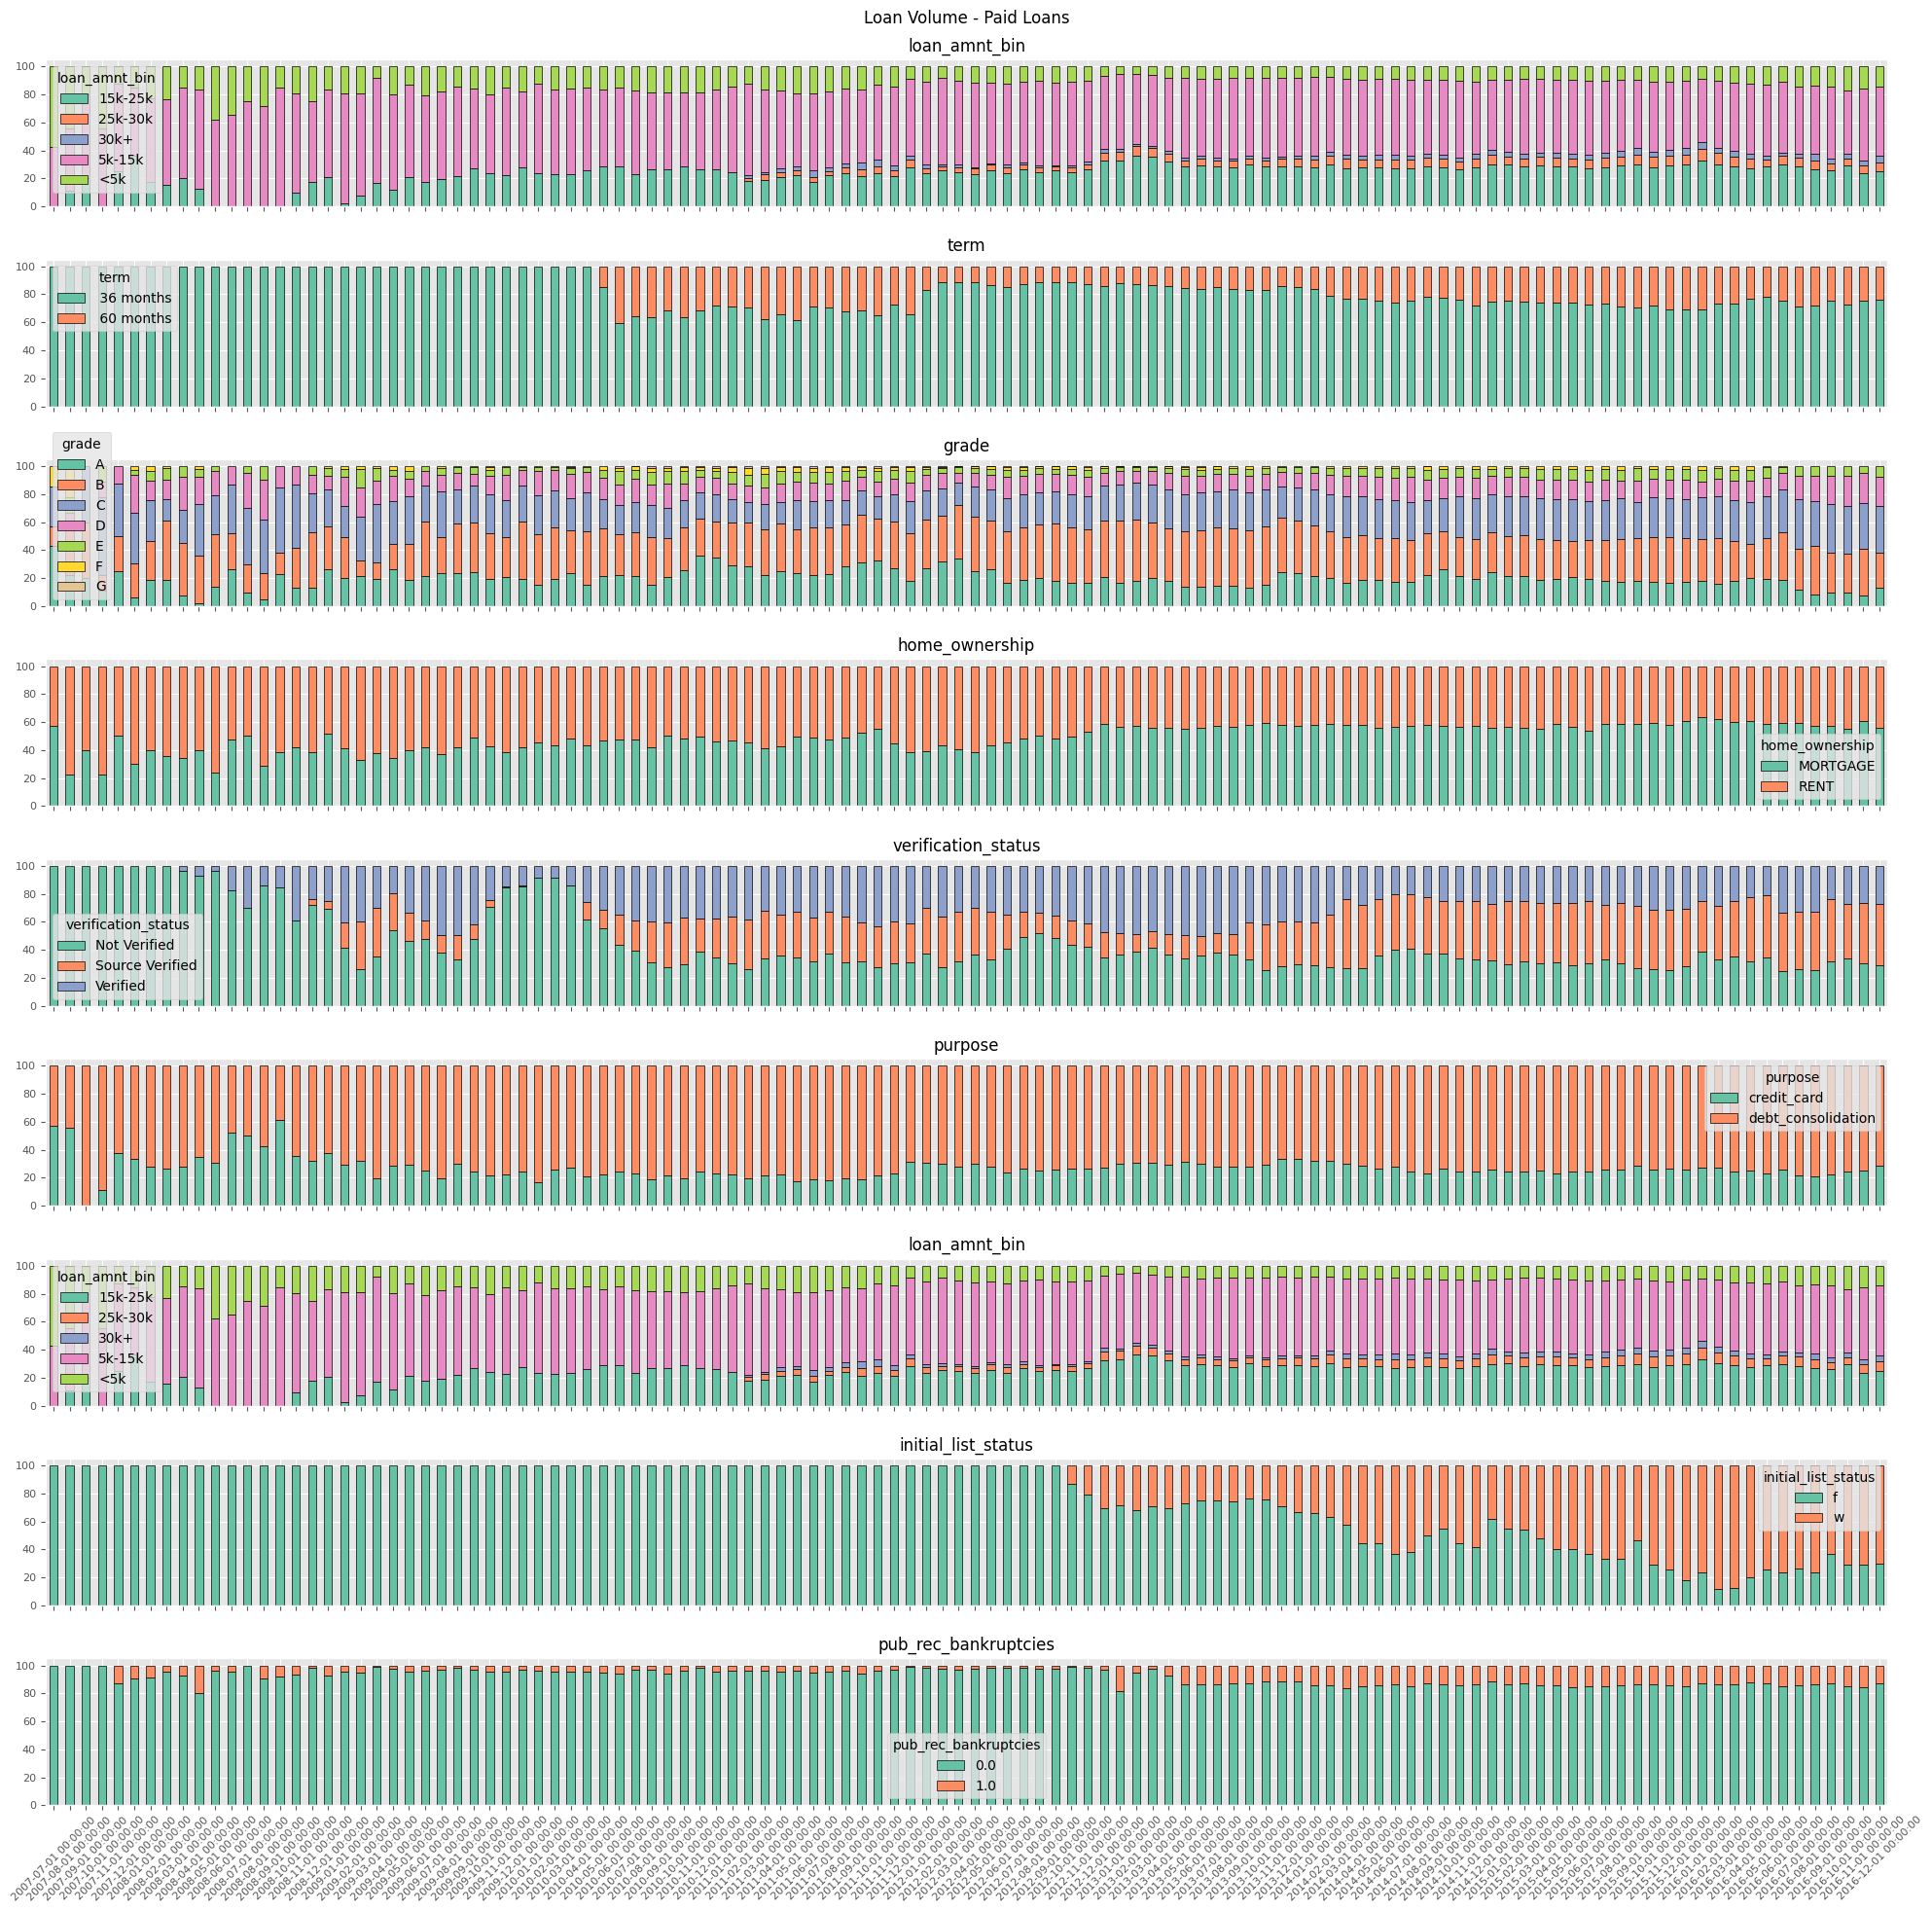

In [ ]:
# Loan Volume - Paid Loans
object_features = ['loan_amnt_bin', 'term', 'grade', 'home_ownership', 'verification_status', 'purpose', 'loan_amnt_bin', 'initial_list_status', 'pub_rec_bankruptcies']
fig, ax = plt.subplots(len(object_features), 1, figsize=(20, 20), sharey=True, sharex=True, constrained_layout=True)
ax = ax.flatten()

# Plot Count bars with percentages as labels and hue for cols (stacked)
for i, col in tqdm(enumerate(object_features), total=len(object_features)):
    counts = treated_df[treated_df['loan_status']==1].groupby(['issue_d', col]).size().unstack().fillna(0)
    create_stacked_bars(counts, perc_label=False)

# Show
for i in range(len(object_features), len(ax)):
    ax[i].axis('off')
plt.suptitle('Loan Volume - Paid Loans\n')
plt.tight_layout()
plt.show()

  0%|          | 0/9 [00:00<?, ?it/s]

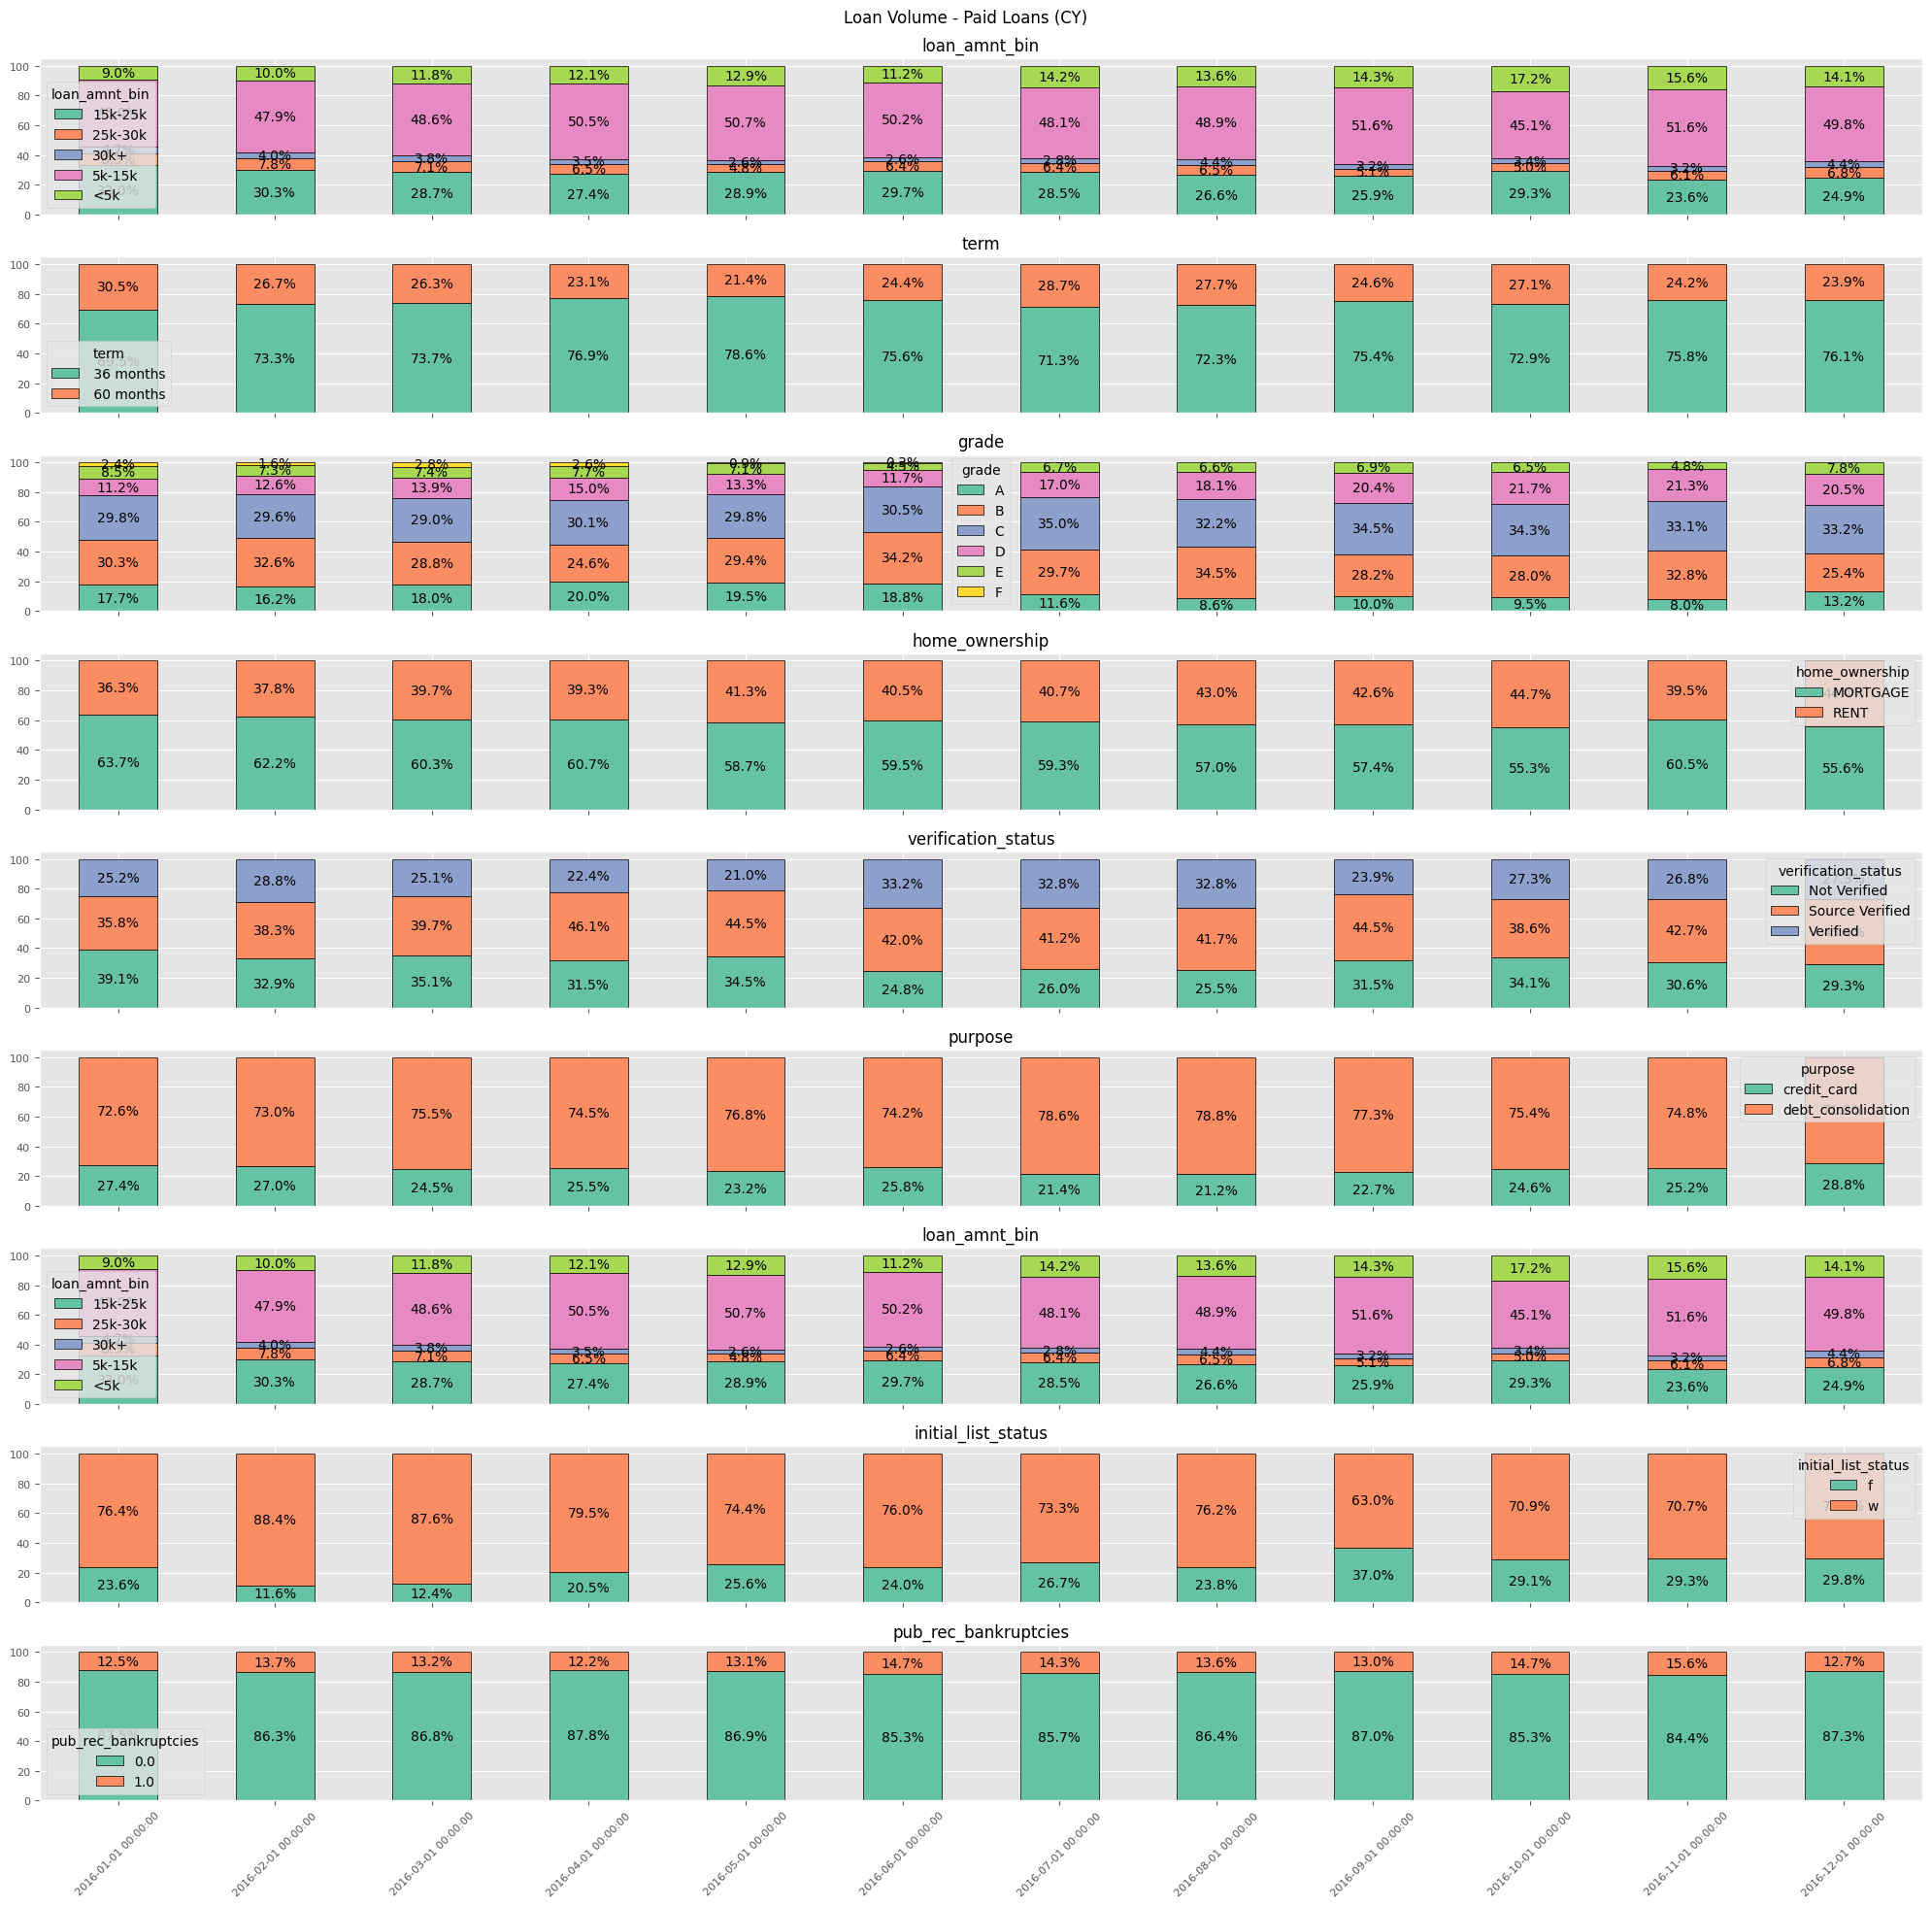

In [ ]:
#Loan Volume - Paid Loans (CY)
fig, ax = plt.subplots(len(object_features), 1, figsize=(20, 20), sharey=True, sharex=True, constrained_layout=True)
ax = ax.flatten()

# Plot Count bars with percentages as labels and hue for cols (stacked)
for i, col in tqdm(enumerate(object_features), total=len(object_features)):
    counts = treated_df[((treated_df['loan_status']==1) & (treated_df['issue_d'].dt.year == 2016))].groupby(['issue_d', col]).size().unstack().fillna(0)
    create_stacked_bars(counts, perc_label=True)

# Show
for i in range(len(object_features), len(ax)):
    ax[i].axis('off')
plt.suptitle('Loan Volume - Paid Loans (CY)\n')
plt.tight_layout()
plt.show()

  0%|          | 0/9 [00:00<?, ?it/s]

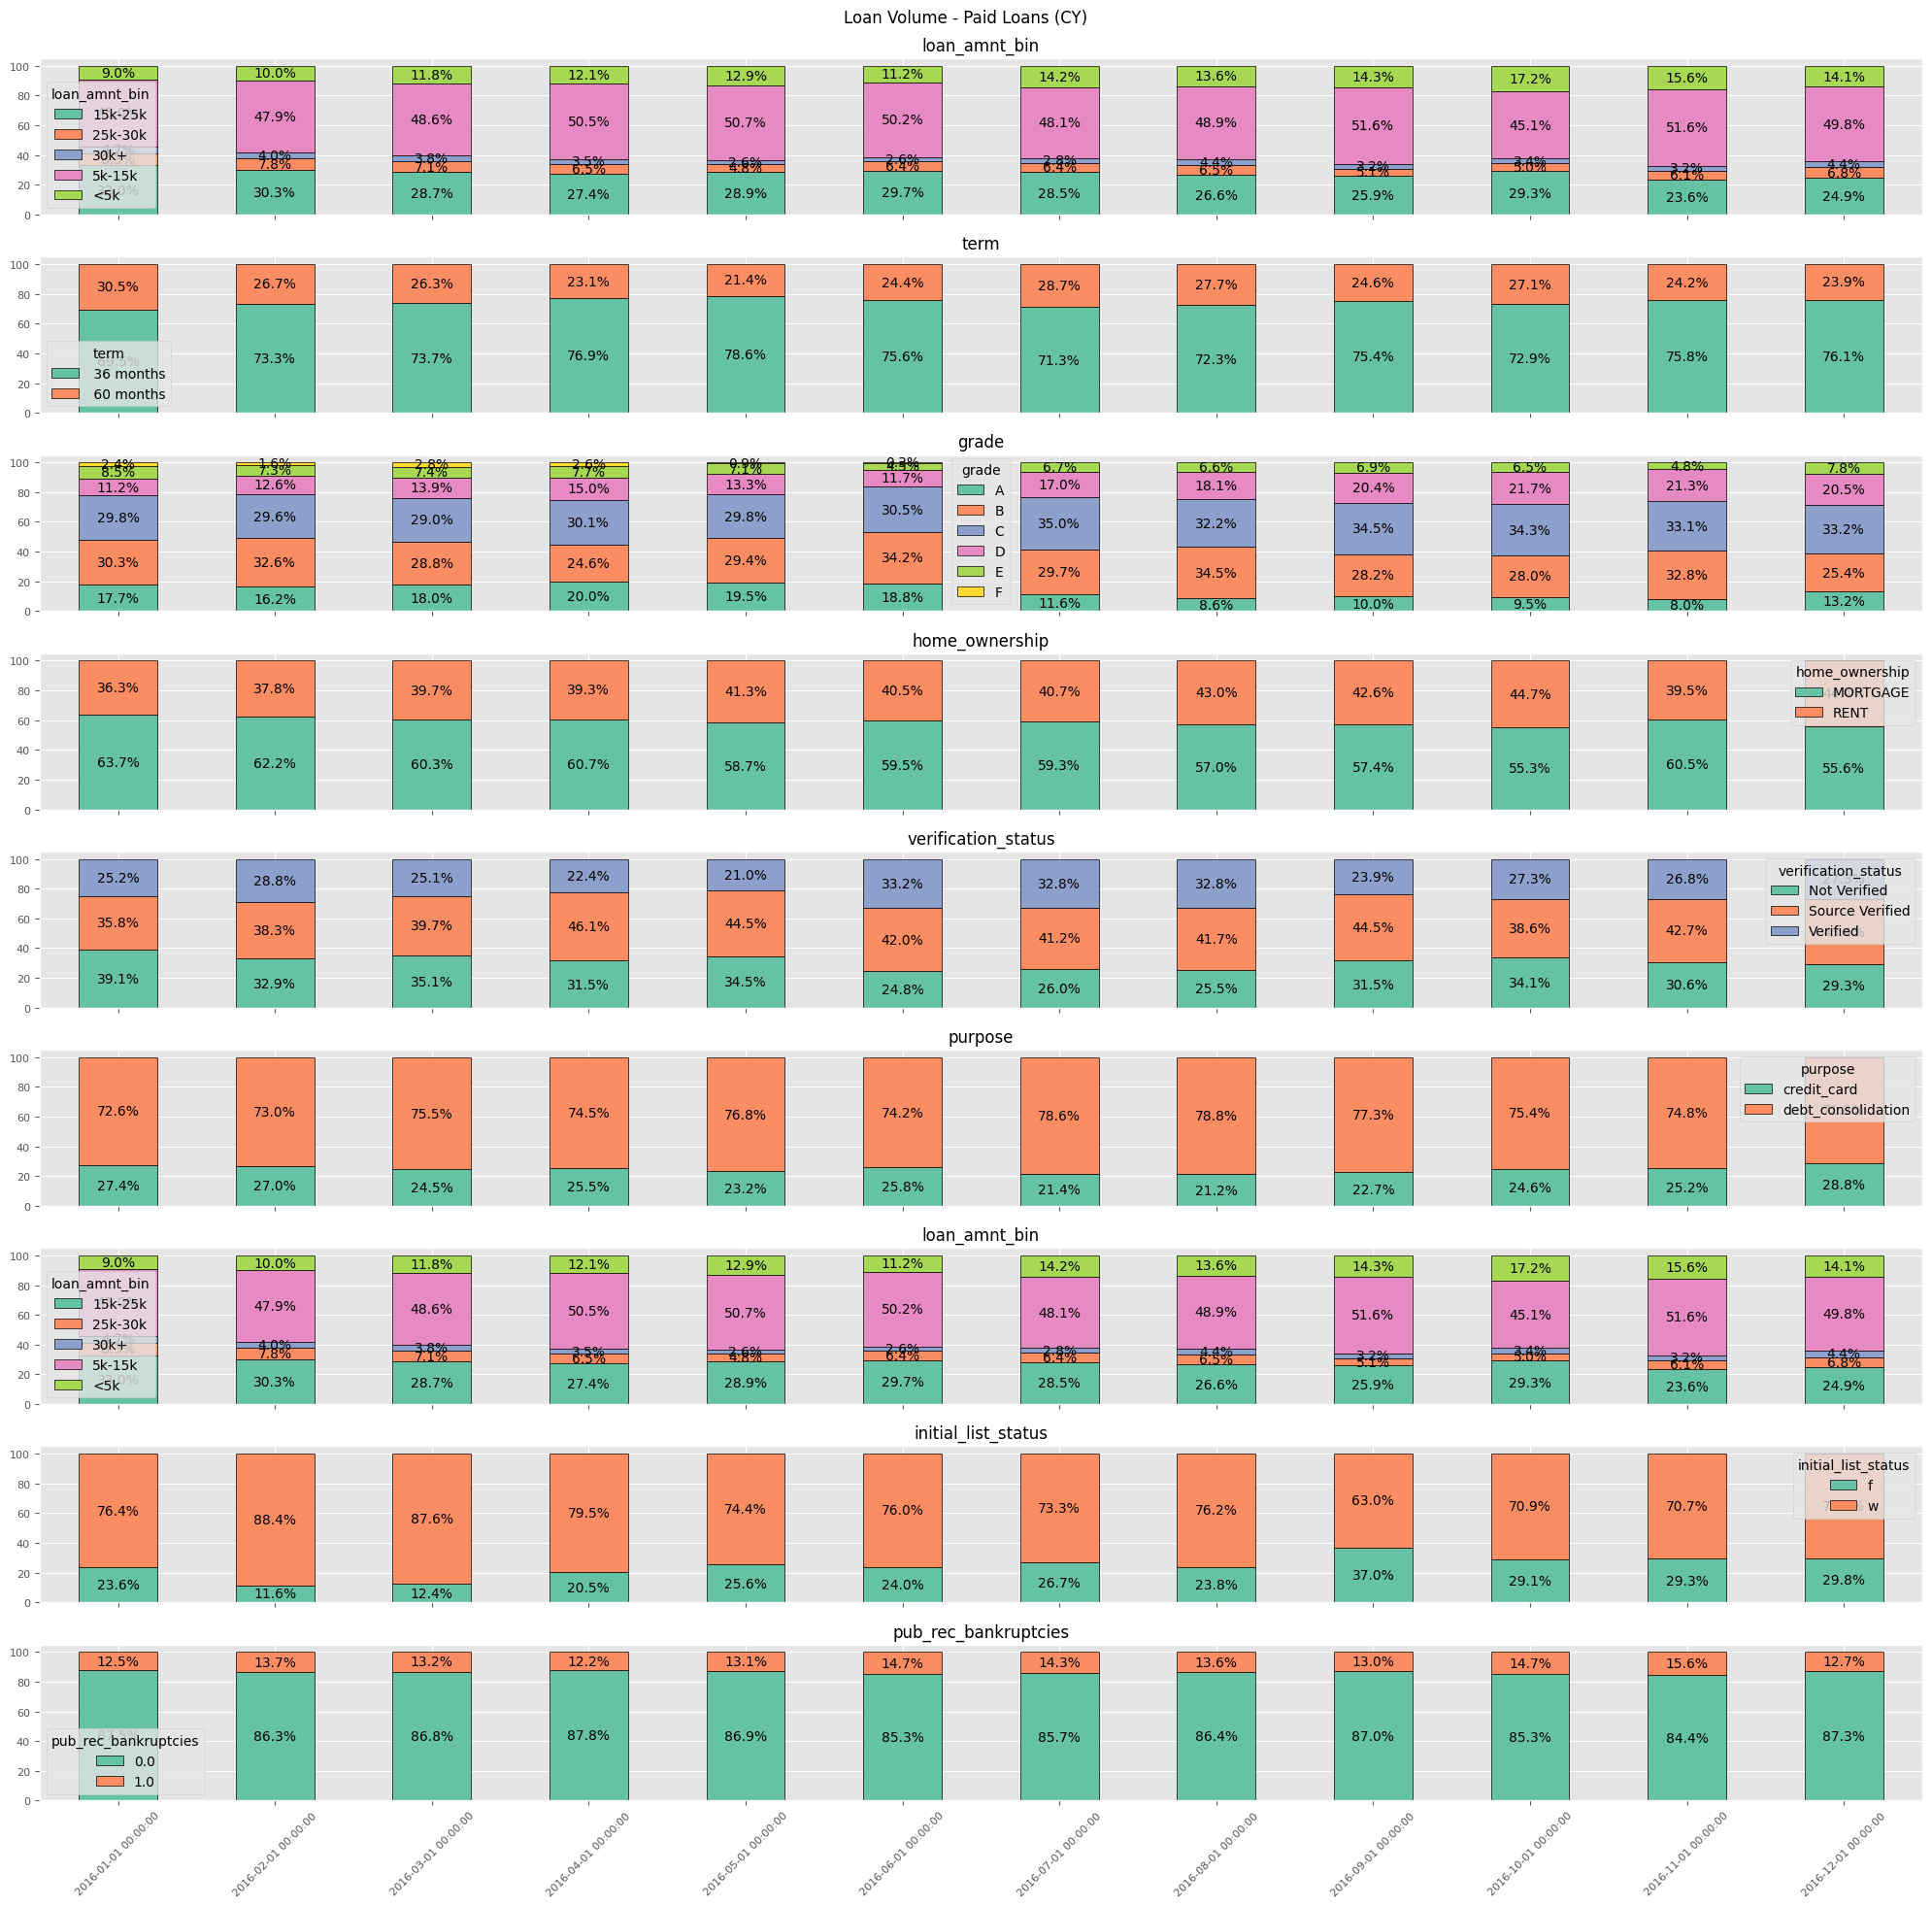

In [ ]:
#Loan Volume - Paid Loans (CY)
fig, ax = plt.subplots(len(object_features), 1, figsize=(20, 20), sharey=True, sharex=True, constrained_layout=True)
ax = ax.flatten()


# Plot Count bars with percentages as labels and hue for cols (stacked)
for i, col in tqdm(enumerate(object_features), total=len(object_features)):
    counts = treated_df[((treated_df['loan_status']==1) & (treated_df['issue_d'].dt.year == 2016))].groupby(['issue_d', col]).size().unstack().fillna(0)
    create_stacked_bars(counts, perc_label=True)

# Show
for i in range(len(object_features), len(ax)):
    ax[i].axis('off')
plt.suptitle('Loan Volume - Paid Loans (CY)\n')
plt.tight_layout()
plt.show()

  0%|          | 0/9 [00:00<?, ?it/s]

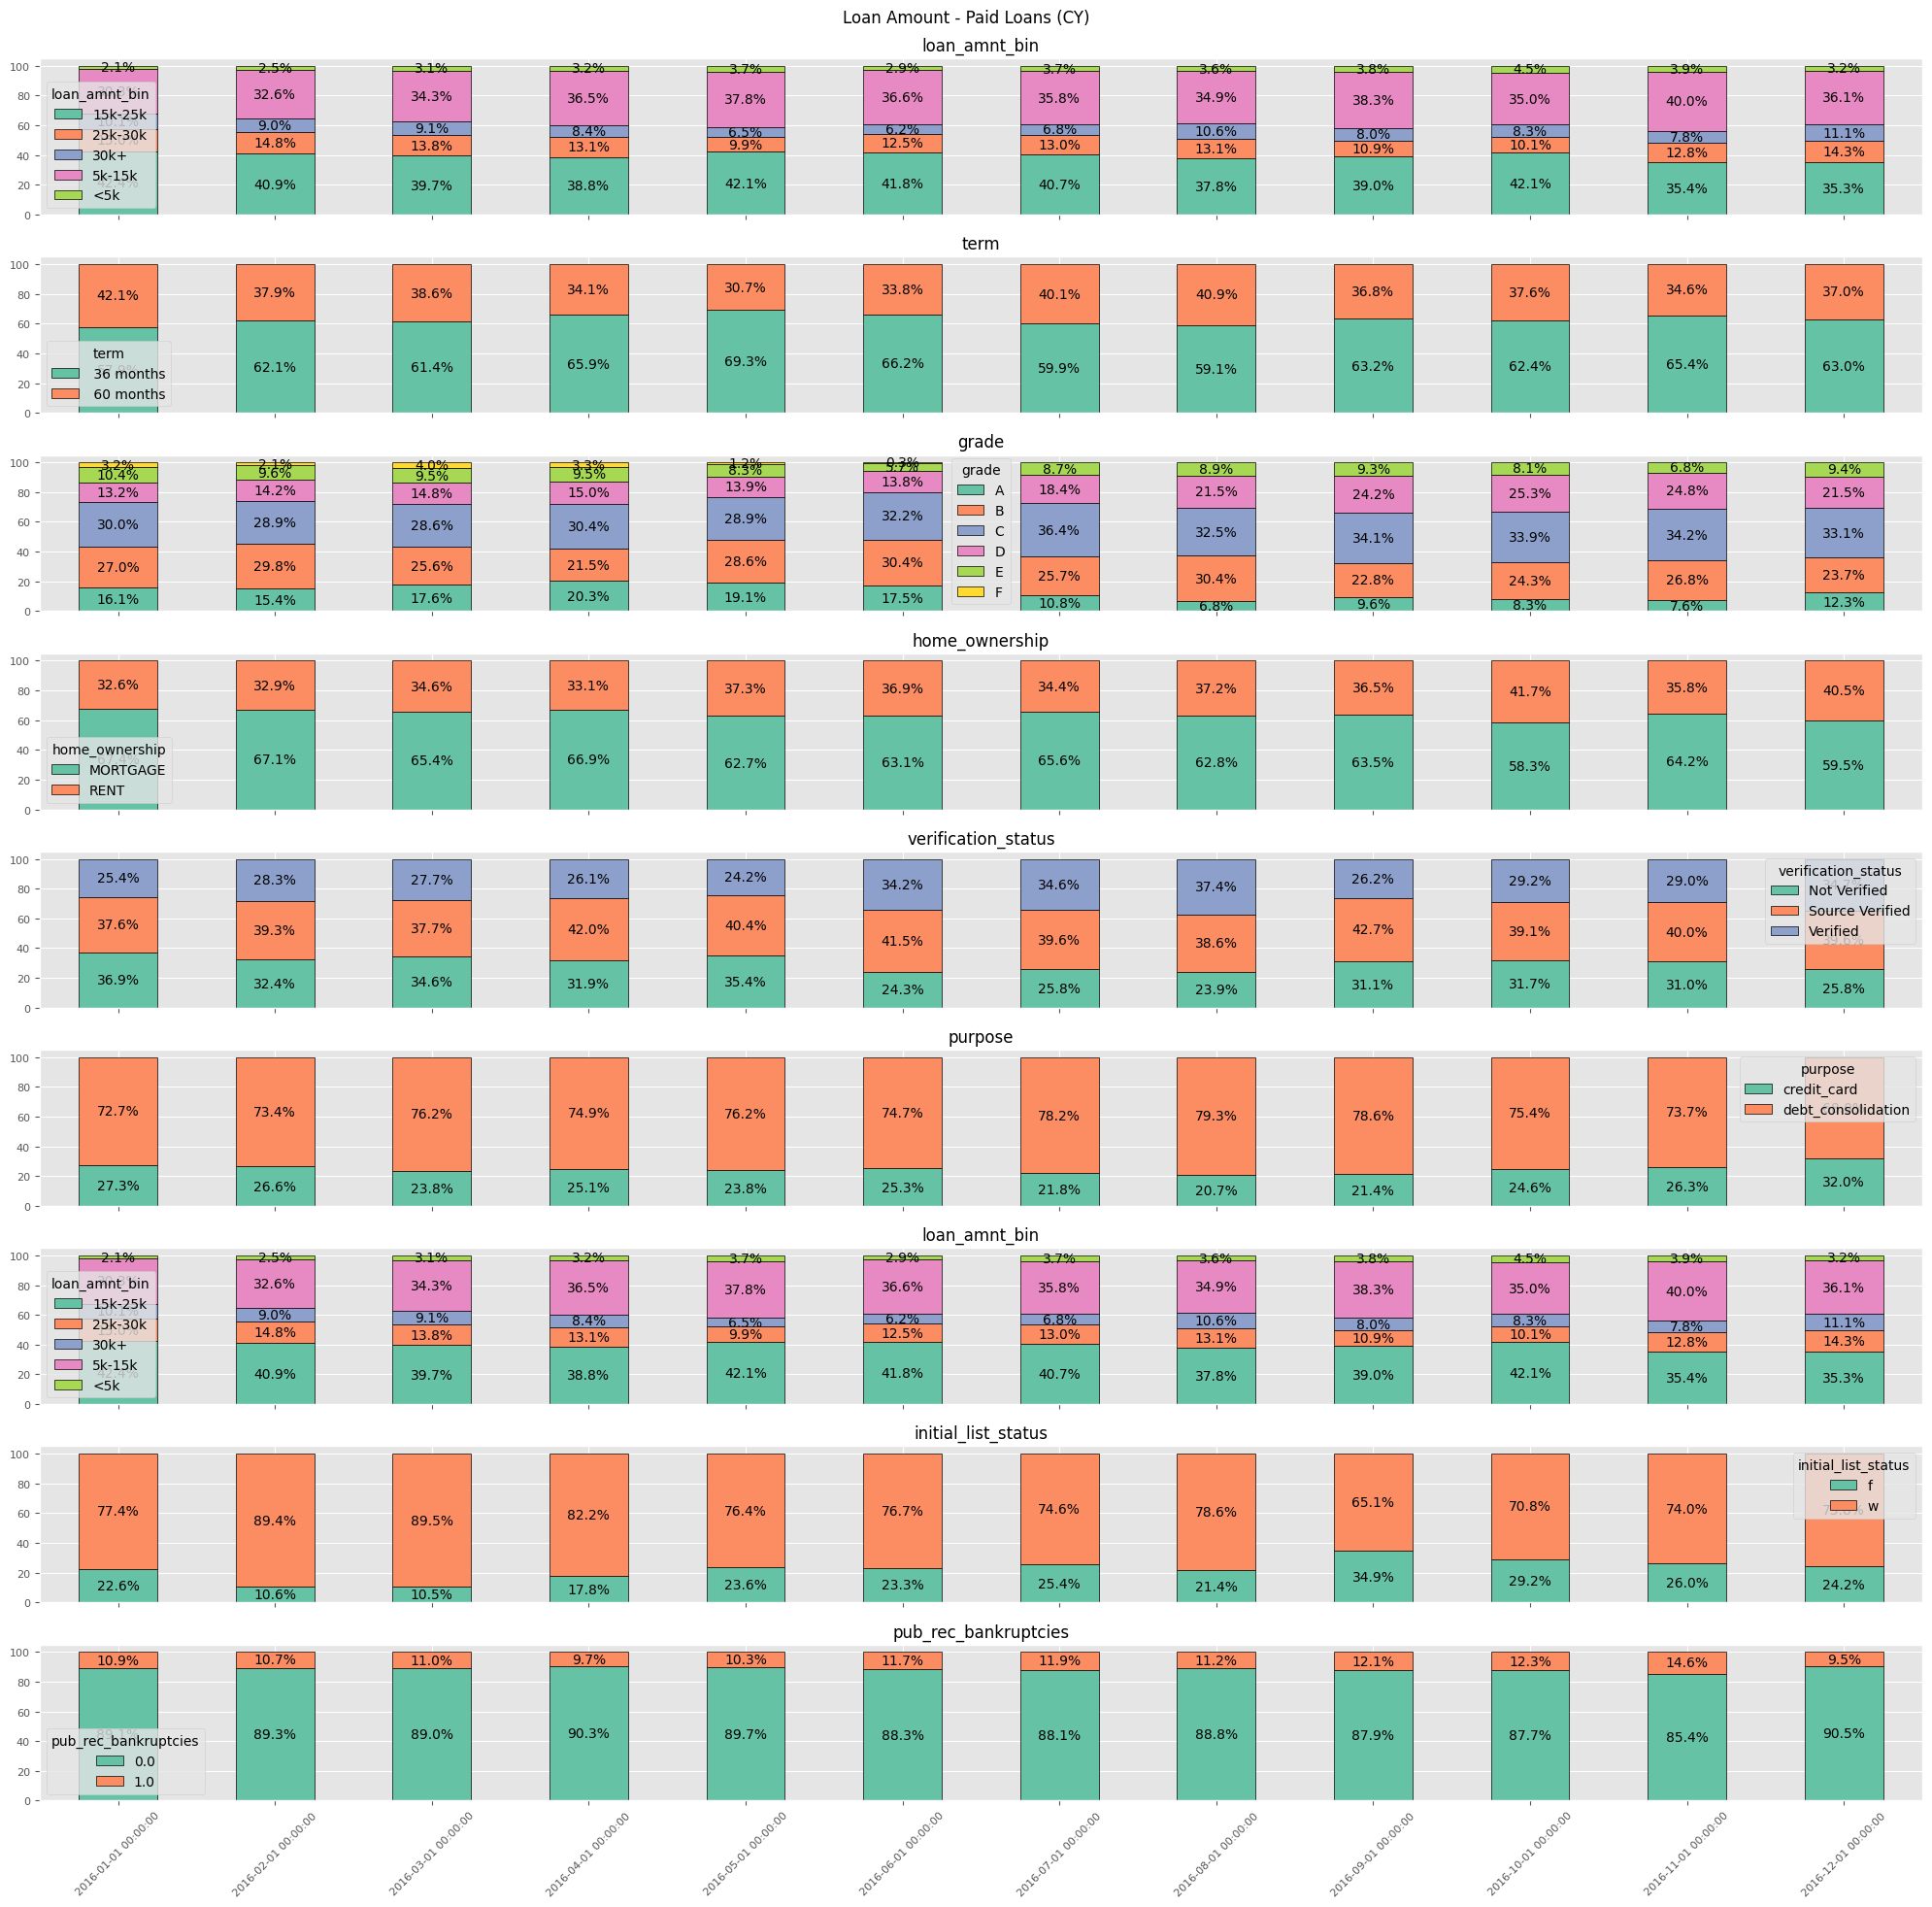

In [ ]:
#Loan Amount - Paid Loans (CY)
fig, ax = plt.subplots(len(object_features), 1, figsize=(20, 20), sharey=True, sharex=True, constrained_layout=True)
ax = ax.flatten()

# Plot Count bars with percentages as labels and hue for cols (stacked)
for i, col in tqdm(enumerate(object_features), total=len(object_features)):
    counts = treated_df[((treated_df['loan_status']==1) & (treated_df['issue_d'].dt.year == 2016))].groupby(['issue_d', col])['loan_amnt'].sum().unstack().fillna(0)
    create_stacked_bars(counts, perc_label=True)

# Show
for i in range(len(object_features), len(ax)):
    ax[i].axis('off')
plt.suptitle('Loan Amount - Paid Loans (CY)\n')
plt.tight_layout()
plt.show()

**Loan Volume Analysis of Accepted Loans:**
- **Introduction of 60-Month Term Loans:** We began offering 60-month term loans only after March 2010, and payment from this loan type has since stabilized at approximately 25-30% of our total loan volume.
- **Loan Grade Dynamics:** Grade A loans appear to have been overshadowed by Grade B and C loans, both in terms of loan volume and total loan amount disbursed.
- **Customer Demographics and Loan Trends:** The proportion of loans repayment from customers currently residing in mortgage apartments has decreased to an average of 58% in the second half of this year, compared to 60% in the first half. Similar trend is shown in share of total loan disbursal.
- **Credit Card Loan Volume:** At the beginning of the second half of the year, credit card loan volumes dropped by 400-500 basis points. Fortunately, there has been a steady recovery over the past three months, signaling a potential return to growth.
- The loan disbursement to the sub-5k bucket was reduced by 300 basis points, while the disbursement to larger loans increased by approximately 400 basis points.

  0%|          | 0/9 [00:00<?, ?it/s]

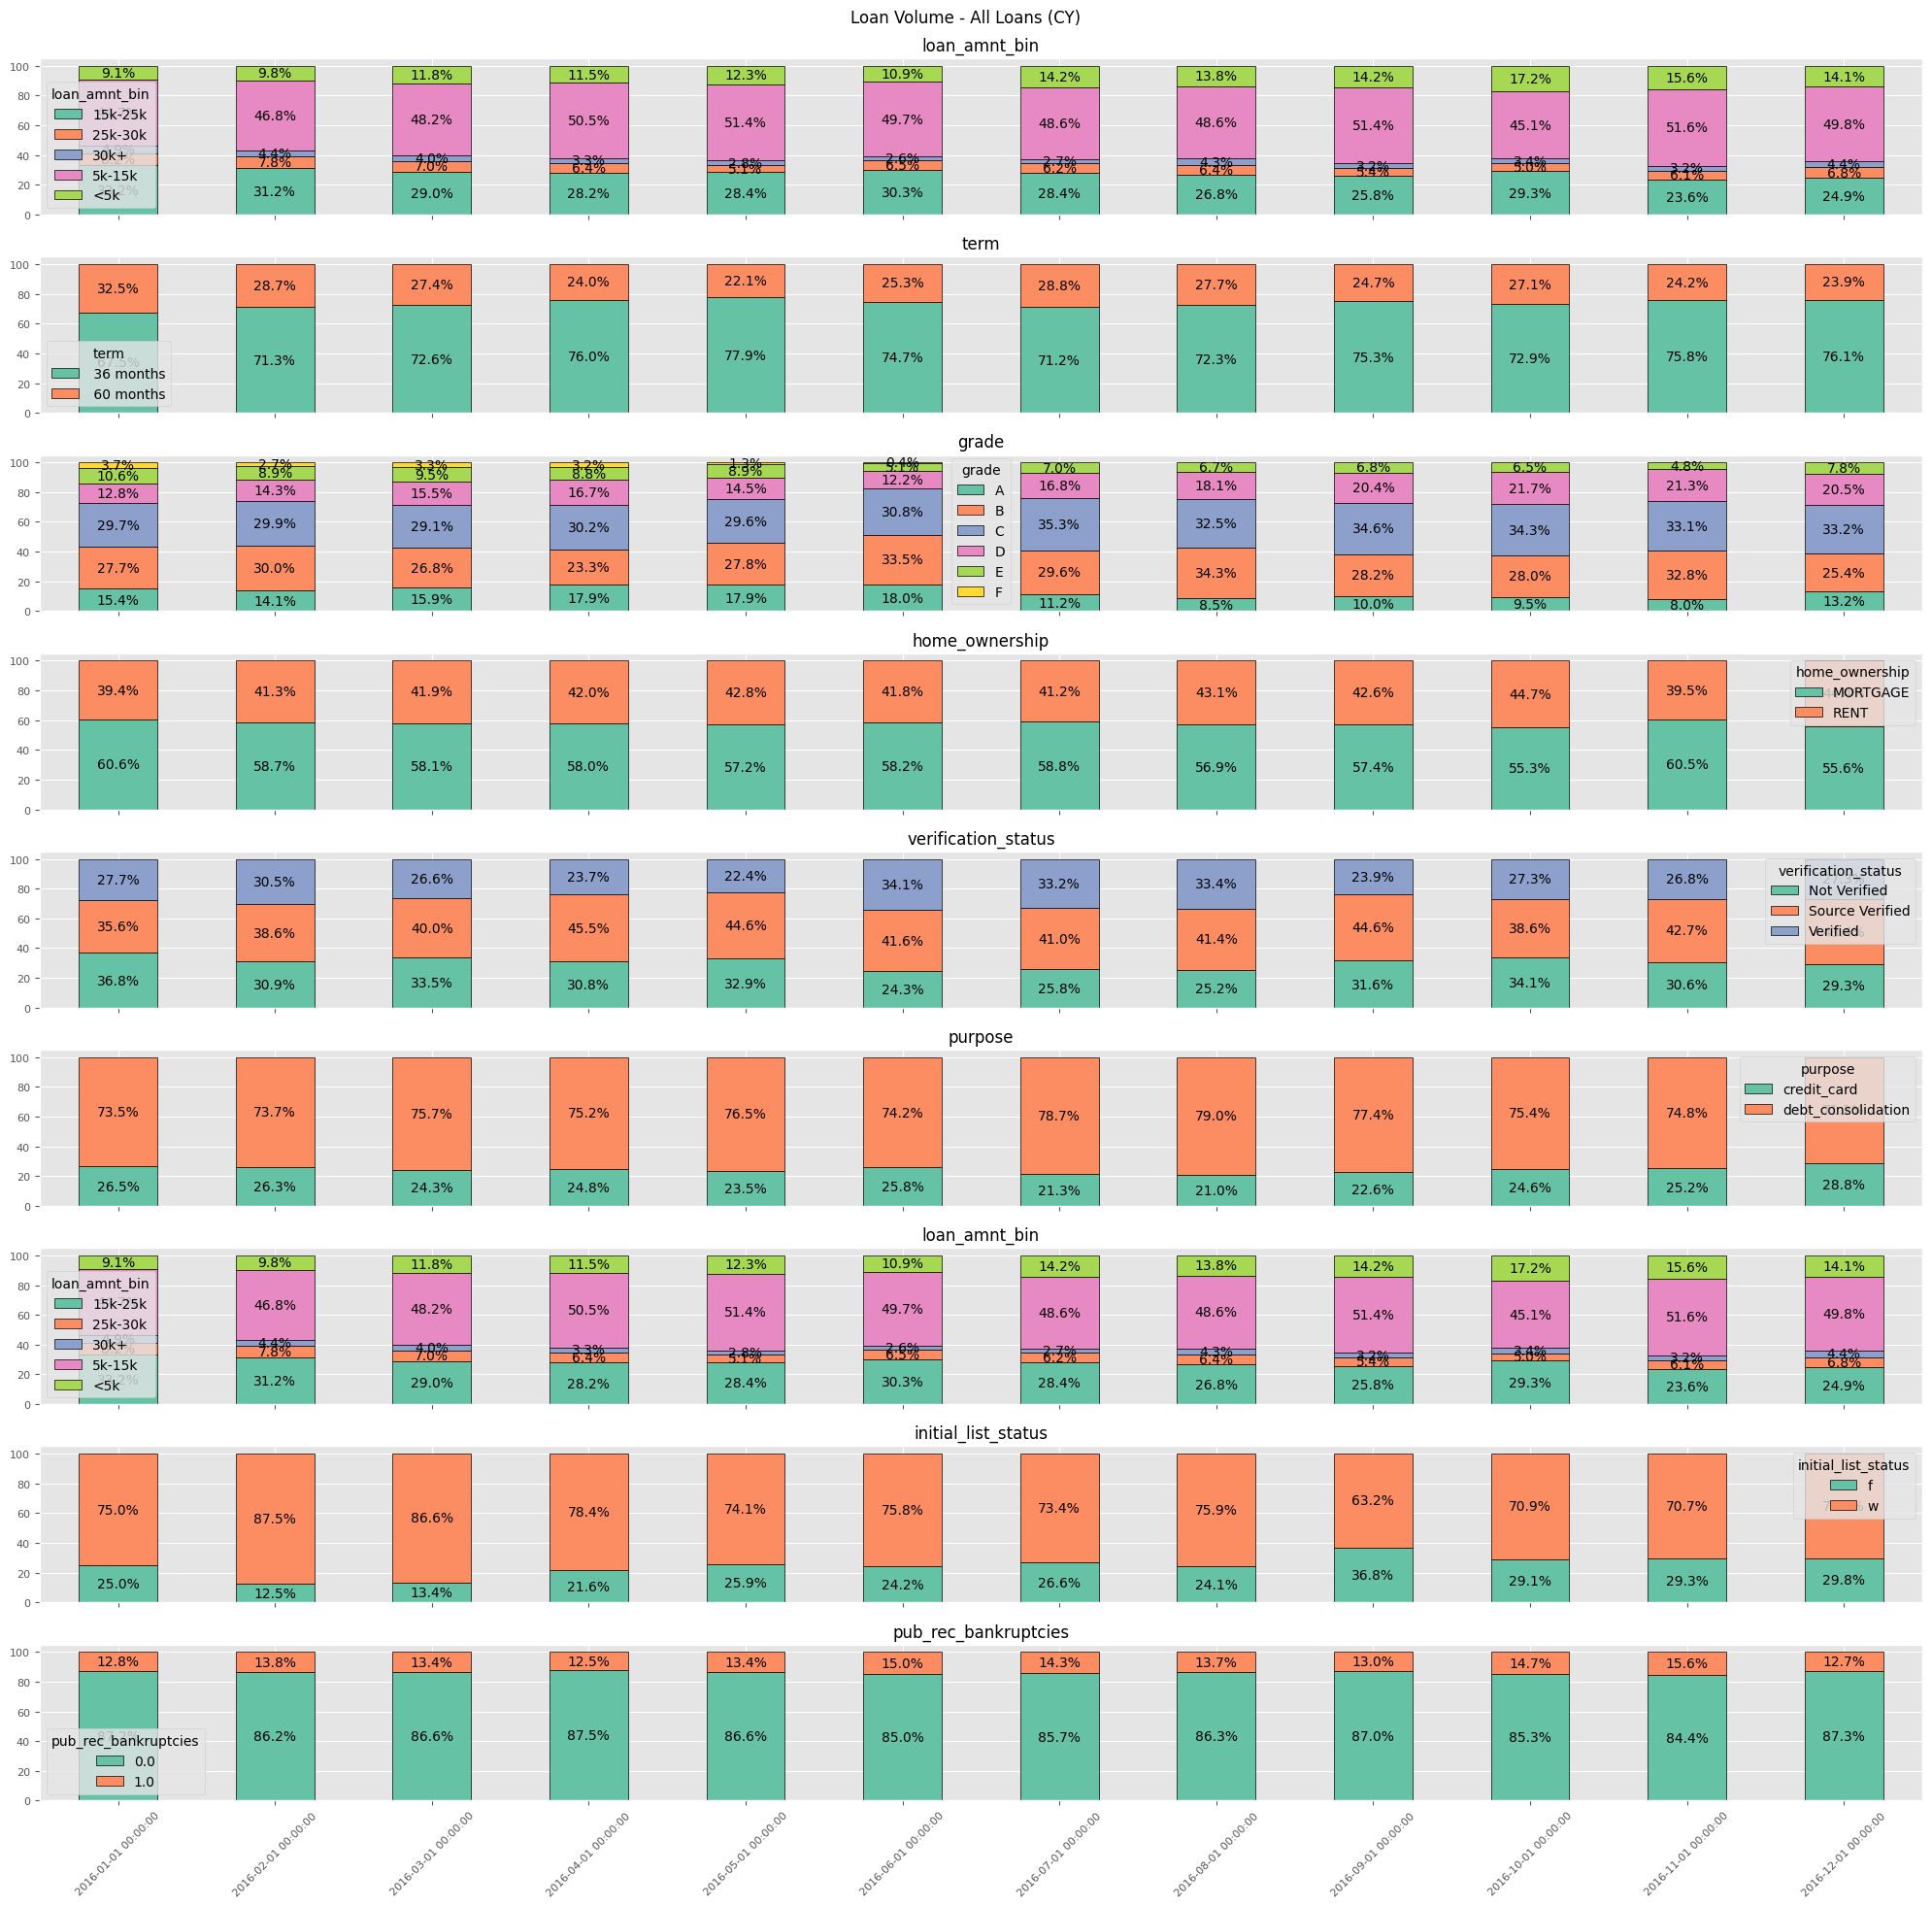

In [ ]:
#Loan Volume - All Loans (CY)
fig, ax = plt.subplots(len(object_features), 1, figsize=(20, 20), sharey=True, sharex=True, constrained_layout=True)
ax = ax.flatten()

# Plot Count bars with percentages as labels and hue for cols (stacked)
for i, col in tqdm(enumerate(object_features), total=len(object_features)):
    counts = treated_df[((treated_df['issue_d'].dt.year == 2016))].groupby(['issue_d', col]).size().unstack().fillna(0)
    create_stacked_bars(counts, perc_label=True)

# Show
for i in range(len(object_features), len(ax)):
    ax[i].axis('off')
plt.suptitle('Loan Volume - All Loans (CY)\n')
plt.tight_layout()
plt.show()

  0%|          | 0/9 [00:00<?, ?it/s]

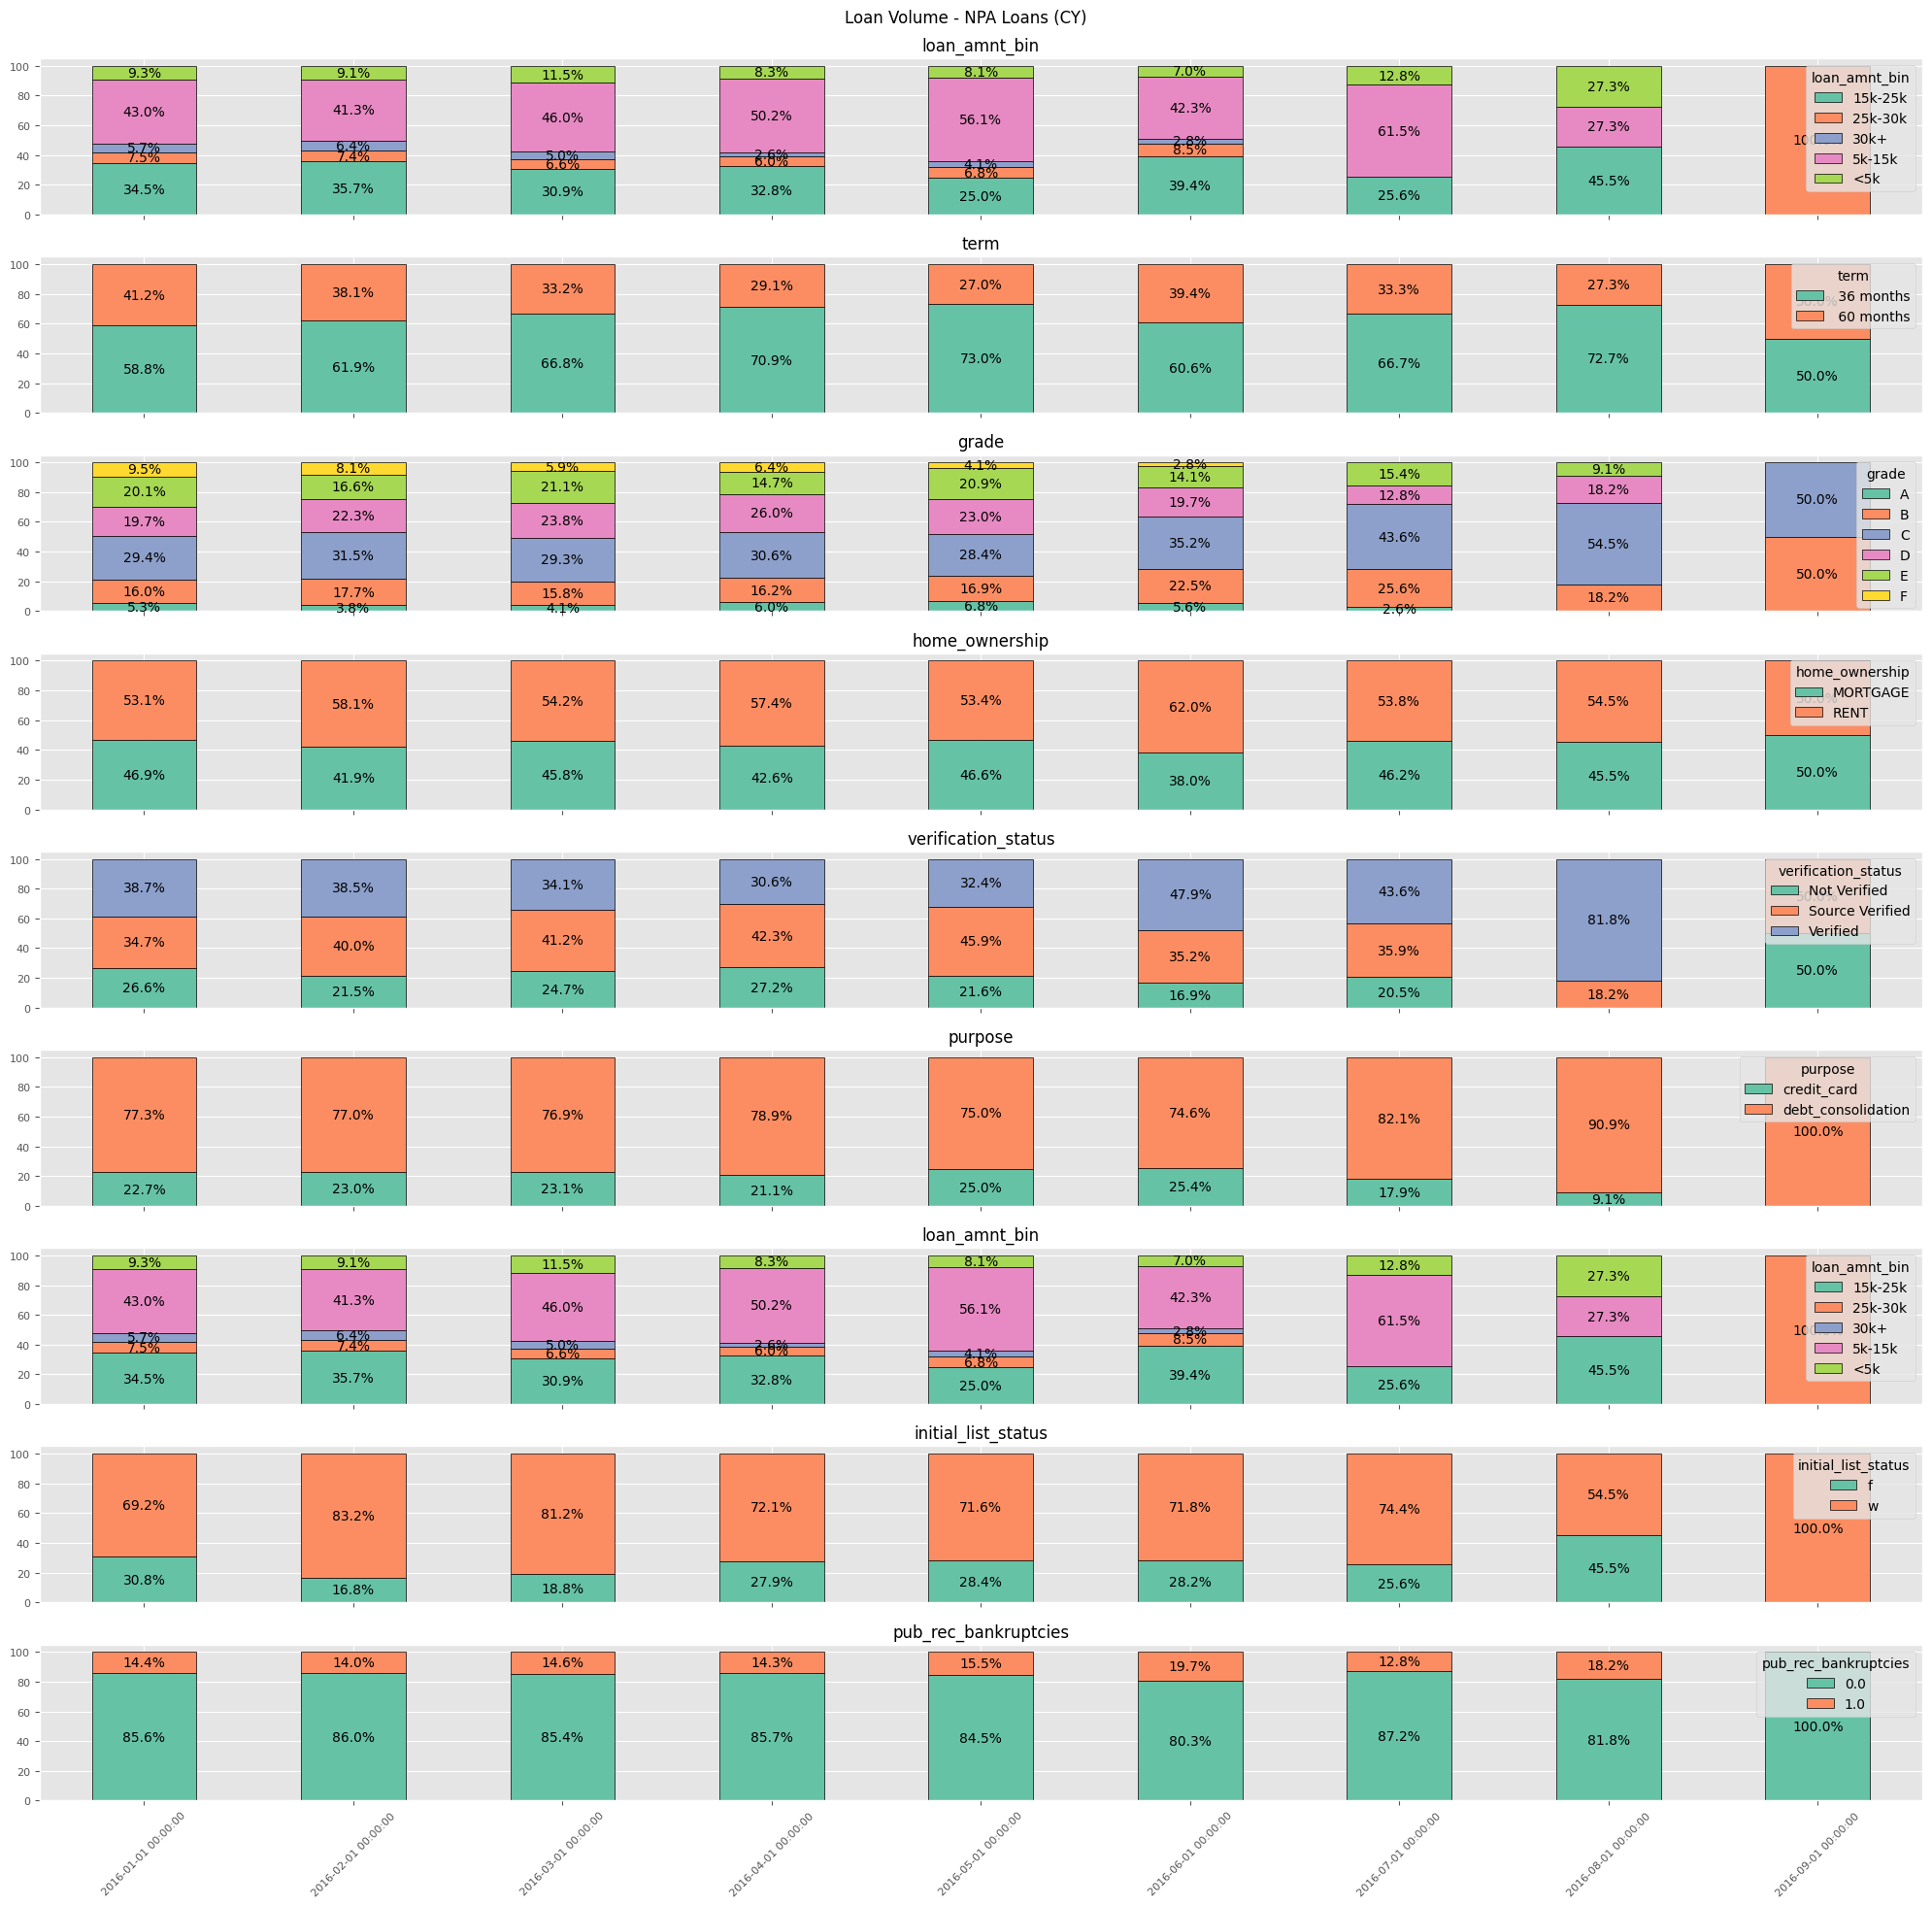

In [ ]:
# Loan Volume - NPA Loans (CY)
fig, ax = plt.subplots(len(object_features), 1, figsize=(20, 20), sharey=True, sharex=True, constrained_layout=True)
ax = ax.flatten()

# Plot Count bars with percentages as labels and hue for cols (stacked)
for i, col in tqdm(enumerate(object_features), total=len(object_features)):
    counts = treated_df[((treated_df['loan_status']==0) & (treated_df['issue_d'].dt.year == 2016))].groupby(['issue_d', col]).size().unstack().fillna(0)
    create_stacked_bars(counts, perc_label=True)

# Show
for i in range(len(object_features), len(ax)):
    ax[i].axis('off')
plt.suptitle('Loan Volume - NPA Loans (CY)\n')
plt.tight_layout()
plt.show()

- No NPA after Sep 2016
- The NPA trend for 30-month term loans has been on the rise over the last 3 months, despite a stagnant loan disbursal rate from this segment during the same period.
- Between May and September 2016, the `debt_consolidation` bucket accounted for 77.3% of the average loan volume, while contributing 80.4% of the NPAs during the same period, highlighting a higher NPA ratio in this category.
- NPA contribution from `Verifed` bucket is always higher than it's contribution in Overall Loan Volume. Shows some critical issues in loan verification process. Surprisingly in last month there is no NPAs from `Not verified` bucket.
- Customers with ongoing mortgages have higher chances to default on loan compared to those living off rent, suggesting that cx with mortgage-related loans may require more stringent risk management.
- NPAs from small loans (<5k) has increased tremendously in Last 3 months even tho the total loan disbursal during same period has remain somewhat stagnent

---
*1. Excluded Sep 2016 as it seems to be have some irregular fluctuation*

*2. Last x months refers to months before Sep 2024*




# Cx Credit Health Analysis

In [ ]:
# dti : A ratio calculated using the borrower’s total monthly debt payments on the total debt obligations, excluding mortgage
#         and the requested LoanTap loan, divided by the borrower’s self-reported monthly income.
# earliest_cr_line :The month the borrower's earliest reported credit line was opened
# open_acc : The number of open credit lines in the borrower's credit file.
# pub_rec : Number of derogatory public records
# revol_bal : Total credit revolving balance
# revol_util : Revolving line utilization rate, or the amount of credit the borrower is using relative to all available revolving credit.
# total_acc : The total number of credit lines currently in the borrower's credit file
# initial_list_status : The initial listing status of the loan. Possible values are W, F
# application_type : Indicates whether the loan is an individual application or a joint application with two co-borrowers
# mort_acc : Number of mortgage accounts.
# pub_rec_bankruptcies : Number of public record bankruptcies

#### Feature Engineering

In [ ]:
fe_df = treated_df.copy()

In [ ]:
fe_df['maturity date'] = pd.to_datetime(fe_df['issue_d'] + fe_df['term'].str.extract(r'(\d+)').astype(int)[0].apply(lambda x: pd.DateOffset(months=x)))
fe_df['cx_credit_maturity'] = (((fe_df['issue_d'] - fe_df['earliest_cr_line']).dt.days) / 30).astype('int')

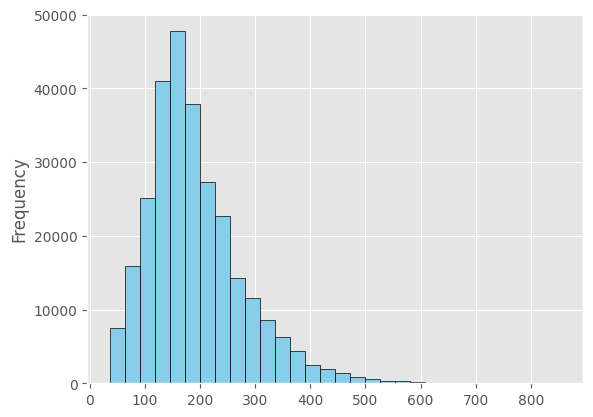

In [ ]:
fe_df['cx_credit_maturity'].plot(kind='hist', bins=30, edgecolor='black', color='skyblue');

Lower proportion of younger customers

In [ ]:
bins = [-1, 100, 200, 300, 400, float('inf')]
labels = ['<100', '100-200', '200-300', '300-400', '400+']
fe_df['cx_credit_maturity_bin'] = pd.cut(fe_df['cx_credit_maturity'], bins=bins, labels=labels, include_lowest=True).astype('object')

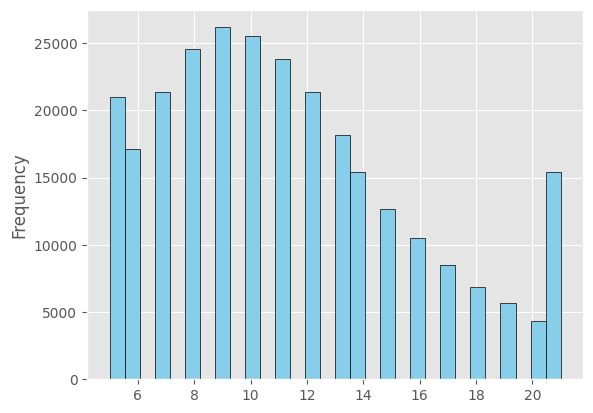

In [ ]:
fe_df['open_acc'].plot(kind='hist', bins=30, edgecolor='black', color='skyblue');

We have a well-balanced distribution of customers based on the number of open credit lines in their credit files. However, it's worth noting that 51% of customers have a high number of open credit lines, which could indicate a potential risk.

In [ ]:
# x = fe_df[['open_acc', 'loan_amnt']].head()
# x.iloc[0,0] = 0
# x.iloc[3,0] = 10
# x.iloc[4,0] = -1
# x.head()

In [ ]:
bins = [-1, 0, 5, 10, float('inf')]
labels = ['0', '0-5', '5-10', '10+']
fe_df['open_acc_bin'] = pd.cut(fe_df['open_acc'], bins=bins, labels=labels, include_lowest=True).astype('object')

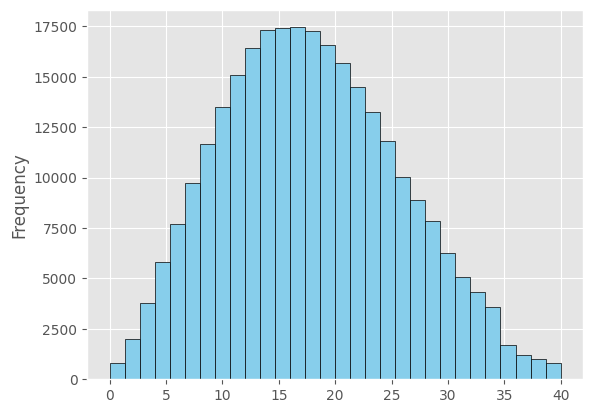

In [ ]:
fe_df['dti'].plot(kind='hist', bins=30, edgecolor='black', color='skyblue');

The `DTI` column follows a normal distribution with a range of 0 to 40, indicating a balanced debt-to-income ratio among customers. While most have manageable debt, attention should be given to those at the higher end of the range, as they may represent increased risk.

In [ ]:
bins = [0, 10, 20, 30, 40, 50, float('inf')]
labels = ['very low DTI', 'low DTI', 'moderate DTI', 'high DTI', 'very high DTI', 'extremely high DTI']
fe_df['dti_risk'] = pd.cut(fe_df['dti'], bins=bins, labels=labels, right=False).astype('object')

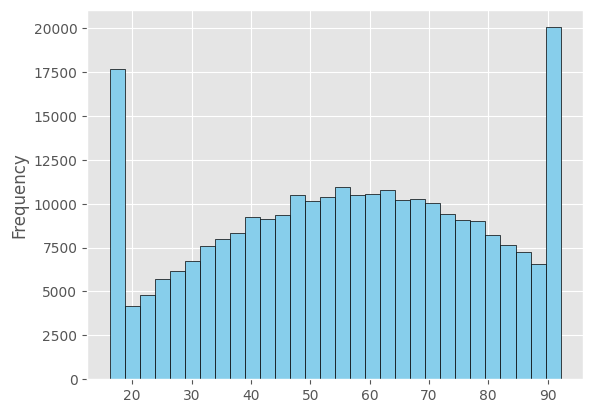

In [ ]:
fe_df['revol_util'].plot(kind='hist', bins=30, edgecolor='black', color='skyblue');

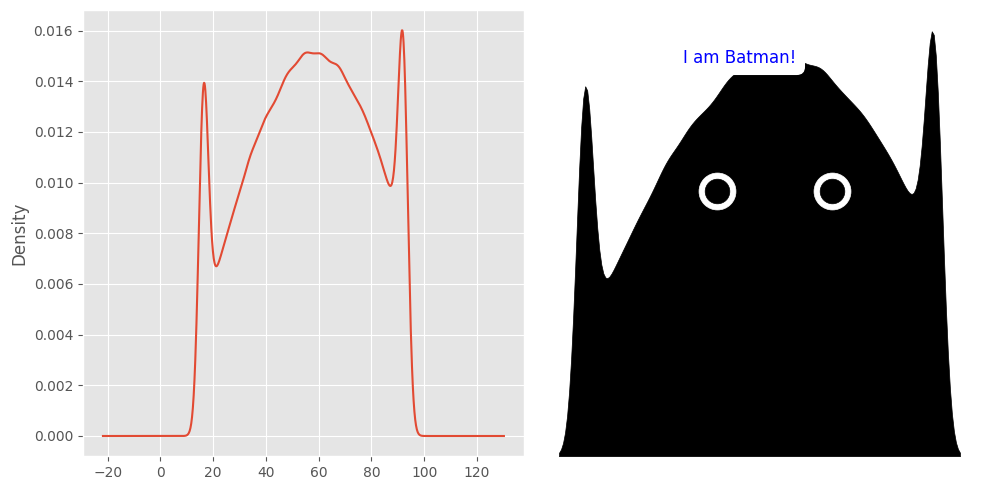

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

# Plot the KDE of 'revol_util'
fe_df['revol_util'].plot(kind='kde', ax=axs[0])
#------------------------------------------------------------------------------------------------------------Just For Funnn!!
# Plot the KDE of 'revol_util' with eyes 0-0
sns.kdeplot(fe_df['revol_util'], fill=True, color='black', alpha=1.0)
axs[1] = plt.gca()
# Plot the eyes as scatter points
circle1 = plt.scatter(45, 0.01, s=np.pi * (0.15 * 100)**2, color='white')  # Left eye
circle2 = plt.scatter(70, 0.01, s=np.pi * (0.15 * 100)**2, color='white')  # Right eye
circle3 = plt.scatter(45, 0.01, s=np.pi * (0.1 * 100)**2, color='black')  # Left eye
circle4 = plt.scatter(70, 0.01, s=np.pi * (0.1 * 100)**2, color='black')  # Right eye
# Adjust the plot limits to ensure everything is visible
x_min, x_max = axs[1].get_xlim()
y_min, y_max = axs[1].get_ylim()
axs[1].set_xlim(x_min, x_max)
axs[1].set_ylim(y_min, y_max)
# Set equal aspect ratio to keep circles round
axs[1].set_aspect('auto', adjustable='box')
axs[1].axis('off')
# Add I am batman
link_text = "I am Batman!"
link_url = "https://www.youtube.com/shorts/i8ZzWLbwr3g"
link_annotation = axs[1].text(50, 0.015, link_text, fontsize=12, color='blue', ha='center', va='center',
            bbox=dict(facecolor='white', edgecolor='none', boxstyle='round,pad=0.5'))

# Display the plot
plt.tight_layout()
plt.show()

- The distribution of `revol_util` appears nearly normal, with some extreme values at the tail, likely resulting from capping during outlier treatment.
- The peak around 50 indicates moderate revolving credit utilization among the observed population."

In [ ]:
bins = [0, 25, 50, 75, float('inf')]
labels = ['0%', '25%', '50%', '75%+']
fe_df['revol_util_bins'] = pd.cut(fe_df['revol_util'], bins=bins, labels=labels, right=False).astype('object')

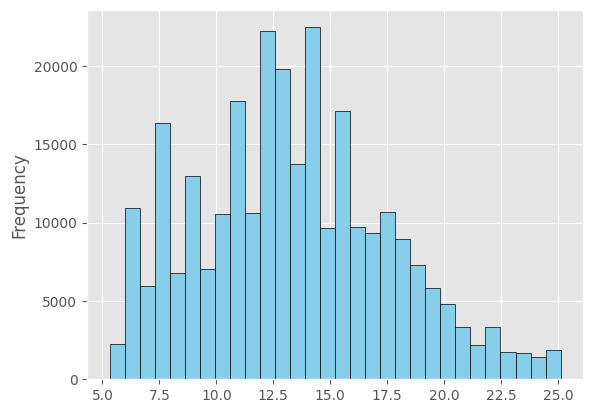

In [ ]:
fe_df['int_rate'].plot(kind='hist', bins=30, edgecolor='black', color='skyblue');

The data exhibits a slight left skew, indicating that a greater number of customers are associated with lower interest rates.

In [ ]:
bins = [5, 7.5, 10, 12.5, 15, 17.5, 20, float('inf')]
labels = ['Very Low (5-7.5%)', 'Low (7.5-10%)', 'Moderate (10-12.5%)', 'High (12.5-15%)', 'Very High (15-17.5%)', 'Extremely High (17.5-20%)', 'Ultra High (20%+)']
fe_df['int_rate_bins'] = pd.cut(fe_df['int_rate'], bins=bins, labels=labels, right=False).astype('object')

In [ ]:
fe_df.columns

Index(['loan_amnt', 'term', 'int_rate', 'installment', 'grade', 'sub_grade',
       'emp_title', 'emp_length', 'home_ownership', 'annual_inc',
       'verification_status', 'issue_d', 'loan_status', 'purpose', 'title',
       'dti', 'earliest_cr_line', 'open_acc', 'pub_rec', 'revol_bal',
       'revol_util', 'total_acc', 'initial_list_status', 'mort_acc',
       'pub_rec_bankruptcies', 'pincode', 'loan_term', 'loan_amnt_bin',
       'maturity date', 'cx_credit_maturity', 'cx_credit_maturity_bin',
       'open_acc_bin', 'dti_risk', 'revol_util_bins', 'int_rate_bins'],
      dtype='object')

In [ ]:
# Saving Imputed DF
fe_df.to_csv(f"{data_folder}/LoanTapData_feature_eng.csv", index=False)

In [ ]:
# Load Imputed DF
fe_df = pd.read_csv(f"{data_folder}/LoanTapData_feature_eng.csv", parse_dates=['issue_d', 'earliest_cr_line'])
fe_df.head()

loan_amnt        term  int_rate  installment grade sub_grade  \
0     8000.0   36 months     11.99   265.676271     B        B5   
1    15600.0   36 months     10.49   506.964563     B        B3   
2     7200.0   36 months      6.49   220.640051     A        A2   
3    24375.0   60 months     17.27   609.325862     C        C5   
4    20000.0   36 months     13.33   677.062405     C        C3   

                 emp_title emp_length home_ownership  annual_inc  \
0          Credit analyst     4 years       MORTGAGE     65000.0   
1             Statistician   < 1 year           RENT     43057.0   
2          Client Advocate    6 years           RENT     54000.0   
3  Destiny Management Inc.    9 years       MORTGAGE     55000.0   
4            HR Specialist  10+ years       MORTGAGE     86788.0   

  verification_status    issue_d  loan_status             purpose  \
0        Not Verified 2015-01-01            1  debt_consolidation   
1     Source Verified 2015-01-01            1         credit_card   
2        Not Verified 2014-11-01            1         credit_card   
3            Verified 2013-04-01            0         credit_card   
4            Verified 2015-09-01            1  debt_consolidation   

                     title    dti earliest_cr_line  open_acc  pub_rec  \
0       Debt consolidation  22.05       2004-07-01      17.0      0.0   
1  Credit card refinancing  12.79       2007-08-01      13.0      0.0   
2  Credit card refinancing   2.60       2006-09-01       6.0      0.0   
3    Credit Card Refinance  33.95       1999-03-01      13.0      0.0   
4       Debt consolidation  16.31       2005-01-01       8.0      0.0   

   revol_bal  revol_util  total_acc initial_list_status  mort_acc  \
0    20131.0        53.3       27.0                   f       3.0   
1    11987.0        92.2       26.0                   f       0.0   
2     5472.0        21.5       13.0                   f       0.0   
3    24584.0        69.8       43.0                   f       1.0   
4    25757.0        92.2       23.0                   f       4.0   

   pub_rec_bankruptcies  pincode  loan_term loan_amnt_bin maturity date  \
0                   0.0     5113         36        5k-15k    2018-01-01   
1                   0.0     5113         36       15k-25k    2018-01-01   
2                   0.0      813         36        5k-15k    2017-11-01   
3                   0.0    11650         60       15k-25k    2018-04-01   
4                   0.0    30723         36       15k-25k    2018-09-01   

   cx_credit_maturity cx_credit_maturity_bin open_acc_bin      dti_risk  \
0                 127                100-200          10+  moderate DTI   
1                  90                   <100          10+       low DTI   
2                  99                   <100         5-10  very low DTI   
3                 171                100-200          10+      high DTI   
4                 129                100-200         5-10       low DTI   

  revol_util_bins         int_rate_bins  
0             50%   Moderate (10-12.5%)  
1            75%+   Moderate (10-12.5%)  
2              0%     Very Low (5-7.5%)  
3             50%  Very High (15-17.5%)  
4            75%+       High (12.5-15%)

In [ ]:
# dti : A ratio calculated using the borrower’s total monthly debt payments on the total debt obligations, excluding mortgage
#         and the requested LoanTap loan, divided by the borrower’s self-reported monthly income.
# earliest_cr_line :The month the borrower's earliest reported credit line was opened
# open_acc : The number of open credit lines in the borrower's credit file.
# pub_rec : Number of derogatory public records
# revol_bal : Total credit revolving balance
# revol_util : Revolving line utilization rate, or the amount of credit the borrower is using relative to all available revolving credit.
# total_acc : The total number of credit lines currently in the borrower's credit file
# initial_list_status : The initial listing status of the loan. Possible values are W, F
# application_type : Indicates whether the loan is an individual application or a joint application with two co-borrowers
# mort_acc : Number of mortgage accounts.
# pub_rec_bankruptcies : Number of public record bankruptcies

In [ ]:
continuous_df = fe_df.select_dtypes(exclude=['object', 'datetime']).drop(['loan_status'], axis=1)
sns.pairplot(continuous_df, diag_kind='kde', corner=True);

Output hidden; open in https://colab.research.google.com to view.

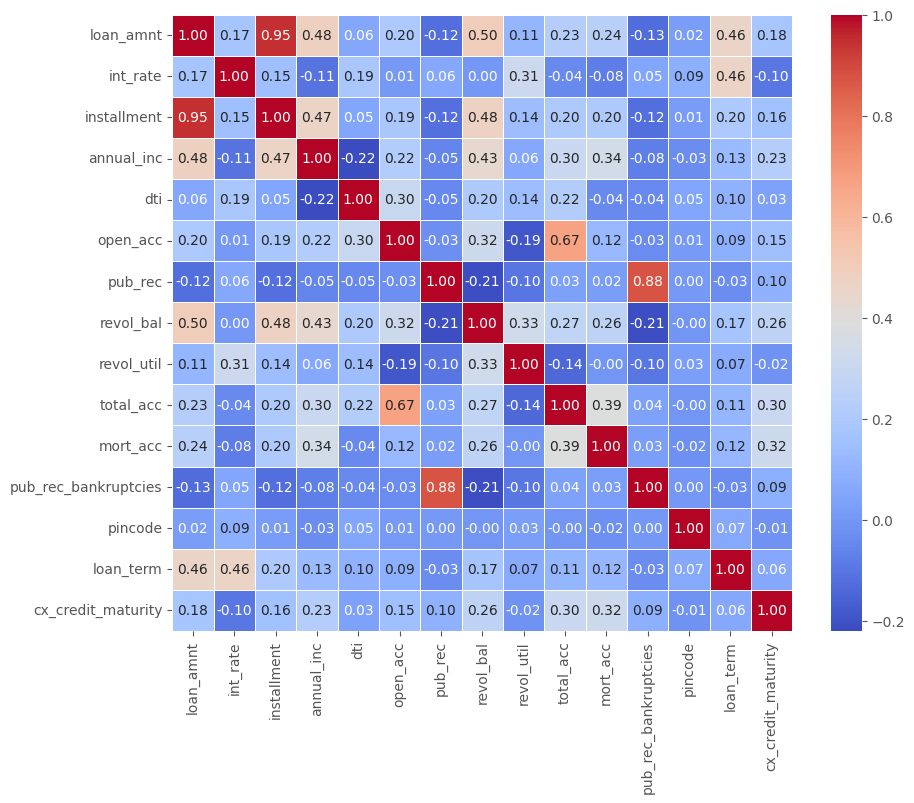

In [ ]:
continuous_df = fe_df.select_dtypes(exclude=['object', 'datetime']).drop(['loan_status'], axis=1)
plt.figure(figsize=(10, 8))
sns.heatmap(continuous_df.corr(), annot=True, cmap='coolwarm', fmt='.2f', cbar=True, linewidths=0.5);

- The distribution of loan amounts shows a multimodal pattern with a slight left skew, indicating specific loan bucketing and a higher concentration of smaller loans being disbursed.
- There is no significant direct correlation between interest rates and loan amounts.
- Loan amount and installment are strongly correlated, exhibiting a clear linear relationship, while loan amount does not show strong correlation with other variables.
- Annual income is left-skewed, with most customers in the lower income brackets, while the extreme values at the upper end represent a small group of higher-income customers.
- The majority of customers have no public records.
- loan term is moderately positively correlated with loan amount and interest rate, even tho loan amount and interest rate are not directly correlated.

In [ ]:
fe_df.select_dtypes(include='object').columns

Index(['term', 'grade', 'sub_grade', 'emp_title', 'emp_length',
       'home_ownership', 'verification_status', 'purpose', 'title',
       'initial_list_status', 'loan_amnt_bin', 'maturity date',
       'cx_credit_maturity_bin', 'open_acc_bin', 'dti_risk', 'revol_util_bins',
       'int_rate_bins'],
      dtype='object')

In [ ]:
# dti : A ratio calculated using the borrower’s total monthly debt payments on the total debt obligations, excluding mortgage
#         and the requested LoanTap loan, divided by the borrower’s self-reported monthly income.
# earliest_cr_line :The month the borrower's earliest reported credit line was opened
# open_acc : The number of open credit lines in the borrower's credit file.
# pub_rec : Number of derogatory public records
# revol_bal : Total credit revolving balance
# revol_util : Revolving line utilization rate, or the amount of credit the borrower is using relative to all available revolving credit.
# total_acc : The total number of credit lines currently in the borrower's credit file
# initial_list_status : The initial listing status of the loan. Possible values are W, F
# application_type : Indicates whether the loan is an individual application or a joint application with two co-borrowers
# mort_acc : Number of mortgage accounts.
# pub_rec_bankruptcies : Number of public record bankruptcies

In [ ]:
object_features = ['cx_credit_maturity_bin', 'open_acc_bin', 'dti_risk', 'revol_util_bins', 'int_rate_bins']

  0%|          | 0/5 [00:00<?, ?it/s]

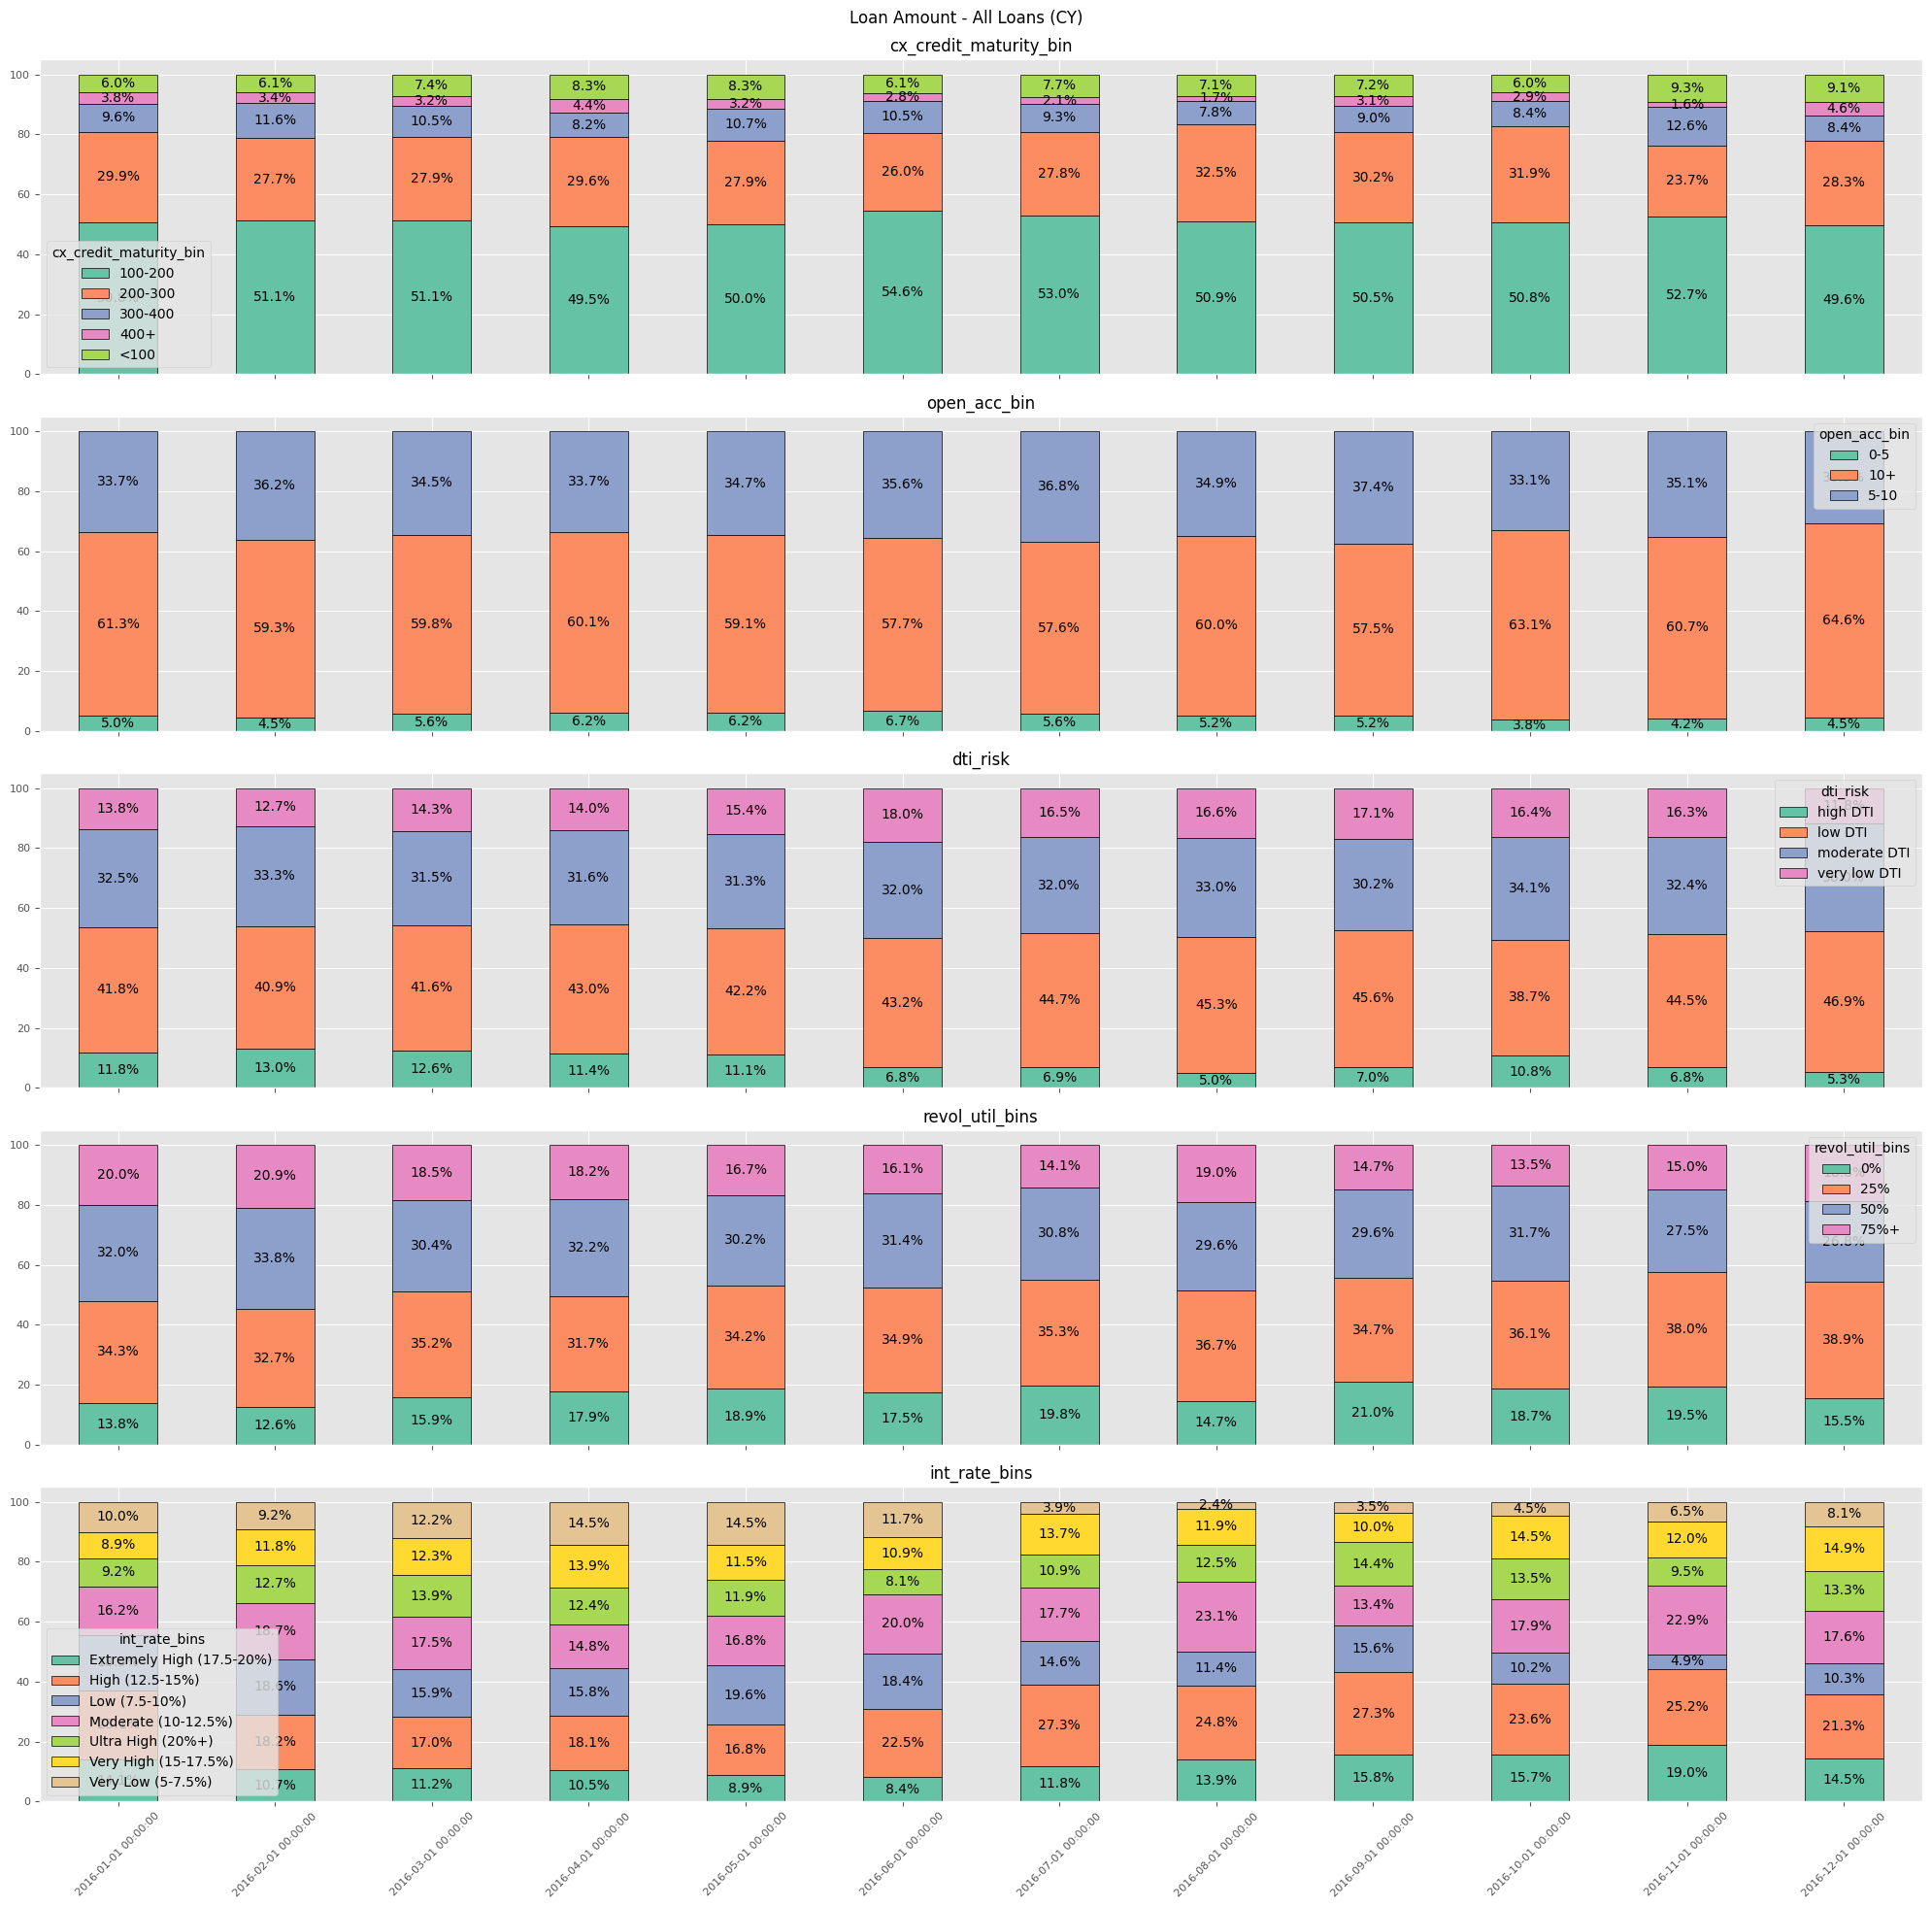

In [ ]:
#Loan Amount - All Loans (CY)
fig, ax = plt.subplots(len(object_features), 1, figsize=(20, 20), sharey=True, sharex=True, constrained_layout=True)
ax = ax.flatten()

# Plot Count bars with percentages as labels and hue for cols (stacked)
for i, col in tqdm(enumerate(object_features), total=len(object_features)):
    counts = fe_df[((fe_df['issue_d'].dt.year == 2016))].groupby(['issue_d', col])['loan_amnt'].sum().unstack().fillna(0)
    create_stacked_bars(counts, perc_label=True)

# Show
for i in range(len(object_features), len(ax)):
    ax[i].axis('off')
plt.suptitle('Loan Amount - All Loans (CY)\n')
plt.tight_layout()
plt.show()

  0%|          | 0/5 [00:00<?, ?it/s]

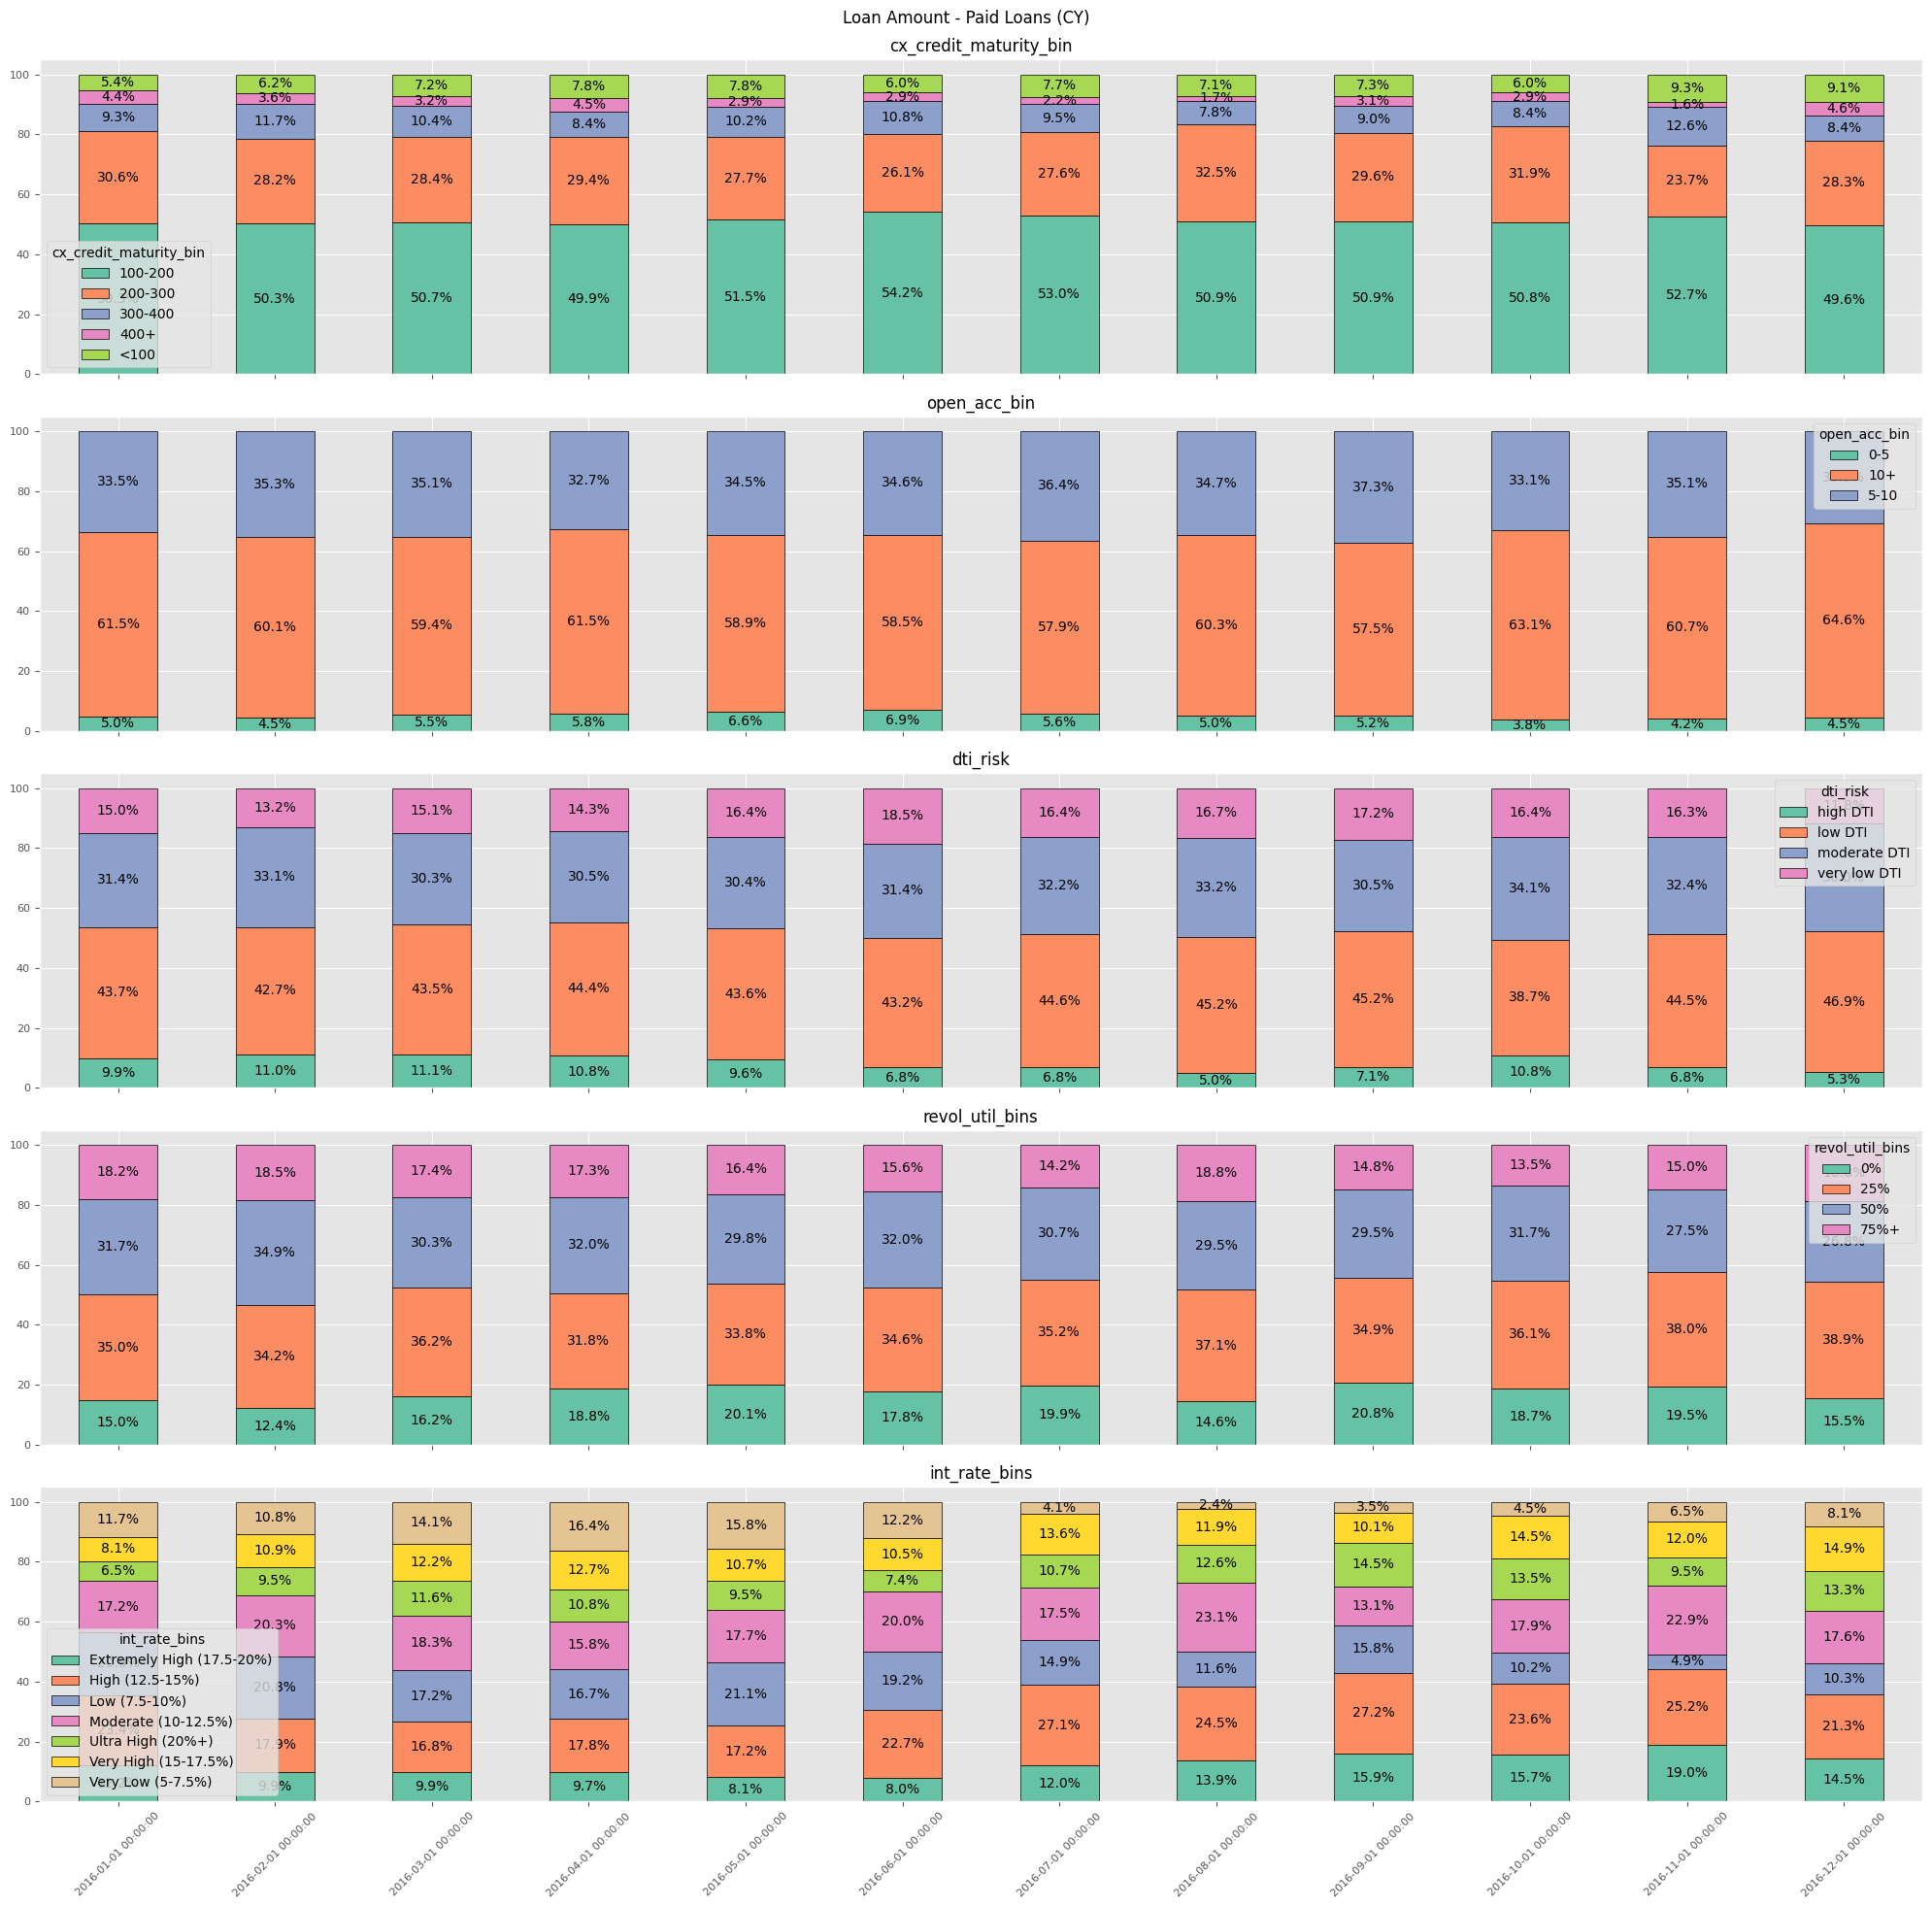

In [ ]:
#Loan Amount - Paid Loans (CY)
fig, ax = plt.subplots(len(object_features), 1, figsize=(20, 20), sharey=True, sharex=True, constrained_layout=True)
ax = ax.flatten()

# Plot Count bars with percentages as labels and hue for cols (stacked)
for i, col in tqdm(enumerate(object_features), total=len(object_features)):
    counts = fe_df[((fe_df['loan_status']==1) & (fe_df['issue_d'].dt.year == 2016))].groupby(['issue_d', col])['loan_amnt'].sum().unstack().fillna(0)
    create_stacked_bars(counts, perc_label=True)

# Show
for i in range(len(object_features), len(ax)):
    ax[i].axis('off')
plt.suptitle('Loan Amount - Paid Loans (CY)\n')
plt.tight_layout()
plt.show()

  0%|          | 0/5 [00:00<?, ?it/s]

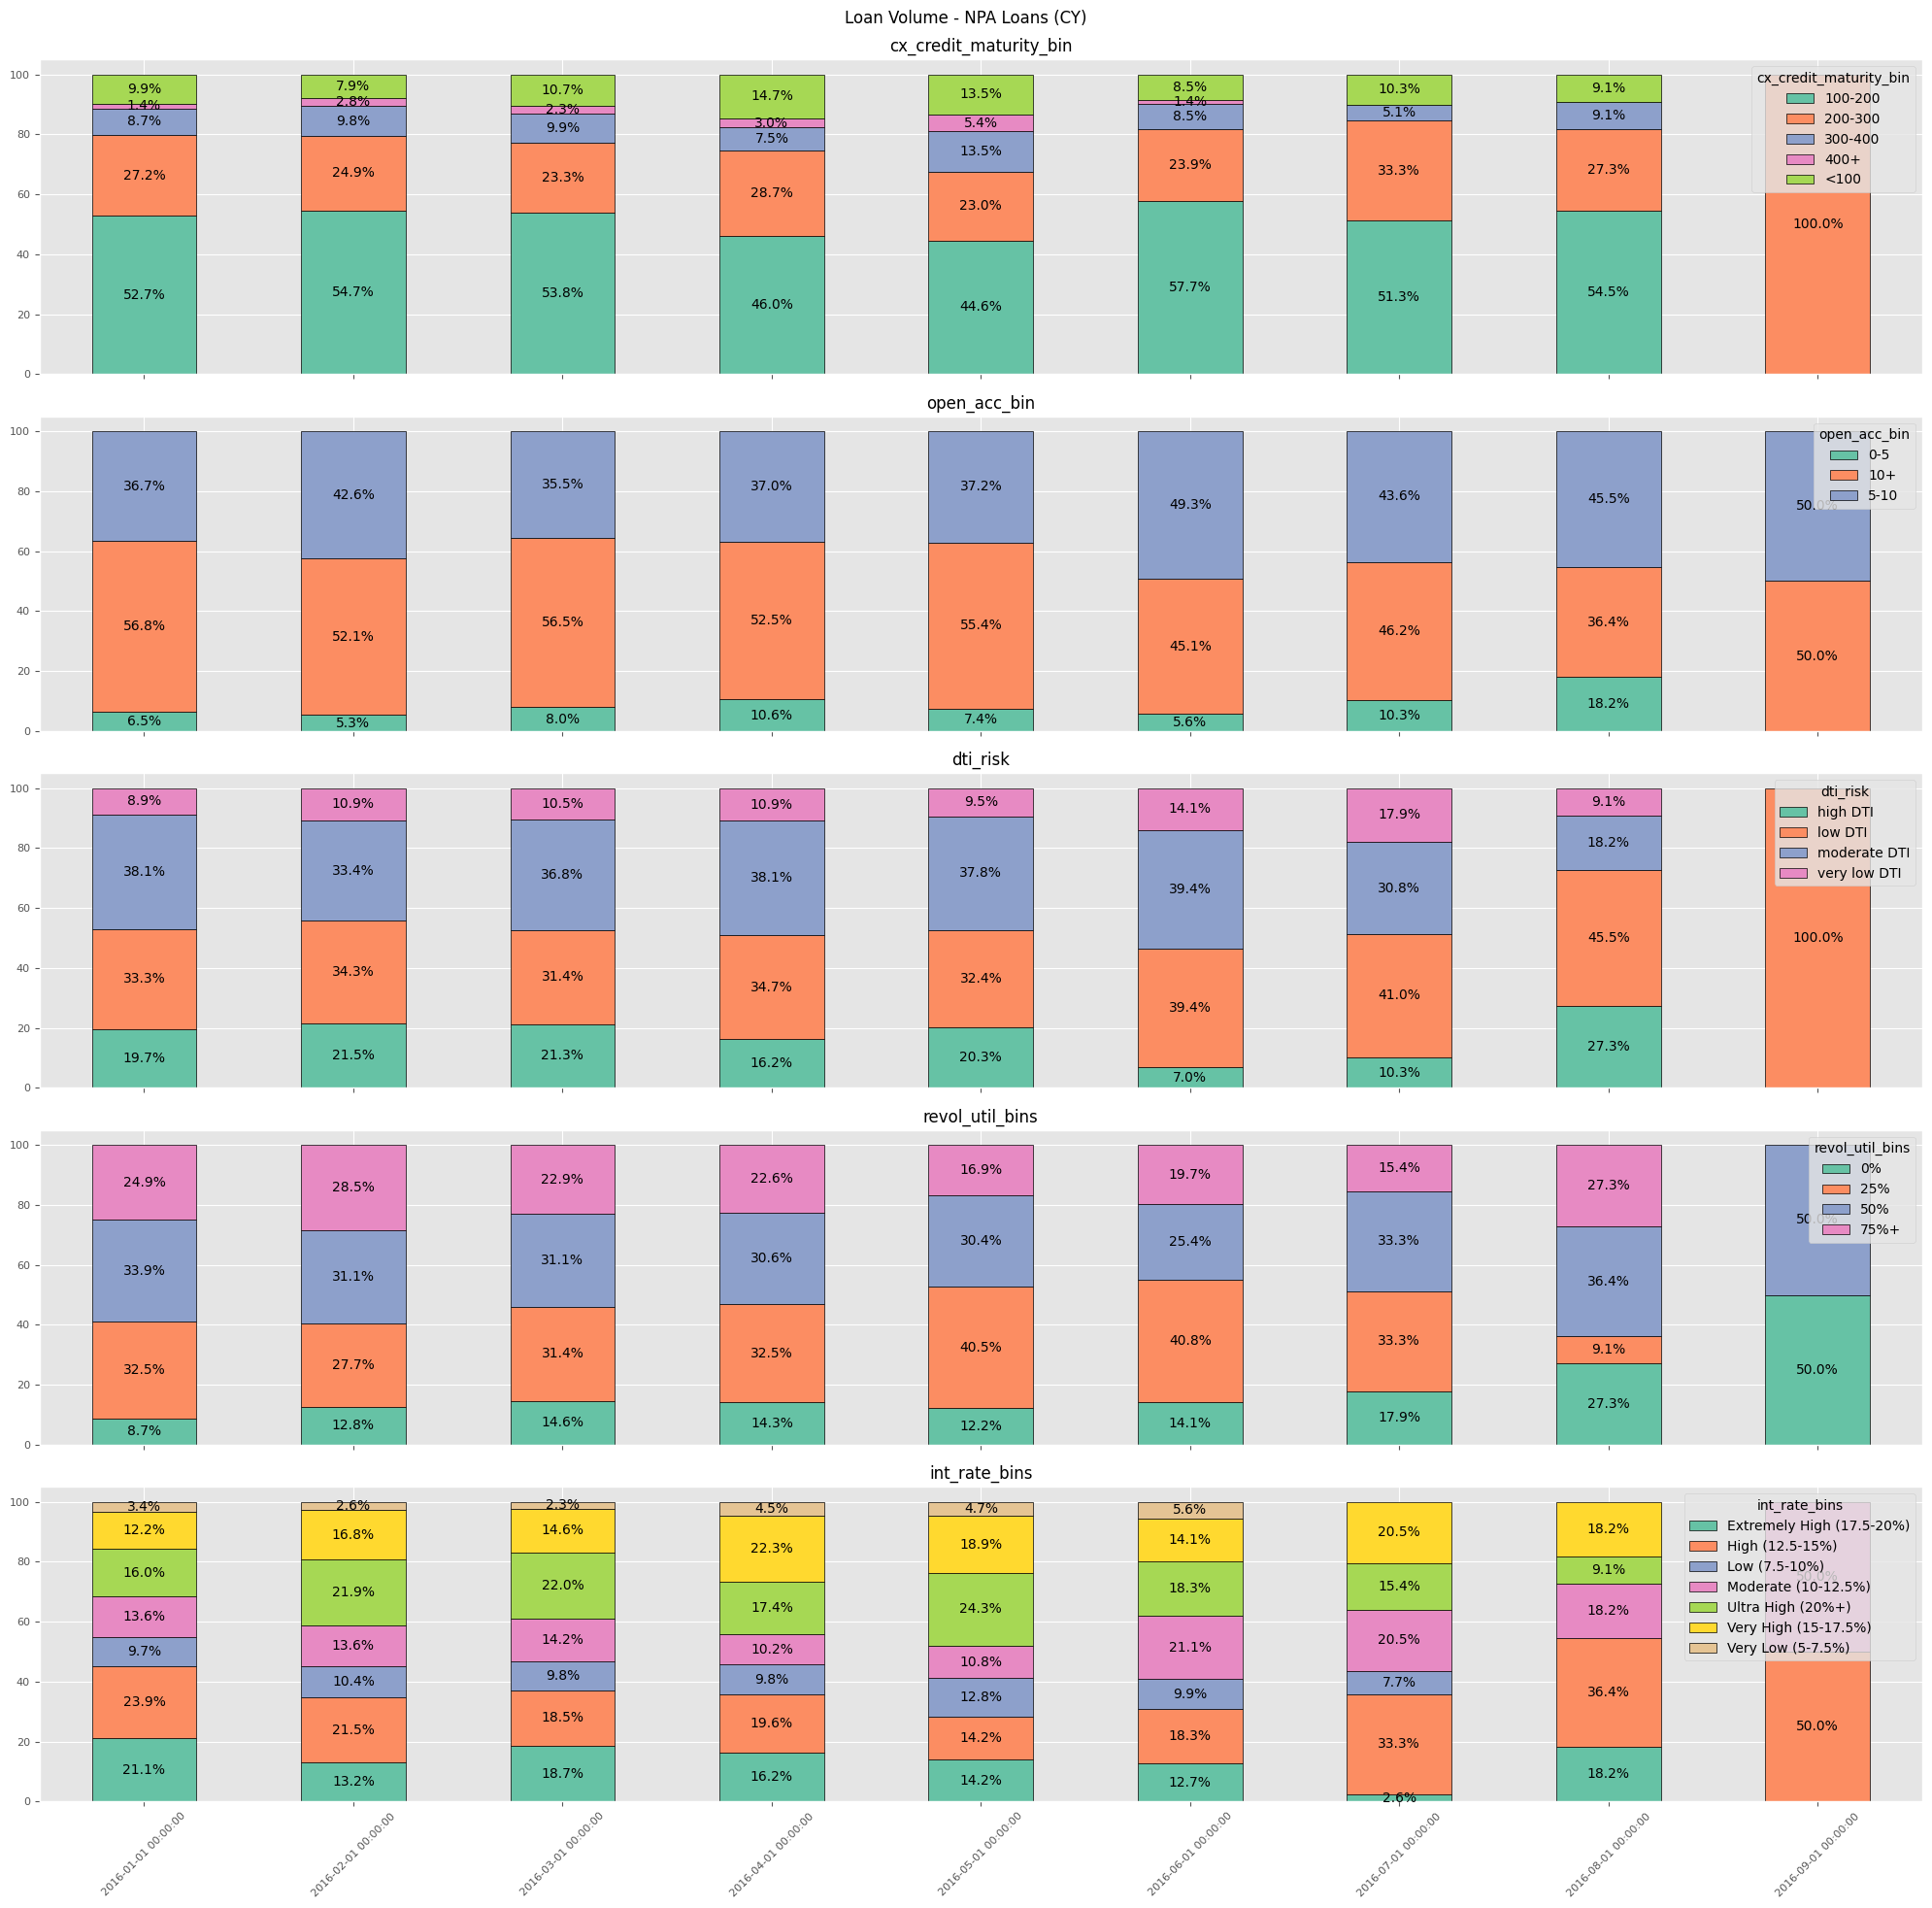

In [ ]:
# Loan Volume - NPA Loans (CY)
fig, ax = plt.subplots(len(object_features), 1, figsize=(20, 20), sharey=True, sharex=True, constrained_layout=True)
ax = ax.flatten()

# Plot Count bars with percentages as labels and hue for cols (stacked)
for i, col in tqdm(enumerate(object_features), total=len(object_features)):
    counts = fe_df[((fe_df['loan_status']==0) & (fe_df['issue_d'].dt.year == 2016))].groupby(['issue_d', col]).size().unstack().fillna(0)
    create_stacked_bars(counts, perc_label=True)

# Show
for i in range(len(object_features), len(ax)):
    ax[i].axis('off')
plt.suptitle('Loan Volume - NPA Loans (CY)\n')
plt.tight_layout()
plt.show()

- Loan disbursal to young customer (<100 months credit maturity) is expanded in last 2 months, tho mid seniority contribution is stagnant and highest at around 50% of total loan disbursal
- High loan disbursal to customer with high number of open credit lines.
- In the last 3 months we have increased our loan sanction to Low-moderate DTI risk bucket, reduced from customers with high DTI and very low DTI
- Increase disbursal to customer with high Revolving line utilization rate from 13.5% to 16.6%, a jump of 300 basis points.

<br>

- During Mar-July 2016 the contribution of Extremely high interest rate has dropped by 200 basis points but NPAs during the same period dropped by 1500 basis points.
- During the same period, 'very low' interest-rate bucket volume plummeted significantly, a shift can be seen in 'moderate' interest-rate bucket

  0%|          | 0/2 [00:00<?, ?it/s]

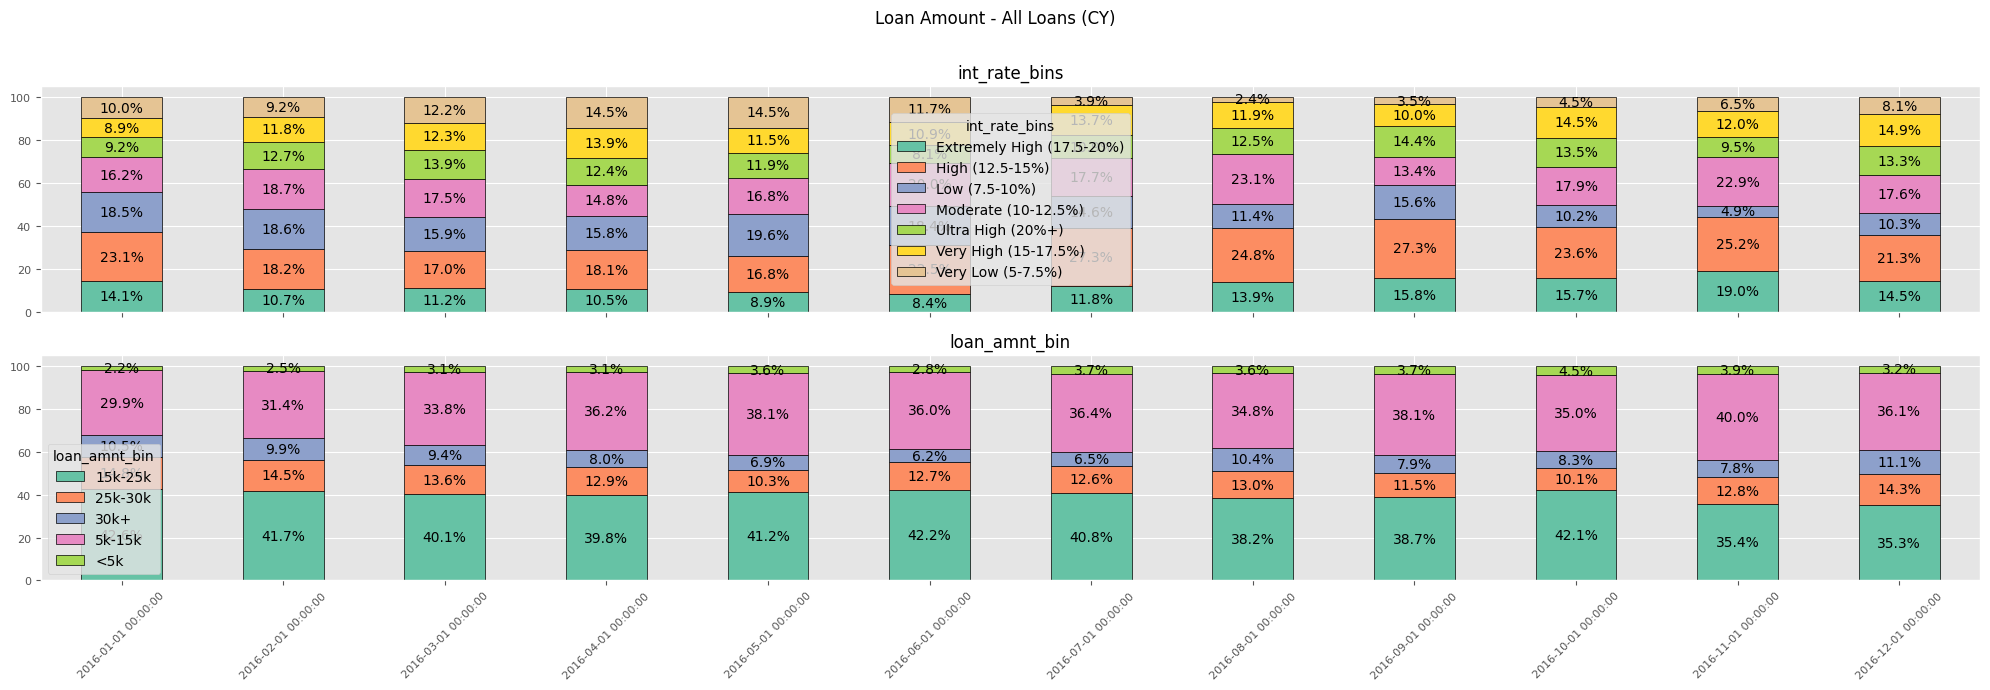

In [ ]:
#Loan Amount - All Loans (CY)
object_features = ['int_rate_bins', 'loan_amnt_bin']
fig, ax = plt.subplots(len(object_features), 1, figsize=(20, 7), sharey=True, sharex=True, constrained_layout=True)
ax = ax.flatten()

# Plot Count bars with percentages as labels and hue for cols (stacked)
for i, col in tqdm(enumerate(object_features), total=len(object_features)):
    counts = fe_df[((fe_df['issue_d'].dt.year == 2016))].groupby(['issue_d', col])['loan_amnt'].sum().unstack().fillna(0)
    create_stacked_bars(counts, perc_label=True)

# Show
for i in range(len(object_features), len(ax)):
    ax[i].axis('off')
plt.suptitle('Loan Amount - All Loans (CY)\n')
plt.tight_layout()
plt.show()

- High interest rate bucket contribution has increased
- The loan disbursement to the sub-5k bucket was reduced by 300 basis points, while the disbursement to larger loans increased by approximately 400 basis points.


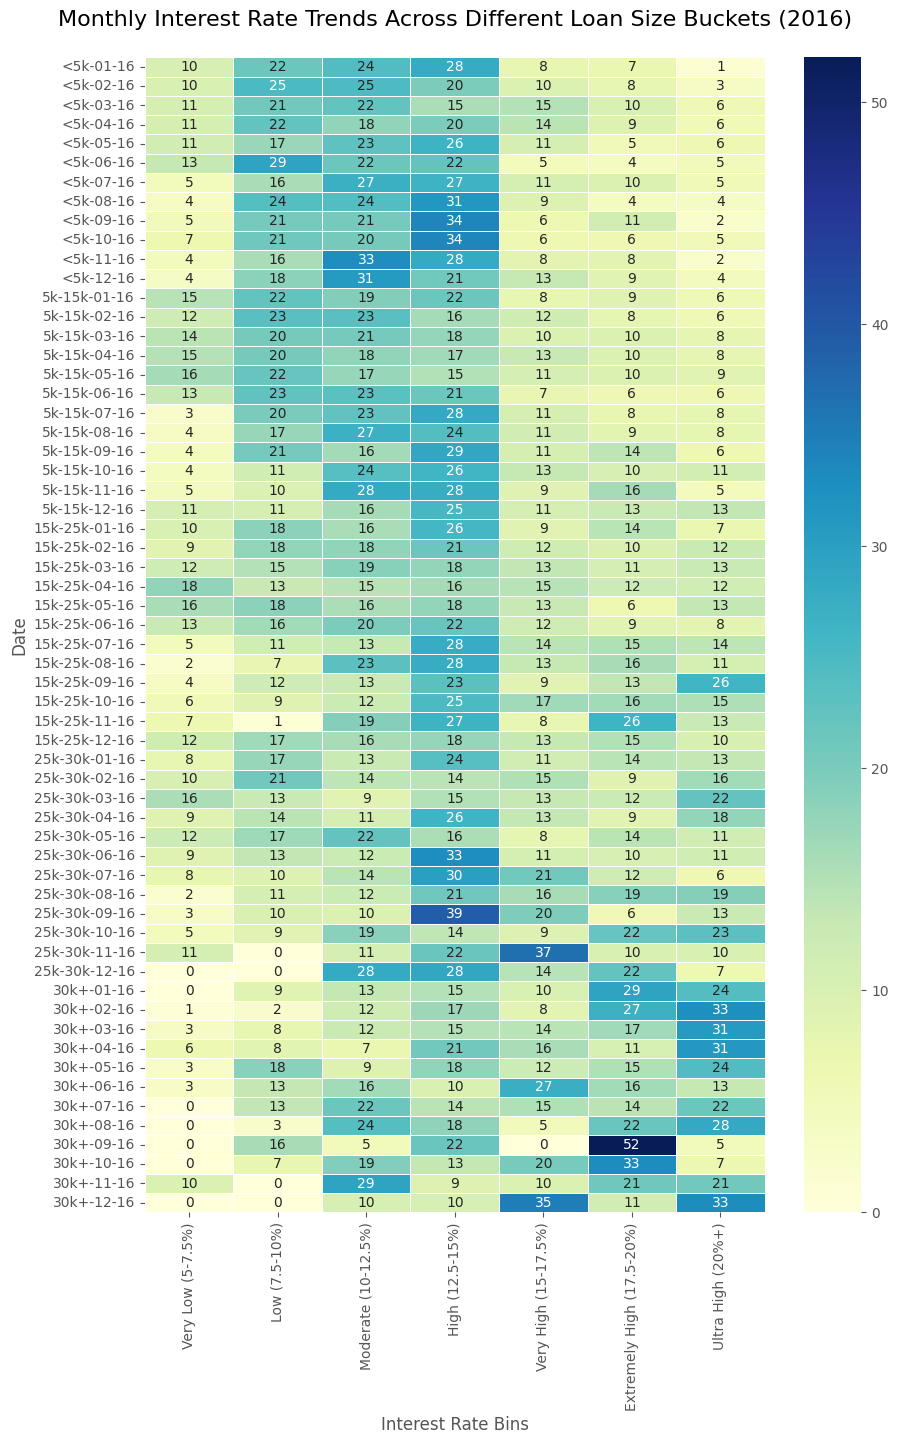

In [ ]:
pivot_data = fe_df[(fe_df['issue_d'].dt.year == 2016)].copy()
# Convert to Category for proper ordering
pivot_data['int_rate_bins'] = pd.Categorical(pivot_data['int_rate_bins'], categories=['Very Low (5-7.5%)', 'Low (7.5-10%)', 'Moderate (10-12.5%)', 'High (12.5-15%)', 'Very High (15-17.5%)', 'Extremely High (17.5-20%)', 'Ultra High (20%+)'], ordered=True)
pivot_data['loan_amnt_bin'] = pd.Categorical(pivot_data['loan_amnt_bin'], categories=['<5k', '5k-15k', '15k-25k', '25k-30k', '30k+'], ordered=True)
# Summary Matrix
pivot_data['issue_d'] = pivot_data['issue_d'].dt.strftime('%m-%y')
pivot_data = pivot_data.groupby(['loan_amnt_bin', 'issue_d', 'int_rate_bins'])['loan_amnt'].sum().unstack().fillna(0)
pivot_data = pivot_data.div(pivot_data.sum(axis=1), axis=0) * 100
# Plot
plt.figure(figsize=(10,15))
sns.heatmap(pivot_data, cmap='YlGnBu', annot=True, fmt=".0f", linewidths=0.5)
plt.title('Monthly Interest Rate Trends Across Different Loan Size Buckets (2016)\n', fontsize=16)
plt.ylabel('Date', fontsize=12)
plt.xlabel('Interest Rate Bins', fontsize=12)
plt.show()

- In the first half of the year, the <15k loan bucket shows a decent contribution from the low-interest-rate segment to overall disbursements. However, in the second half, there is a noticeable shift toward moderate to high-interest-rate segments within the same loan bucket.
    - This trend could reflect adjustments in lending strategies or economic factors influencing customer profiles over the year. For instance, the early-year focus on very low interest rates might align with promotional campaigns or efforts to attract borrowers with stronger credit profiles. The later shift to moderate and high rates could indicate tightening credit policies, higher demand for risk-adjusted loans, or seasonal variations in customer behavior. Understanding the drivers behind this trend could help optimize interest rate strategies and enhance portfolio performance.
- The 25-30k loan bucket does not exhibit any noticeable trends over time regarding interest rates.
- Similarly, the 35k+ loan bucket primarily consists of ultra-high-interest-rate loans. However, a significant portion of loans in this segment are also disbursed at low to moderate interest rates, which could potentially include mortgage loans or other secured lending products, reflecting more favorable terms for lower-risk borrowers.

# Data Modelling

Our focus here will be Data preparation for modeling without any Data leakage

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.base import BaseEstimator, TransformerMixin, ClassifierMixin

In [ ]:
mod_df = df.copy()

In [ ]:
# Remove Unnecessary data
mod_df = mod_df[mod_df['home_ownership'].isin(['MORTGAGE', 'RENT'])]
mod_df = mod_df[mod_df['purpose'].isin(['debt_consolidation', 'credit_card'])]
mod_df = mod_df[mod_df['application_type']=='INDIVIDUAL']
# Adjustments
mod_df['loan_status'] = mod_df['loan_status'].replace({'Fully Paid': 1, 'Charged Off': 0})
mod_df.dropna(subset=['revol_util'], inplace=True)
mod_df.shape

(288322, 27)

In [ ]:
mod_df = mod_df[mod_df['issue_d']<'2016-05-01']
mod_df.shape

(281860, 27)

In [ ]:
mod_df.columns

Index(['loan_amnt', 'term', 'int_rate', 'installment', 'grade', 'sub_grade',
       'emp_title', 'emp_length', 'home_ownership', 'annual_inc',
       'verification_status', 'issue_d', 'loan_status', 'purpose', 'title',
       'dti', 'earliest_cr_line', 'open_acc', 'pub_rec', 'revol_bal',
       'revol_util', 'total_acc', 'initial_list_status', 'application_type',
       'mort_acc', 'pub_rec_bankruptcies', 'address'],
      dtype='object')

In [ ]:
model_X = mod_df.drop('loan_status', axis=1)
model_y = mod_df['loan_status']

In [ ]:
model_y.value_counts(normalize=True)

loan_status
1    0.800763
0    0.199237
Name: proportion, dtype: float64

**The Target class is imbalanced.** <br>
Oversamplying may not be feasible here as the for each combination the number of samples are limited. <br>
Undersamplying is not suitable as we have again combination issue plus data is limited (300K) <br>
Will try to balance the weights during training.

In [ ]:
col_to_stratify = ['term', 'grade', #'sub_grade', #'emp_title', 'emp_length',
                    'home_ownership', 'verification_status', 'purpose', #'title',
                    'initial_list_status']

In [ ]:
model_X['stratify_col'] = model_X[col_to_stratify].astype(str).agg('_'.join, axis=1) + "_" + model_y.astype(str)

In [ ]:
combs_cnt = model_X['stratify_col'].value_counts()
print("Combination only occurs once:", f"{(len(combs_cnt[combs_cnt==1])/len(combs_cnt))*100:.1f}%")
print("Combination only occurs less than 5:", f"{(len(combs_cnt[combs_cnt<5])/len(combs_cnt))*100:.1f}%")

Combination only occurs once: 4.2%
Combination only occurs less than 5: 9.8%


The data lacks sufficient coverage of all possible combinations, limiting its comprehensiveness.
For now as the combination with only 1 sample is 3.5% will combine them as 'Others'


In [ ]:
# Replace rare classes with a placeholder
rare_classes = combs_cnt[combs_cnt == 1].index
model_X['stratify_col'] = model_X['stratify_col'].replace(rare_classes, 'Others')

In [ ]:
# Perform the stratified train-test split
model_X_train, model_X_test, model_y_train, model_y_test = train_test_split(
    model_X.drop(columns=['stratify_col']),
    model_y,
    test_size=0.2,
    random_state=42,
    stratify=model_X['stratify_col']
)

model_X.drop(['stratify_col'], axis=1, inplace=True)
model_X_train.shape, model_X_test.shape, model_y_train.shape, model_y_test.shape

((225488, 26), (56372, 26), (225488,), (56372,))

In [ ]:
# model_X_train, model_X_test, model_y_train, model_y_test = train_test_split(model_X, model_y, test_size=0.2, random_state=42)

## Create Pipeline - Data Modelling
- Impute employee_lenght - map
- Impute mort_acc - map
- Perform lable encoding
- Impute pub_rec_bankruptcies - Random Forest

In [ ]:
class EmployeeLenImputer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        self.map = pd.read_pickle(f"{data_folder}/utils/emp_length_imputation_map.pkl") # will be saved with pipline
        return self

    def transform(self, X):
        print("Imputing Employee Length... before:", X['emp_length'].isna().sum().sum(), end=', ')
        X = X.copy()

        # Create temp column
        X['pincode'] = X['address'].str.extract(r'(\d+)(?=\D*$)').astype('int')

        # Apply imputation to each row using the map
        X['emp_length'] = X.apply(self.impute_emp_length_from_map, axis=1)

        print("after:", X['emp_length'].isna().sum().sum())

        return X

    def impute_emp_length_from_map(self, row):
        if pd.isna(row['emp_length']):
            # Look for rows with the same pincode in the map
            matching_rows = self.map[self.map['pincode'] == row['pincode']]
            if matching_rows.empty:
                return None

            # Calculate a score based on the loan amount proximity and cnt priority
            matching_rows['annual_inc_diff'] = (matching_rows['avg_annual_inc'] - row['annual_inc']).abs()
            matching_rows['score'] = matching_rows['annual_inc_diff'] / matching_rows['cnt']

            # Find the row with the lowest score (since lower score means better match)
            best_match_idx = matching_rows['score'].idxmin()
            best_match = matching_rows.loc[best_match_idx]

            return best_match['emp_length']

        return row['emp_length']

class MortAccImputer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        self.map = pd.read_pickle(f"{data_folder}/utils/mort_acc_imputation_map.pkl") # will be saved with pipline
        return self

    def transform(self, X):
        print("Imputing Morc Acc... before:", X['mort_acc'].isna().sum().sum(), end=', ')
        X = X.copy()

        # Apply imputation to each row using the map
        X['mort_acc'] = X.apply(self.impute_mort_acc_from_map, axis=1)

        print("after:", X['mort_acc'].isna().sum().sum())

        return X

    def impute_mort_acc_from_map(self, row):
        if pd.isna(row['mort_acc']):
            # Find the corresponding row in the map
            matching_row = self.map[
                (self.map['home_ownership'] == row['home_ownership']) &
                (self.map['emp_length'] == row['emp_length']) &
                (self.map['pincode'] == row['pincode'])
            ]
            if not matching_row.empty:
                return round(matching_row['mort_acc'].iloc[0])
            else:
                return round(self.map['mort_acc'].mean())
        return row['mort_acc']

class Preprocessor_1(BaseEstimator, TransformerMixin):
    def __init__(self, map):
        self.map = map

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        print("Transforming using preprocessor_1")
        X = X.copy()
        X.drop(['application_type', 'address', 'pincode'], axis=1, inplace=True)
        print('Unnessary columns dropped')
        X['emp_length'] = X['emp_length'].map(self.map)
        print('emp_length mapped')
        return X

class LabelEncoderTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, columns, unknown_value=-1):
        """
        Initialize the custom label encoder.
        :param columns: List of columns to apply label encoding.
        :param unknown_value: Value to use for unseen labels.
        """
        self.columns = columns
        self.unknown_value = unknown_value
        self.encoders = {}

    def fit(self, X, y=None):
        """
        Fit a label encoder for each specified column.
        """
        print('Fitting Label Encoding')
        for column in self.columns:
            le = LabelEncoder()
            le.fit(X[column].astype(str))
            self.encoders[column] = le
        return self

    def transform(self, X):
        """
        Apply the label encoding to the specified columns.
        """
        print('Transforming using Label Encoding')
        X = X.copy()  # Avoid modifying the original dataframe
        for column, encoder in self.encoders.items():
            if column in X.columns:
                # # X[column] = encoder.transform(X[column].astype(str))
                # Also handle unseen labels
                # Directly get the encoded values for known labels using NumPy
                known_labels = encoder.classes_
                label_map = {label: i for i, label in enumerate(known_labels)}

                # Use np.vectorize to quickly replace labels, assigning the unknown_value for unseen labels
                encoded_column = np.vectorize(lambda x: label_map.get(x, self.unknown_value))(X[column].astype(str))

                X[column] = encoded_column
            else:
                raise ValueError(f"Column {column} not found in input DataFrame.")

        return X

class PubRecBankruptciesImputer(BaseEstimator, TransformerMixin):
    def __init__(self, independent_features, model_params=None, test=False):
        """
        Initialize the transformer with optional model parameters for RandomForestClassifier.
        """
        self.model_params = model_params if model_params else {}
        self.model_rf = RandomForestClassifier(**self.model_params)
        self.independent_features = independent_features
        self.is_fitted = False
        self.test = test

    def fit(self, X, y=None):
        """
        Train the RandomForestClassifier to predict missing values for 'pub_rec_bankruptcies'.
        """
        print('Fitting PubRecBankruptciesImputer')

        if 'pub_rec_bankruptcies' not in X.columns:
            raise ValueError("'pub_rec_bankruptcies' column is required for imputation.")

        # Prepare training data
        train_df = X[self.independent_features + ['pub_rec_bankruptcies']].dropna()
        self.X_train = train_df.drop('pub_rec_bankruptcies', axis=1)
        self.y_train = train_df['pub_rec_bankruptcies']

        # Train Random Forest
        self.model_rf.fit(self.X_train, self.y_train)
        self.is_fitted = True
        return self

    def transform(self, X):
        """
        Impute missing values for 'pub_rec_bankruptcies' using the trained model.
        """
        print('Transforming using PubRecBankruptciesImputer')

        if not self.is_fitted:
            raise ValueError("The transformer has not been fitted yet.")

        X = X.copy()

        # for testing...
        if self.test:
            self.test_model(X)
            return X, self.model_rf

        # Impute/Predict
        missing_idx = X['pub_rec_bankruptcies'].isna()
        if missing_idx.any():
            missing_X = X.loc[missing_idx, self.independent_features]
            imputed_values = self.model_rf.predict(missing_X)
            X.loc[missing_idx, 'pub_rec_bankruptcies'] = imputed_values

        return X

    def test_model(self, X):
        valid_idx = X['pub_rec_bankruptcies'].notnull()                              # Identify rows where target is not null
        X_valid = X.loc[valid_idx, self.independent_features + ['pub_rec_bankruptcies']] # Filter valid rows
        y_true = X_valid['pub_rec_bankruptcies']                                     # Extract actual target values
        X_valid = X_valid.drop('pub_rec_bankruptcies', axis=1)                       # Drop target column for prediction
        y_pred = self.model_rf.predict(X_valid)                                      # Predict using the model
        print(f"Tested on: {len(valid_idx)} rows, Accuracy: {accuracy_score(y_pred, y_true):.4f}")

class RevolUtilImputer(BaseEstimator, TransformerMixin):
    def __init__(self, independent_features, model_params=None, test=False):
        """
        Initialize the transformer with optional model parameters for RandomForestRegressor.
        """
        self.model_params = model_params if model_params else {}
        self.model_rf = RandomForestRegressor(**self.model_params)
        self.independent_features = independent_features
        self.is_fitted = False
        self.test = test

    def fit(self, X, y=None):
        """
        Train the RandomForestRegressor to predict missing values for 'revol_util'.
        """
        print('Fitting RevolUtilImputer')

        if 'revol_util' not in X.columns or 'revol_bal' not in X.columns:
            raise ValueError("'revol_util' and 'revol_bal' columns are required for imputation.")

        # Handle special case where revol_bal == 0
        X = X.copy()
        X.loc[(X['revol_bal'] == 0) & (X['revol_util'].isna()), 'revol_util'] = 0

        # Prepare training data
        train_df = X[self.independent_features+['revol_util']].dropna()
        self.X_train = train_df.drop('revol_util', axis=1)
        self.y_train = train_df['revol_util']

        # Train Random Forest
        self.model_rf.fit(self.X_train, self.y_train)
        self.is_fitted = True
        return self

    def transform(self, X):
        """
        Impute missing values for 'revol_util' using the trained model.
        """
        print('Transforming using RevolUtilImputer')

        if not self.is_fitted:
            raise ValueError("The transformer has not been fitted yet.")

        X = X.copy()

        # Fill revol_util with 0 where revol_bal is 0
        X.loc[(X['revol_bal'] == 0) & (X['revol_util'].isna()), 'revol_util'] = 0

        # for testing...
        if self.test:
            self.test_model(X)
            return X, self.model_rf

        # Impute/Predict
        missing_idx = X['revol_util'].isna()
        if missing_idx.any():
            missing_X = X.loc[missing_idx, self.independent_features]
            imputed_values = self.model_rf.predict(missing_X)
            X.loc[missing_idx, 'revol_util'] = imputed_values

        return X

    def test_model(self, X):
        valid_idx = X['revol_util'].notnull()  # Identify rows where target is not null
        X_valid = X[self.independent_features+['revol_util']].loc[valid_idx, :]         # Filter valid rows
        y_true = X_valid['revol_util']         # Extract actual target values
        X_valid = X_valid.drop('revol_util', axis=1)  # Drop target column for prediction
        y_pred = self.model_rf.predict(X_valid) # Predict using the model
        print(f"Tested on: {len(valid_idx)} rows, R2: {r2_score(y_pred, y_true):.4f}")

class OneHotEncoderDF(BaseEstimator, TransformerMixin):
    def __init__(self, transformer, columns_to_onehot):
        self.transformer = transformer
        self.feature_names = None
        self.columns_to_onehot = columns_to_onehot
        self.original_dtypes = None

    def fit(self, X, y=None):
        print('Fitting OneHotEncoder')
        self.original_dtypes = X.dtypes.to_dict()
        self.transformer.fit(X, y)
        self.feature_names = self.transformer.get_feature_names_out(X.columns) # Save original feature names
        return self

    def transform(self, X):
        print('Transforming using OneHotEncoder')
        X = X.copy()

        transformed_array = self.transformer.transform(X) # Apply the transformation
        cleaned_feature_names = [col.split('__')[-1] for col in self.feature_names] # Get cleaned feature names (remove the 'onehot__' prefix)
        transformed_df = pd.DataFrame(transformed_array, columns=cleaned_feature_names) # convert to DF

        # Revert to original dtype
        for column, dtype in self.original_dtypes.items():
            if column in transformed_df.columns:
                transformed_df[column] = transformed_df[column].astype(dtype) #, errors='ignore')

        # Convert OHE columns to int dtype
        ohecols = transformed_df.columns
        ohecols = ohecols[ohecols.str.contains(r"_\d+$")]
        transformed_df[ohecols] = transformed_df[ohecols].astype(int)

        transformed_df.index = X.index  # Keep the original index intact

        return transformed_df

columns_to_encode = ['term', 'grade', 'sub_grade', 'emp_title', 'home_ownership', 'verification_status', 'purpose', 'title', 'initial_list_status']
columns_to_onehot = ['home_ownership', 'verification_status', 'purpose', 'initial_list_status']

prb_ind_fet = ['pub_rec', 'revol_bal']
revol_util_ind_fet = ['loan_amnt', 'int_rate', 'installment', 'annual_inc', 'dti', 'open_acc',
       'pub_rec', 'revol_bal', 'total_acc', 'mort_acc', 'pub_rec_bankruptcies']

prb_rf_params = {
    'max_depth': 8,
    'min_samples_split': 20,
    'min_samples_leaf': 10,
    'max_features': 0.5,
    'n_estimators': 50,
    'random_state': 42
}
revol_util_rf_params = {
    'n_estimators': 100,
    'random_state': 42
}
emp_len_map = {'< 1 year': 0, '1 year': 1, '2 years': 2, '3 years': 3, '4 years': 4, '5 years': 5, '6 years': 6, '7 years': 7, '8 years': 8, '9 years': 9, '10+ years': 10}

data_preprocessing_pipeline = Pipeline(steps=[
    ('emp_len_imputer', EmployeeLenImputer()),
    ('mort_acc_imputer', MortAccImputer()),
    ('preprocessor_1', Preprocessor_1(map=emp_len_map)),
    ('label_encoder', LabelEncoderTransformer(columns=columns_to_encode, unknown_value=-1)),
    ('onehot_encoder', OneHotEncoderDF(
        transformer=ColumnTransformer(
            transformers=[('onehot', OneHotEncoder(handle_unknown='ignore', drop='first', sparse_output=False), columns_to_onehot)],
            remainder='passthrough'
        ),
        columns_to_onehot=columns_to_onehot)),
    ('pub_rec_bankruptcies_imputer_RF', PubRecBankruptciesImputer(independent_features=prb_ind_fet, model_params=prb_rf_params, test=False)),
    # ('revol_util_imputer_RF', RevolUtilImputer(independent_features=revol_util_ind_fet, model_params=revol_util_rf_params, test=False))
])

# model_X_train_out, model_rf = data_preprocessing_pipeline.fit_transform(model_X_train, model_y_train) #when testing
model_X_train_out = data_preprocessing_pipeline.fit_transform(model_X_train, model_y_train)

Imputing Employee Length... before: 9068, after: 0
Imputing Morc Acc... before: 17215, after: 0
Transforming using preprocessor_1
Unnessary columns dropped
emp_length mapped
Fitting Label Encoding
Transforming using Label Encoding
Fitting OneHotEncoder
Transforming using OneHotEncoder
Fitting PubRecBankruptciesImputer
Transforming using PubRecBankruptciesImputer


In [ ]:
model_X_test_out = data_preprocessing_pipeline.transform(model_X_test)

Imputing Employee Length... before: 2209, after: 0
Imputing Morc Acc... before: 4460, after: 0
Transforming using preprocessor_1
Unnessary columns dropped
emp_length mapped
Transforming using Label Encoding
Transforming using OneHotEncoder
Transforming using PubRecBankruptciesImputer


In [ ]:
# Test pub_rec_bankruptcies on test set
# valid_idx = model_X_test['pub_rec_bankruptcies'].notnull()
# model_rf.score(model_X_test.loc[valid_idx, model_rf.feature_names_in_], model_X_test.loc[valid_idx, 'pub_rec_bankruptcies'])

0.9659863945578231

In [ ]:
# Test revol_util on test set
# valid_idx = model_X_test['revol_util'].notnull()
# r2_score(model_X_test.loc[valid_idx, model_rf.feature_names_in_], model_X_test.loc[valid_idx, 'revol_util'])

In [ ]:
# Saving `data_preprocessing_pipeline` pipeline
with open(f"{data_folder}/utils/data_preprocessing_pipeline.pkl", 'wb') as f:
    pickle.dump(data_preprocessing_pipeline, f)

In [ ]:
# Load the pipeline from the pickle file
with open(f"{data_folder}/utils/data_preprocessing_pipeline.pkl", 'rb') as f:
    data_preprocessing_pipeline = pickle.load(f)

In [ ]:
# Saving model_X_train, model_X_test
model_X_train.to_pickle(f"{data_folder}/utils/model_X_train_DP.pkl")
model_X_test.to_pickle(f"{data_folder}/utils/model_X_test_DP.pkl")

In [ ]:
# # Load model_X_train, model_X_test
# model_X_train = pd.read_pickle(f"{data_folder}/utils/model_X_train_DP.pkl")
# model_X_test = pd.read_pickle(f"{data_folder}/utils/model_X_test_DP.pkl")

In [ ]:
model_X_train_out.head()

home_ownership_1  verification_status_1  verification_status_2  \
202399                 0                      0                      0   
233787                 1                      0                      1   
96337                  0                      0                      1   
307299                 0                      1                      0   
276334                 0                      0                      1   

        purpose_1  initial_list_status_1  loan_amnt  term  int_rate  \
202399          1                      0     4000.0     0     11.49   
233787          1                      0    23250.0     1     21.99   
96337           0                      0    18000.0     0     13.33   
307299          1                      1    27000.0     1     12.69   
276334          0                      1    20000.0     1     15.10   

        installment  grade  sub_grade  emp_title  emp_length  annual_inc  \
202399       131.89      1          8      86177          10     49349.0   
233787       642.01      4         24      51153           2     65000.0   
96337        609.36      2         12      16547          10     63000.0   
307299       610.06      2         11      16452          10     64000.0   
276334       476.85      2         11      97912          10    105000.0   

          issue_d  title    dti earliest_cr_line  open_acc  pub_rec  \
202399 2011-06-01   7320  18.19       1998-12-01       8.0      1.0   
233787 2015-01-01   8193  20.42       1995-01-01      19.0      2.0   
96337  2015-09-01   6161  24.50       2004-09-01      13.0      0.0   
307299 2015-02-01   8193  15.90       2003-05-01       7.0      0.0   
276334 2013-10-01   6161  20.48       1990-07-01      11.0      0.0   

        revol_bal  revol_util  total_acc  mort_acc  pub_rec_bankruptcies  
202399     3517.0        39.5       30.0       3.0                   1.0  
233787    10363.0        21.5       28.0       1.0                   0.0  
96337     10101.0        33.4       21.0       3.0                   0.0  
307299    34182.0        93.4       13.0       1.0                   0.0  
276334    27958.0        86.3       43.0       5.0                   0.0

# Prediction
- High False Positive means losing on potential clients
- High False Negative means higher risk of defaulting
- Focus should be on balancing both of this metric, will use F1 score

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score

In [ ]:
# Load the pipeline from the pickle file
with open(f"{data_folder}/utils/data_preprocessing_pipeline.pkl", 'rb') as f:
    data_preprocessing_pipeline = pickle.load(f)

In [ ]:
# Load model_X_train, model_X_test
model_X_train = pd.read_pickle(f"{data_folder}/utils/model_X_train_DP.pkl")
model_X_test = pd.read_pickle(f"{data_folder}/utils/model_X_test_DP.pkl")

In [ ]:
# model_X_train_out, model_X_test_out
model_X_train_out = data_preprocessing_pipeline.transform(model_X_train)
model_X_test_out = data_preprocessing_pipeline.transform(model_X_test)

In [ ]:
X_train, y_train, X_test, y_test = model_X_train_out.copy(), model_y_train.copy(), model_X_test_out.copy(), model_y_test.copy()
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((225488, 25), (225488,), (56372, 25), (56372,))

In [ ]:
def plot_roc_curve(model, X_test, y_test, aoc_roc_graph=False):
    # Predict probabilities
    y_pred_proba = model.predict_proba(X_test)[:, 1]

    # Compute ROC curve and AUC
    fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba, pos_label=1)
    roc_auc = auc(fpr, tpr)

    # Plot the ROC curve
    if aoc_roc_graph:
        plt.figure(figsize=(5, 4))
        plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC Curve (AUC = {roc_auc:.2f})')
        plt.plot([0, 1], [0, 1], color='grey', lw=1, linestyle='--')
        plt.xlabel('False Positive Rate (FPR)')
        plt.ylabel('True Positive Rate (TPR)')
        plt.title('Receiver Operating Characteristic (ROC) Curve')
        plt.legend(loc='lower right')
        plt.grid(alpha=0.3)
        plt.show()

    # Find the best threshold based on Youden's J statistic
    J = tpr - fpr
    best_index = np.argmax(J)
    best_threshold = thresholds[best_index]

    print(f"Best Threshold: {best_threshold}")

    # Make predictions using the best threshold
    y_pred_adjusted = (y_pred_proba >= best_threshold).astype(int)

    # Evaluate performance with the adjusted threshold
    print("Classification Report with Best Threshold:")
    print(classification_report(y_test, y_pred_adjusted))

def train_model (model, X_train, y_train, X_test, y_test, evaluation=True, aoc_roc_graph=True):
    # Fit the model to the training data
    model.fit(X_train, y_train)

    # Predict on the test set
    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:, 1]  # Probabilities for the positive class

    try:
        # Evaluate the model
        if evaluation:
            accuracy_train = accuracy_score(y_train, y_pred_train)
            accuracy_test = accuracy_score(y_test, y_pred_test)
            roc_auc = roc_auc_score(y_test, y_prob)
            print(f"Accuracy Train: {accuracy_train:.2f}")
            print(f"Accuracy Test: {accuracy_test:.2f}")
            print(f"ROC-AUC on Test: {roc_auc:.2f}")
            plot_roc_curve(model, X_test, y_test, aoc_roc_graph)
            # print("\nClassification Report on Test:")
            # print(classification_report(y_test, y_pred_test))
    except Exception as e:
        print(f"Error during evaluation: {e}")

    return model

In [ ]:
# Base Model
log_reg = LogisticRegression(random_state=42)

log_reg = train_model (log_reg,
             X_train=X_train.select_dtypes(exclude=['datetime']),
             y_train=y_train,
             X_test=X_test.select_dtypes(exclude=['datetime']),
             y_test=y_test,
             aoc_roc_graph=False)

Accuracy Train: 0.80
Accuracy Test: 0.80
ROC-AUC on Test: 0.63
Best Threshold: 0.7607676378693274
Classification Report with Best Threshold:
              precision    recall  f1-score   support

           0       0.28      0.52      0.36     11298
           1       0.85      0.67      0.75     46367

    accuracy                           0.64     57665
   macro avg       0.56      0.59      0.55     57665
weighted avg       0.74      0.64      0.67     57665



- No overfitting (Accuracy approx same on train and test)
- Decent Accuracy (80%)
- Terrible recall and precision for class 0 (less f1 score) as the target variable is imbalance
- Not great ROC-AUC curve

In [ ]:
y_train.value_counts(normalize=True)

loan_status
1    0.804086
0    0.195914
Name: proportion, dtype: float64

In [ ]:
# Logreg Model w/ class imbalance treatment
log_reg = LogisticRegression(random_state=42, class_weight='balanced')

log_reg = train_model (log_reg,
             X_train=X_train.select_dtypes(exclude=['datetime']),
             y_train=y_train,
             X_test=X_test.select_dtypes(exclude=['datetime']),
             y_test=y_test,
             aoc_roc_graph=False)

Accuracy Train: 0.56
Accuracy Test: 0.53
ROC-AUC on Test: 0.67
Best Threshold: 0.43728680857145114
Classification Report with Best Threshold:
              precision    recall  f1-score   support

           0       0.30      0.59      0.40     11229
           1       0.87      0.66      0.75     45143

    accuracy                           0.65     56372
   macro avg       0.58      0.63      0.57     56372
weighted avg       0.75      0.65      0.68     56372



Best Threshold is reduce to 0.46 from 0.8 with class_weight balancing, and accuracy reduced significantly

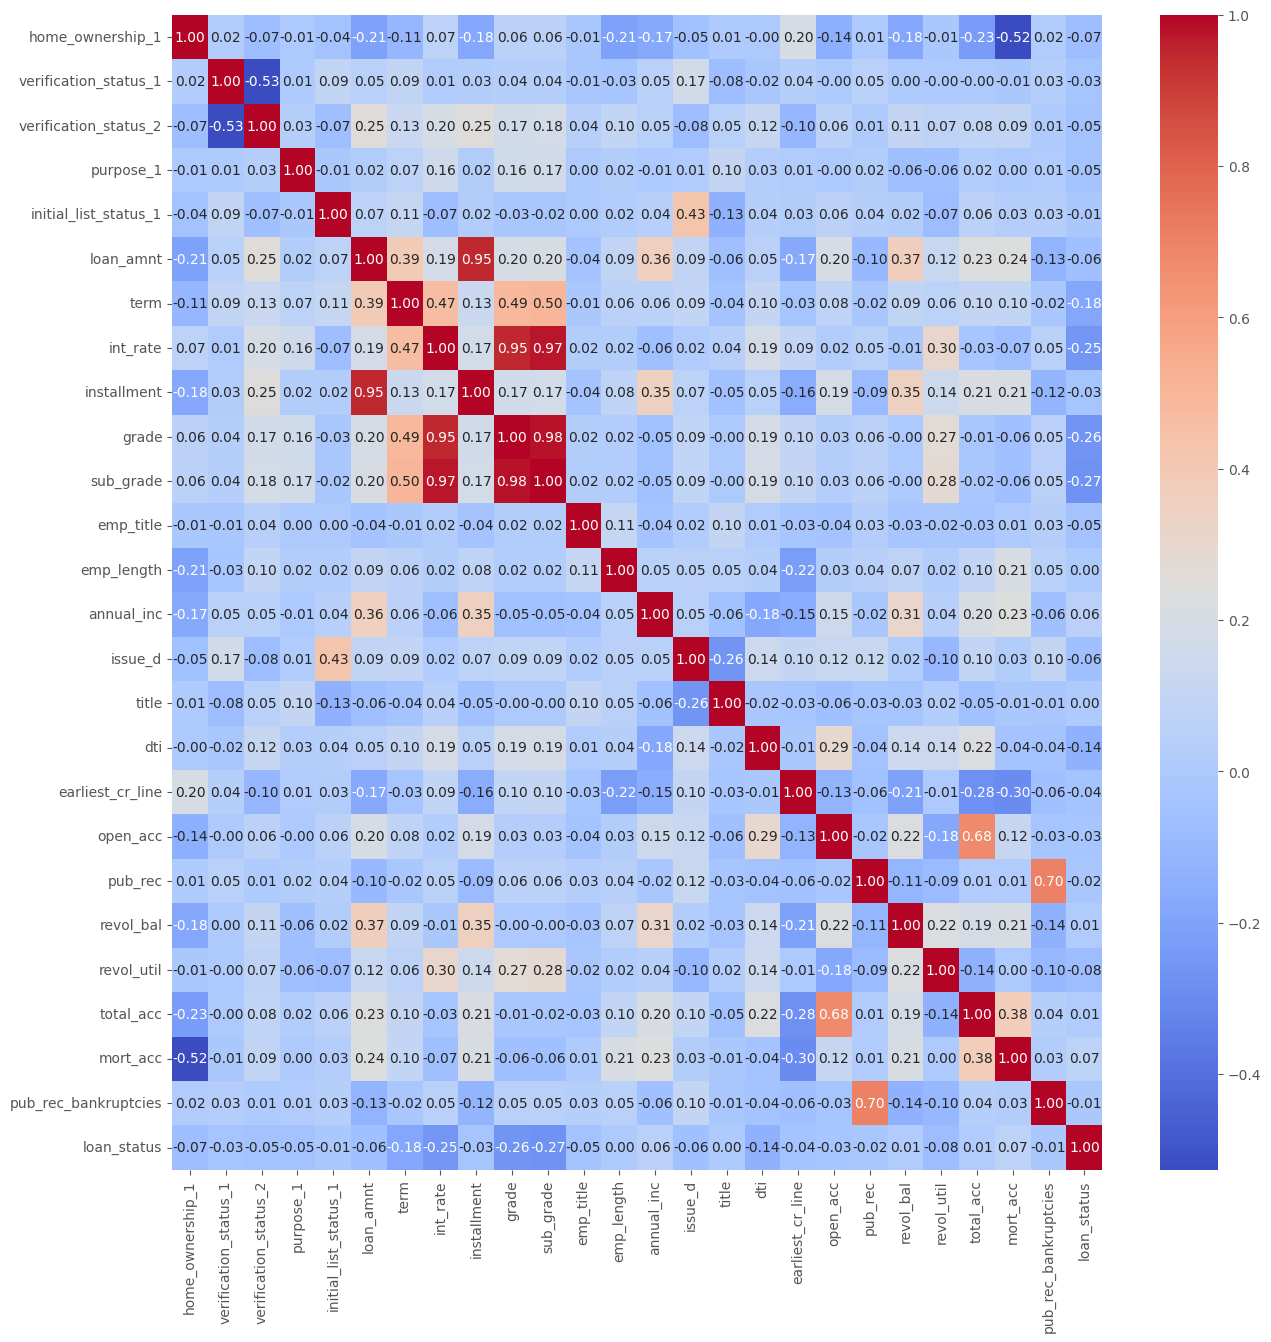

In [ ]:
corr = pd.merge(X_train, y_train, left_index=True, right_index=True).corr()
plt.figure(figsize=(15,15))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt='.2f');

**Fetures with high correlation:**
1. grade:sub_grade:int_rate::0.96
2. loan_amnt:installment::0.95
3. pub_rec:pub_rec_bankruptcies::0.70
4. open_acc:total_acc::0.68

**Treatment:**
1. `sub_grade` might be derived directly from `grade` and may offer redundant information. Retaining `int_rate` I am preferring, as it represents an actual numeric value and provides direct financial insights.
2. `installment` is derived from `int_rate`, hence will keepo `loan_amnt`
3. `pub_rec_bankruptcies` is a subset of `pub_rec`. Therefore, they are related but not identical. A correlation of 0.70 indicates a meaningful overlap but also suggests some independeness. As our target to predict defualt risk `pub_rec_bankruptcies` might provide more specific insights as bankruptcies can have a stronger impact on risk.
4. keeping both for now as correlation is lesser than 0.7

In [ ]:
main_features = X_train.select_dtypes(exclude=['datetime']).drop(['sub_grade', 'grade', 'installment', 'pub_rec'], axis=1).columns
main_features

Index(['home_ownership_1', 'verification_status_1', 'verification_status_2',
       'purpose_1', 'initial_list_status_1', 'loan_amnt', 'term', 'int_rate',
       'emp_title', 'emp_length', 'annual_inc', 'title', 'dti', 'open_acc',
       'revol_bal', 'revol_util', 'total_acc', 'mort_acc',
       'pub_rec_bankruptcies'],
      dtype='object')

In [ ]:
# Logreg Model w/ class imbalance treatment w/o multicollinearity
log_reg = LogisticRegression(random_state=42, class_weight='balanced')

log_reg = train_model (log_reg,
             X_train=X_train[main_features],
             y_train=y_train,
             X_test=X_test[main_features],
             y_test=y_test,
             aoc_roc_graph=False)

Accuracy Train: 0.57
Accuracy Test: 0.54
ROC-AUC on Test: 0.66
Best Threshold: 0.4534172192238892
Classification Report with Best Threshold:
              precision    recall  f1-score   support

           0       0.29      0.59      0.39     11229
           1       0.86      0.64      0.74     45143

    accuracy                           0.63     56372
   macro avg       0.58      0.61      0.56     56372
weighted avg       0.75      0.63      0.67     56372



Approx same performance as before tho with less features hence will remove those permenantly

In [ ]:
# Fit the Random Forest model with class balancing
rf_classifier = RandomForestClassifier(
    class_weight='balanced',
    n_estimators=100,
    max_depth=10,
    random_state=42
)

rf_classifier = train_model (rf_classifier,
                    X_train=X_train[main_features],
                    y_train=y_train,
                    X_test=X_test[main_features],
                    y_test=y_test,
                    aoc_roc_graph=False)

Accuracy Train: 0.69
Accuracy Test: 0.69
ROC-AUC on Test: 0.72
Best Threshold: 0.5374000984009222
Classification Report with Best Threshold:
              precision    recall  f1-score   support

           0       0.32      0.69      0.44     11229
           1       0.89      0.63      0.74     45143

    accuracy                           0.64     56372
   macro avg       0.60      0.66      0.59     56372
weighted avg       0.78      0.64      0.68     56372



Better f1 on class 0 (and class 1 as well)

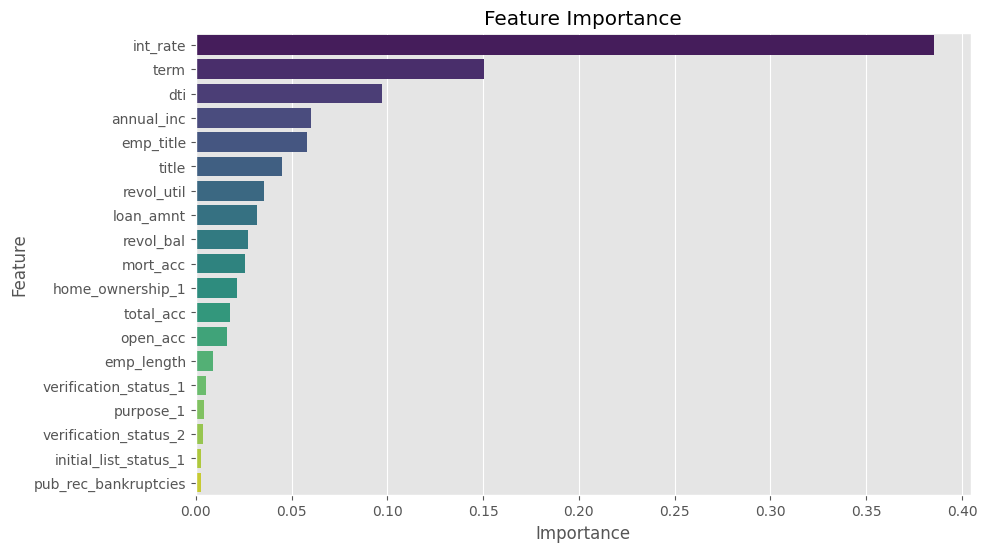

In [ ]:
# Feature Importance
feature_importance_df = pd.DataFrame({
    'Feature': main_features,
    'Importance': rf_classifier.feature_importances_
})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df, palette='viridis')
plt.title('Feature Importance')
plt.show()

The market period might affect the risk, let's create some features

## Feature Engineering - Modelling

In [ ]:
def create_features(data):
    '''
        This will create relevant features
    '''
    # Date features
    temp = data.copy()
    temp['month'] = temp['issue_d'].dt.month
    temp['quarter'] = temp['issue_d'].dt.quarter
    temp['year'] = temp['issue_d'].dt.year
    # temp['day'] = temp['issue_d'].dt.day
    # temp['dayofyear'] = temp['issue_d'].dt.dayofyear
    # temp['weekofyear'] = temp['issue_d'].dt.isocalendar().week.astype('int')
    # temp['dayofweek'] = temp['issue_d'].dt.dayofweek
    temp['is_1st_half'] = (temp['issue_d'].dt.day <= 15)*1
    temp['is_1st_half_week'] = (temp['issue_d'].dt.dayofweek <= 2)*1

    # Additional features
    temp['cx_credit_maturity'] = (((temp['issue_d'] - temp['earliest_cr_line']).dt.days) / 30).astype('int')

    return temp

In [ ]:
# Creating Feature
X_train = create_features(X_train)
X_test = create_features(X_test)

In [ ]:
main_fe = main_features.to_list()+['month', 'quarter', 'year', 'is_1st_half', 'is_1st_half_week', 'cx_credit_maturity']

In [ ]:
# Fit the Random Forest model with class balancing
rf_classifier = RandomForestClassifier(
    class_weight='balanced',
    n_estimators=100,
    max_depth=10,
    random_state=42
)

rf_classifier = train_model (rf_classifier,
                    X_train=X_train[main_fe],
                    y_train=y_train,
                    X_test=X_test[main_fe],
                    y_test=y_test,
                    aoc_roc_graph=False)

Accuracy Train: 0.70
Accuracy Test: 0.69
ROC-AUC on Test: 0.72
Best Threshold: 0.5274280939121353
Classification Report with Best Threshold:
              precision    recall  f1-score   support

           0       0.33      0.68      0.44     11229
           1       0.89      0.66      0.76     45143

    accuracy                           0.66     56372
   macro avg       0.61      0.67      0.60     56372
weighted avg       0.78      0.66      0.69     56372



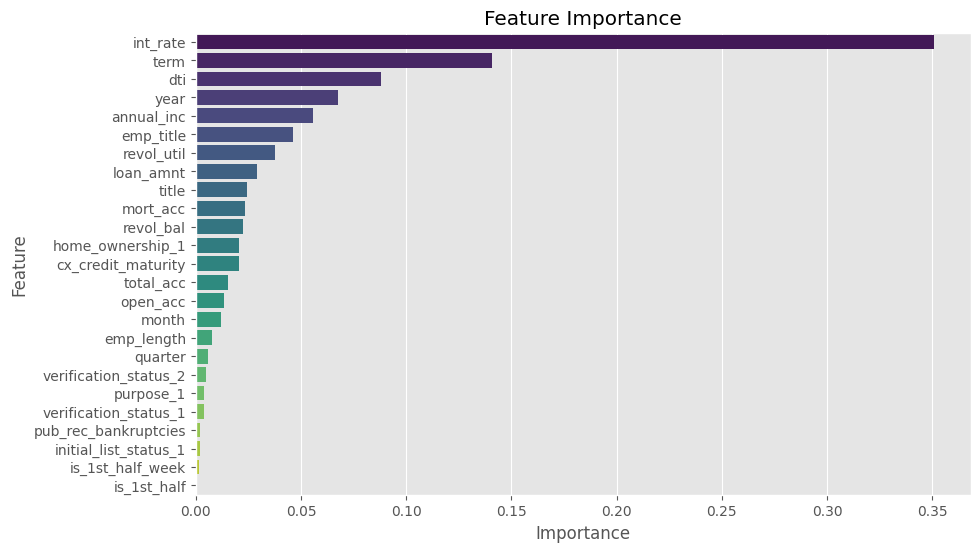

In [ ]:
# Feature Importance
feature_importance_df = pd.DataFrame({
    'Feature': main_fe,
    'Importance': rf_classifier.feature_importances_
})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df, palette='viridis')
plt.title('Feature Importance')
plt.show()

In [ ]:
imp_features = ['int_rate', 'term', 'dti', 'year', 'annual_inc', 'revol_util', 'loan_amnt']

In [ ]:
# Fit the Random Forest model with class balancing and only on imp_features
rf_classifier = RandomForestClassifier(
    class_weight='balanced',
    n_estimators=100,
    max_depth=10,
    random_state=42
)

rf_classifier = train_model (rf_classifier,
                    X_train=X_train[imp_features],
                    y_train=y_train,
                    X_test=X_test[imp_features],
                    y_test=y_test,
                    aoc_roc_graph=False)

Accuracy Train: 0.68
Accuracy Test: 0.67
ROC-AUC on Test: 0.72
Best Threshold: 0.49644525977483533
Classification Report with Best Threshold:
              precision    recall  f1-score   support

           0       0.33      0.64      0.44     11229
           1       0.88      0.68      0.77     45143

    accuracy                           0.67     56372
   macro avg       0.61      0.66      0.61     56372
weighted avg       0.77      0.67      0.70     56372



## RFE and Hyperparameter tuning

In [ ]:
from sklearn.feature_selection import RFE
from sklearn.model_selection import GridSearchCV, StratifiedKFold

In [ ]:
# RFE and Grid Search on Logistic Regression

log_reg = LogisticRegression(random_state=42, class_weight='balanced')

# Create RFE with Logistic Regression
selector = RFE(log_reg)

# Set up the parameter grid for GridSearchCV
param_grid = {
    'estimator__C': [0.1, 1, 10],
    'estimator__solver': ['liblinear', 'lbfgs']
}

# Create a custom scorer for F1 score with class 0
f1_scorer_class_0 = make_scorer(f1_score, pos_label=0)

# Set up GridSearchCV with the RFE selector
grid_search = GridSearchCV(selector, param_grid, cv=5, scoring=f1_scorer_class_0, verbose=10)
grid_search.fit(X_train[main_fe], y_train)

print(f"Best hyperparameters: {grid_search.best_params_}")
print(f"Best score: {grid_search.best_score_}")

Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5; 1/6] START estimator__C=0.1, estimator__solver=liblinear...............
[CV 1/5; 1/6] END estimator__C=0.1, estimator__solver=liblinear;, score=0.422 total time= 1.6min
[CV 2/5; 1/6] START estimator__C=0.1, estimator__solver=liblinear...............
[CV 2/5; 1/6] END estimator__C=0.1, estimator__solver=liblinear;, score=0.414 total time= 1.6min
[CV 3/5; 1/6] START estimator__C=0.1, estimator__solver=liblinear...............
[CV 3/5; 1/6] END estimator__C=0.1, estimator__solver=liblinear;, score=0.419 total time= 1.6min
[CV 4/5; 1/6] START estimator__C=0.1, estimator__solver=liblinear...............
[CV 4/5; 1/6] END estimator__C=0.1, estimator__solver=liblinear;, score=0.420 total time= 1.6min
[CV 5/5; 1/6] START estimator__C=0.1, estimator__solver=liblinear...............
[CV 5/5; 1/6] END estimator__C=0.1, estimator__solver=liblinear;, score=0.419 total time= 1.6min
[CV 1/5; 2/6] START estimator__C=0.1, estimator__s

In [ ]:
# Best features on logistic regression
X_train.columns[grid_search.best_estimator_.support_]

Index(['home_ownership_1', 'verification_status_1', 'verification_status_2',
       'purpose_1', 'initial_list_status_1', 'term', 'int_rate', 'emp_length',
       'earliest_cr_line', 'open_acc', 'pub_rec', 'revol_bal', 'month',
       'quarter', 'is_1st_half_week'],
      dtype='object')

Best f1 score Logistic Regression achieved is 42%, which is very low

## Synthetic data generation for imbalance data - SMOTE

In [ ]:
!pip install imbalanced-learn
from imblearn.over_sampling import SMOTE
from collections import Counter

In [ ]:
# SMOTE for Oversampling
smote = SMOTE(random_state=42)

# Fit and resample the training data
X_train_resampled, y_train_resampled = smote.fit_resample(X_train[main_fe], y_train)

# Check the class distribution after SMOTE
print(f"Class distribution before SMOTE: {Counter(y_train)}")
print(f"Class distribution after SMOTE: {Counter(y_train_resampled)}")

Class distribution before SMOTE: Counter({1: 185468, 0: 45189})
Class distribution after SMOTE: Counter({1: 185468, 0: 185468})


In [ ]:
# Logreg Model after oversampling
log_reg = LogisticRegression(random_state=42)

log_reg = train_model (log_reg,
             X_train=X_train_resampled,
             y_train=y_train_resampled,
             X_test=X_test[X_train_resampled.columns],
             y_test=y_test,
             aoc_roc_graph=False)

Accuracy Train: 0.60
Accuracy Test: 0.62
ROC-AUC on Test: 0.64
Best Threshold: 0.5205122329155923
Classification Report with Best Threshold:
              precision    recall  f1-score   support

           0       0.26      0.63      0.37     11298
           1       0.86      0.57      0.68     46367

    accuracy                           0.58     57665
   macro avg       0.56      0.60      0.53     57665
weighted avg       0.75      0.58      0.62     57665



In [ ]:
# RandomForest Model after oversampling
rf_classifier = RandomForestClassifier(
    n_estimators=100,
    max_depth=10,
    random_state=42
)

rf_classifier = train_model (rf_classifier,
                    X_train=X_train_resampled,
                    y_train=y_train_resampled,
                    X_test=X_test[X_train_resampled.columns],
                    y_test=y_test,
                    aoc_roc_graph=False)

Accuracy Train: 0.79
Accuracy Test: 0.72
ROC-AUC on Test: 0.67
Best Threshold: 0.6266870176839492
Classification Report with Best Threshold:
              precision    recall  f1-score   support

           0       0.29      0.67      0.40     11298
           1       0.88      0.59      0.71     46367

    accuracy                           0.61     57665
   macro avg       0.58      0.63      0.56     57665
weighted avg       0.76      0.61      0.65     57665



In [ ]:
# XGBoost
xgb_model = XGBClassifier(
    objective='binary:logistic',
    eval_metric='logloss',
    use_label_encoder=False,
    random_state=42
)
xgb_model = train_model (xgb_model,
                    X_train=X_train_resampled.values,
                    y_train=y_train_resampled.values,
                    X_test=X_test[X_train_resampled.columns].values,
                    y_test=y_test.values,
                    aoc_roc_graph=False)

Accuracy Train: 0.88
Accuracy Test: 0.80
ROC-AUC on Test: 0.72

Classification Report on Test:
              precision    recall  f1-score   support

           0       0.48      0.17      0.25     11298
           1       0.83      0.95      0.89     46367

    accuracy                           0.80     57665
   macro avg       0.65      0.56      0.57     57665
weighted avg       0.76      0.80      0.76     57665



Best Model

In [ ]:
# XGBoost GridSearch

param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}

# Define a custom scorer for F1 score on class 0
f1_scorer_class_0 = make_scorer(f1_score, pos_label=0)

# Set up manual cross-validation
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Store best score and params
best_score = -np.inf
best_params = {}

# Perform manual cross-validation
for n_estimators in tqdm(param_grid['n_estimators'], total=len(param_grid['n_estimators'])):
    for max_depth in tqdm(param_grid['max_depth'], total=len(param_grid['max_depth'])):
        for learning_rate in tqdm(param_grid['learning_rate'], total=len(param_grid['learning_rate'])):
            for subsample in tqdm(param_grid['subsample'], total=len(param_grid['subsample'])):
                for colsample_bytree in tqdm(param_grid['colsample_bytree'], total=len(param_grid['colsample_bytree'])):
                    # Set model with current hyperparameters
                    model = XGBClassifier(
                        n_estimators=n_estimators,
                        max_depth=max_depth,
                        learning_rate=learning_rate,
                        subsample=subsample,
                        colsample_bytree=colsample_bytree,
                        objective='binary:logistic',
                        eval_metric='logloss',
                        use_label_encoder=False,
                        random_state=42
                    )

                    fold_scores = []
                    k_splits = kf.split(X_train_resampled, y_train_resampled)
                    for train_index, val_index in tqdm(k_splits, total=5):
                        X_train_fold, X_val_fold = X_train_resampled.iloc[train_index], X_train_resampled.iloc[val_index]
                        y_train_fold, y_val_fold = y_train_resampled.iloc[train_index], y_train_resampled.iloc[val_index]

                        # Fit model and predict
                        model.fit(X_train_fold.values, y_train_fold.values)
                        y_pred = model.predict(X_val_fold.values)

                        # Calculate F1 score for class 0
                        f1 = f1_score(y_val_fold, y_pred, pos_label=0)
                        fold_scores.append(f1)

                    # Calculate mean F1 score across folds
                    mean_f1_score = np.mean(fold_scores)
                    # print("score:", mean_f1_score, end='\r')

                    # Update best score and parameters
                    if mean_f1_score > best_score:
                        best_score = mean_f1_score
                        best_params = {
                            'n_estimators': n_estimators,
                            'max_depth': max_depth,
                            'learning_rate': learning_rate,
                            'subsample': subsample,
                            'colsample_bytree': colsample_bytree
                        }

# Output best parameters and best F1 score
print(f"Best hyperparameters: {best_params}")
print(f"Best F1 score for class 0: {best_score}")

# # Set up GridSearchCV
# grid_search = GridSearchCV(
#     estimator=xgb_model,
#     param_grid=param_grid,
#     scoring=f1_scorer_class_0,
#     cv=5,
#     verbose=10
# )

# # Perform the grid search
# grid_search.fit(X_train_resampled.values, y_train_resampled.values)

# # Output the best parameters and best score
# print(f"Best hyperparameters: {grid_search.best_params_}")
# print(f"Best F1 score for class 0: {grid_search.best_score_}")

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Best hyperparameters: {'n_estimators': 200, 'max_depth': 7, 'learning_rate': 0.2, 'subsample': 1.0, 'colsample_bytree': 1.0}
Best F1 score for class 0: 0.8630726399723689


- Best hyperparameters: `{'n_estimators': 200, 'max_depth': 7, 'learning_rate': 0.2, 'subsample': 1.0, 'colsample_bytree': 1.0}`
- Best F1 score for class 0: 0.8630726399723689

In [ ]:
# XGBoost w/ best_params and oversampling
best_params =  {'n_estimators': 200, 'max_depth': 7, 'learning_rate': 0.2, 'subsample': 1.0, 'colsample_bytree': 1.0}
xgb_model = XGBClassifier(
    objective='binary:logistic',
    eval_metric='logloss',
    use_label_encoder=False,
    random_state=42,
    **best_params
)
xgb_model = train_model (xgb_model,
                    X_train=X_train_resampled.values,
                    y_train=y_train_resampled.values,
                    X_test=X_test[X_train_resampled.columns].values,
                    y_test=y_test.values,
                    aoc_roc_graph=False)

Accuracy Train: 0.90
Accuracy Test: 0.80
ROC-AUC on Test: 0.72
Best Threshold: 0.8073005080223083
Classification Report with Best Threshold:
              precision    recall  f1-score   support

           0       0.31      0.70      0.43     11298
           1       0.90      0.62      0.73     46367

    accuracy                           0.64     57665
   macro avg       0.60      0.66      0.58     57665
weighted avg       0.78      0.64      0.68     57665



The model seem to be overfitted

## Data Normalizing

In [ ]:
X_train[main_fe].columns

Index(['home_ownership_1', 'verification_status_1', 'verification_status_2',
       'purpose_1', 'initial_list_status_1', 'loan_amnt', 'term', 'int_rate',
       'emp_title', 'emp_length', 'annual_inc', 'title', 'dti', 'open_acc',
       'revol_bal', 'revol_util', 'total_acc', 'mort_acc',
       'pub_rec_bankruptcies', 'month', 'quarter', 'year', 'is_1st_half',
       'is_1st_half_week', 'cx_credit_maturity'],
      dtype='object')

In [ ]:
# Normalize the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train[main_fe])
X_test_scaled = scaler.transform(X_test[main_fe])

In [ ]:
# XGBoost w/ best_params and oversampling
best_params =  {'n_estimators': 200, 'max_depth': 7, 'learning_rate': 0.2, 'subsample': 1.0, 'colsample_bytree': 1.0}
xgb_model = XGBClassifier(
    objective='binary:logistic',
    eval_metric='logloss',
    use_label_encoder=False,
    random_state=42,
    **best_params
)
xgb_model = train_model (xgb_model,
                    X_train=X_train_scaled,
                    y_train=y_train.values,
                    X_test=X_test_scaled,
                    y_test=y_test.values,
                    aoc_roc_graph=False)

Accuracy Train: 0.84
Accuracy Test: 0.80
ROC-AUC on Test: 0.72
Best Threshold: 0.798735499382019
Classification Report with Best Threshold:
              precision    recall  f1-score   support

           0       0.32      0.67      0.43     11298
           1       0.89      0.66      0.76     46367

    accuracy                           0.66     57665
   macro avg       0.61      0.66      0.60     57665
weighted avg       0.78      0.66      0.69     57665



In [ ]:
imp_features

['int_rate', 'term', 'dti', 'year', 'annual_inc', 'revol_util', 'loan_amnt']

In [ ]:
# Features to scale
features_to_scale = ['int_rate', 'annual_inc', 'loan_amnt']

# Define the ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('scaler', StandardScaler(), features_to_scale),
    ],
    remainder='passthrough'
)

# Create a pipeline that includes scaling and model training
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor)
])

# Apply the transformation to the training and test data
X_train_scaled = pipeline.fit_transform(X_train[imp_features])
X_test_scaled = pipeline.transform(X_test[imp_features])

In [ ]:
f1_class_0_scorer = make_scorer(f1_score, pos_label=0)

# Logistic Regression
log_reg_best_params = {'C': 1, 'solver': 'lbfgs'}
log_reg = LogisticRegression(class_weight='balanced', random_state=42, **log_reg_best_params)

# Random Forest
rf_classifier = RandomForestClassifier(
    class_weight='balanced',
    n_estimators=100,
    max_depth=10,
    random_state=42
)

# XGBoost
class SklearnXGBClassifier(XGBClassifier, BaseEstimator, ClassifierMixin):
    pass
best_params = {'n_estimators': 200, 'max_depth': 7, 'learning_rate': 0.2, 'subsample': 1.0, 'colsample_bytree': 1.0}
xgb_model = SklearnXGBClassifier(
    objective='binary:logistic',
    eval_metric='logloss',
    use_label_encoder=False,
    random_state=42,
    **best_params
)

## StackingClassifier

# Train base models
log_reg.fit(X_train_scaled, y_train); print('log_reg trained!')
rf_classifier.fit(X_train_scaled, y_train); print('rf_classifier trained!')
# xgb_model.fit(X_train_scaled, y_train); print('xgb_model trained!')

# Generate predictions for meta model
log_reg_preds = log_reg.predict_proba(X_test_scaled)[:, 1]
rf_preds = rf_classifier.predict_proba(X_test_scaled)[:, 1]
# xgb_preds = xgb_model.predict_proba(X_test_scaled)[:, 1]

# Stack predictions
meta_features = np.column_stack((log_reg_preds, rf_preds))

# Train meta model
meta_model = LogisticRegression(class_weight='balanced', random_state=42)
meta_model.fit(meta_features, y_test)

# Evaluate
final_preds = meta_model.predict(meta_features)
print("Classification Report:")
print(classification_report(y_test, final_preds))

log_reg trained!
rf_classifier trained!
Classification Report:
              precision    recall  f1-score   support

           0       0.33      0.66      0.44     11229
           1       0.89      0.66      0.76     45143

    accuracy                           0.66     56372
   macro avg       0.61      0.66      0.60     56372
weighted avg       0.78      0.66      0.69     56372



## Neural Network

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers.schedules import ExponentialDecay

In [ ]:
def f1_class_0(y_true, y_pred):
    y_pred = K.cast(y_pred > 0.5, dtype='int32')
    # True Positives (TP) for class 0
    tp = K.sum(K.cast((y_true == 0) & (y_pred == 0), dtype='float32'))
    # False Positives (FP) for class 0
    fp = K.sum(K.cast((y_true != 0) & (y_pred == 0), dtype='float32'))
    # False Negatives (FN) for class 0
    fn = K.sum(K.cast((y_true == 0) & (y_pred != 0), dtype='float32'))
    # Precision and Recall for class 0
    precision = tp / (tp + fp + K.epsilon())
    recall = tp / (tp + fn + K.epsilon())
    # F1 score for class 0
    f1 = 2 * (precision * recall) / (precision + recall + K.epsilon())
    return f1

def nn_eval(model, X_test, y_test):
    y_pred_proba = model.predict(X_test)

    # Find the best threshold based on Youden's J statistic
    fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba, pos_label=1)
    J = tpr - fpr
    best_index = np.argmax(J)
    best_threshold = thresholds[best_index]
    print("Best Threshold:", best_threshold)

    # Evaluate the model on the test set
    y_pred = (y_pred_proba > best_threshold).astype(int)

    # Classification report
    print("Classification Report:", classification_report(y_test, y_pred))

In [ ]:
# Define the neural network
model = Sequential([
    Dense(128, activation='relu', input_shape=(X_train_scaled.shape[1],)),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(1, activation='sigmoid')
])

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='binary_crossentropy',
              metrics=[f1_class_0])

# Train the model
nn_model = model.fit(
    X_train_scaled, y_train,
    validation_split=0.2,
    epochs=20,
    batch_size=32,
    verbose=1
)

nn_eval(model, X_test_scaled, y_test)

Epoch 1/20
5767/5767 ━━━━━━━━━━━━━━━━━━━━ 29s 4ms/step - f1_class_0: 0.0846 - loss: 0.4634 - val_f1_class_0: 0.0726 - val_loss: 0.4474
Epoch 2/20
5767/5767 ━━━━━━━━━━━━━━━━━━━━ 14s 2ms/step - f1_class_0: 0.1011 - loss: 0.4515 - val_f1_class_0: 0.0833 - val_loss: 0.4470
Epoch 3/20
5767/5767 ━━━━━━━━━━━━━━━━━━━━ 14s 2ms/step - f1_class_0: 0.1117 - loss: 0.4454 - val_f1_class_0: 0.1008 - val_loss: 0.4424
Epoch 4/20
5767/5767 ━━━━━━━━━━━━━━━━━━━━ 14s 2ms/step - f1_class_0: 0.1282 - loss: 0.4453 - val_f1_class_0: 0.1106 - val_loss: 0.4431
Epoch 5/20
5767/5767 ━━━━━━━━━━━━━━━━━━━━ 20s 2ms/step - f1_class_0: 0.1252 - loss: 0.4436 - val_f1_class_0: 0.0950 - val_loss: 0.4410
Epoch 6/20
5767/5767 ━━━━━━━━━━━━━━━━━━━━ 21s 2ms/step - f1_class_0: 0.1441 - loss: 0.4426 - val_f1_class_0: 0.1364 - val_loss: 0.4408
Epoch 7/20
5767/5767 ━━━━━━━━━━━━━━━━━━━━ 14s 2ms/step - f1_class_0: 0.1317 - loss: 0.4425 - val_f1_class_0: 0.2241 - val_loss: 0.4422
Epoch 8/20
5767/5767 ━━━━━━━━━━━━━━━━━━━━ 21s 3ms/step 

In [ ]:
# Continue Training...
nn_model = model.fit(
    X_train_scaled, y_train,
    validation_split=0.2,
    epochs=20, # Additional epochs
    batch_size=32,
    verbose=1
)

Epoch 1/20
5767/5767 ━━━━━━━━━━━━━━━━━━━━ 20s 3ms/step - f1_class_0: 0.1662 - loss: 0.4404 - val_f1_class_0: 0.0896 - val_loss: 0.4404
Epoch 2/20
5767/5767 ━━━━━━━━━━━━━━━━━━━━ 19s 3ms/step - f1_class_0: 0.1632 - loss: 0.4401 - val_f1_class_0: 0.1317 - val_loss: 0.4394
Epoch 3/20
5767/5767 ━━━━━━━━━━━━━━━━━━━━ 14s 2ms/step - f1_class_0: 0.1666 - loss: 0.4388 - val_f1_class_0: 0.1034 - val_loss: 0.4395
Epoch 4/20
5767/5767 ━━━━━━━━━━━━━━━━━━━━ 20s 2ms/step - f1_class_0: 0.1715 - loss: 0.4387 - val_f1_class_0: 0.1166 - val_loss: 0.4406
Epoch 5/20
5767/5767 ━━━━━━━━━━━━━━━━━━━━ 13s 2ms/step - f1_class_0: 0.1643 - loss: 0.4386 - val_f1_class_0: 0.1130 - val_loss: 0.4395
Epoch 6/20
5767/5767 ━━━━━━━━━━━━━━━━━━━━ 21s 2ms/step - f1_class_0: 0.1769 - loss: 0.4381 - val_f1_class_0: 0.1370 - val_loss: 0.4402
Epoch 7/20
5767/5767 ━━━━━━━━━━━━━━━━━━━━ 21s 2ms/step - f1_class_0: 0.1762 - loss: 0.4358 - val_f1_class_0: 0.1500 - val_loss: 0.4402
Epoch 8/20
5767/5767 ━━━━━━━━━━━━━━━━━━━━ 19s 2ms/step 

In [ ]:
nn_eval(model, X_test_scaled, y_test)

1803/1803 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step
Best Threshold: 0.80163336
Classification Report:               precision    recall  f1-score   support

           0       0.33      0.68      0.44     11298
           1       0.89      0.66      0.76     46367

    accuracy                           0.66     57665
   macro avg       0.61      0.67      0.60     57665
weighted avg       0.78      0.66      0.70     57665



Model seems little slow

In [ ]:
# Define the neural network
model = Sequential([
    Dense(256, activation='relu', input_shape=(X_train_scaled[imp_features].shape[1],)),
    # Dropout(0.3),
    Dense(128, activation='relu'),
    # Dropout(0.3),
    Dense(64, activation='relu'),
    # Dropout(0.3),
    Dense(32, activation='relu'),
    # Dropout(0.3),
    Dense(1, activation='sigmoid')
])

# Compile with the learning rate
model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='binary_crossentropy',
    metrics=['accuracy', f1_class_0]
)

# Train the model
nn_model = model.fit(
    X_train_scaled, y_train,
    validation_split=0.2,
    epochs=50,
    batch_size=32,
    verbose=1
)

nn_eval(model, X_test_scaled, y_test)

IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

## Prediction Pipeline

In [ ]:
# Load model_X_train, model_X_test
model_X_train = pd.read_pickle(f"{data_folder}/utils/model_X_train_DP.pkl")
model_X_test = pd.read_pickle(f"{data_folder}/utils/model_X_test_DP.pkl")

In [ ]:
pred_X_train, pred_y_train, pred_X_test, pred_y_test = model_X_train.copy(), model_y_train.copy(), model_X_test.copy(), model_y_test.copy()
pred_X_train.shape, pred_y_train.shape, pred_X_test.shape, pred_y_test.shape

((225488, 26), (225488,), (56372, 26), (56372,))

In [ ]:
class feature_engineering(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass
    def fit(self, X, y=None):
        return self
    def transform(self, X, y=None):
        print("Transforming using feature_engineering")
        X = X.copy()
        X['year'] = X['issue_d'].dt.year
        X['cx_credit_maturity'] = (((X['issue_d'] - X['earliest_cr_line']).dt.days) / 30).astype('int')
        return X

class Preprocessor_2(BaseEstimator, TransformerMixin):
    def __init__(self, imp_features):
        self.imp_features = imp_features
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        print("Transforming using preprocessor_2")
        return X[self.imp_features]

# Logistic Regression model
log_reg_best_params = {'C': 1, 'solver': 'lbfgs'}
log_reg = LogisticRegression(class_weight='balanced', random_state=42, **log_reg_best_params)

# Random Forest model
rf_classifier = RandomForestClassifier(
    class_weight='balanced',
    n_estimators=100,
    max_depth=10,
    random_state=42
)

# Preprocessing step: Scaling selected features
scaler = ColumnTransformer(
    transformers=[
        ('scaler', StandardScaler(), ['int_rate', 'annual_inc', 'loan_amnt'])
    ],
    remainder='passthrough'
)

# Stacking Classifier
stacking_classifier = StackingClassifier(
    estimators=[
        ('log_reg', log_reg),
        ('rf', rf_classifier)
    ],
    final_estimator=LogisticRegression(class_weight='balanced', random_state=42)
)

# Important features for the Preprocessor_2
imp_features = ['int_rate', 'term', 'dti', 'year', 'cx_credit_maturity', 'annual_inc', 'revol_util', 'loan_amnt']

# Combine data_preprocessing_pipeline and next prediciton steps
prediction_pipeline = Pipeline(steps=[
    ('data_preprocessing', data_preprocessing_pipeline),
    ('feature_engineering', feature_engineering()),
    ('preprocessor_2', Preprocessor_2(imp_features=imp_features)),
    ('scaler', scaler),
    ('stacking_classifier', stacking_classifier)
])

# Fit the pipeline on the training data
prediction_pipeline.fit(model_X_train, model_y_train)

Imputing Employee Length... before: 9068, after: 0
Imputing Morc Acc... before: 17215, after: 0
Transforming using preprocessor_1
Unnessary columns dropped
emp_length mapped
Fitting Label Encoding
Transforming using Label Encoding
Fitting OneHotEncoder
Transforming using OneHotEncoder
Fitting PubRecBankruptciesImputer
Transforming using PubRecBankruptciesImputer
Transforming using feature_engineering
Transforming using preprocessor_2


Pipeline(steps=[('data_preprocessing',
                 Pipeline(steps=[('emp_len_imputer', EmployeeLenImputer()),
                                 ('mort_acc_imputer', MortAccImputer()),
                                 ('preprocessor_1',
                                  Preprocessor_1(map={'1 year': 1,
                                                      '10+ years': 10,
                                                      '2 years': 2,
                                                      '3 years': 3,
                                                      '4 years': 4,
                                                      '5 years': 5,
                                                      '6 years': 6,
                                                      '7 years': 7,
                                                      '8 years': 8,
                                                      '9 years': 9,
                                                      '< 1 year': 0})),
                                 ('label_encoder',
                                  LabelEncoderTransformer(columns=['te...
                                   transformers=[('scaler', StandardScaler(),
                                                  ['int_rate', 'annual_inc',
                                                   'loan_amnt'])])),
                ('stacking_classifier',
                 StackingClassifier(estimators=[('log_reg',
                                                 LogisticRegression(C=1,
                                                                    class_weight='balanced',
                                                                    random_state=42)),
                                                ('rf',
                                                 RandomForestClassifier(class_weight='balanced',
                                                                        max_depth=10,
                                                                        random_state=42))],
                                    final_estimator=LogisticRegression(class_weight='balanced',
                                                                       random_state=42)))])

In [ ]:
# Predict on the test data
final_preds = prediction_pipeline.predict(model_X_test)

# Evaluate the model
print("\nClassification Report on Test Set:")
print(classification_report(y_test, final_preds))

Imputing Employee Length... before: 2209, after: 0
Imputing Morc Acc... before: 4460, after: 0
Transforming using preprocessor_1
Unnessary columns dropped
emp_length mapped
Transforming using Label Encoding
Transforming using OneHotEncoder
Transforming using PubRecBankruptciesImputer
Transforming using feature_engineering
Transforming using preprocessor_2

Classification Report on Test Set:
              precision    recall  f1-score   support

           0       0.32      0.67      0.44     11229
           1       0.89      0.65      0.75     45143

    accuracy                           0.66     56372
   macro avg       0.61      0.66      0.59     56372
weighted avg       0.77      0.66      0.69     56372



In [ ]:
# Saving `prediction_pipeline` pipeline
with open(f"{data_folder}/utils/prediction_pipeline.pkl", 'wb') as f:
    pickle.dump(prediction_pipeline, f)

In [ ]:
# # Load the pipeline from the pickle file
# with open(f"{data_folder}/utils/prediction_pipeline.pkl", 'rb') as f:
#     prediction_pipeline = pickle.load(f)

# Conclusion

### Analysis
---
**Customer Credit Health Analysis:**

1. Credit Maturity:  A majority of customers have a credit history between 100-400 months.  A lower proportion of younger customers suggests a bias towards more established borrowers.  Further analysis could explore if this impacts loan default rates.

2. Open Credit Lines:  While the distribution of open credit lines is relatively balanced, a significant portion (51%) of customers possess a high number of open accounts, potentially indicating increased risk. This warrants closer scrutiny regarding default probability.

3. Debt-to-Income Ratio (DTI):  DTI follows a near-normal distribution, but the higher end of the spectrum needs monitoring, as these customers present a greater risk of default.  Further segmentation by DTI risk level could reveal valuable insights.

4. Revolving Line Utilization Rate (Revol_Util): The distribution is nearly normal, with some extreme values possibly due to outlier capping. A peak around 50% suggests moderate credit utilization but those with higher values deserve attention due to higher risk.  Visualization with "eyes" added a playful touch, but its real impact is minimal. The key is the distribution itself.

5. Interest Rate:  The interest rate distribution is slightly left-skewed, implying a higher concentration of lower interest rate loans.  Analysis of interest rates in relation to loan default risk and customer segment is crucial.

**Correlation Analysis:**

- Loan amount and installment amount show strong positive correlation, as expected.
- Annual income is left-skewed, indicating more borrowers in lower income brackets.
- Loan term moderately correlates with loan amount and interest rates, despite the lack of direct correlation between the latter two.  This could indicate different loan product types affecting these variables.

**Time Series Analysis of Loan Characteristics (2016):**

1. Loan Amount Trends:
   - Increased lending to younger customers (credit maturity < 100 months) in the last few months of 2016.
   - High loan disbursement to customers with many open credit lines.
   - Shift in lending to customers with low-moderate DTI risk, with a reduction in high DTI borrowers.  This is potentially a positive risk management shift.
   - Increased loan disbursement to high revol_util customers.  This warrants further monitoring.

2. NPA Loan Trends:
   - A drop in extremely high interest rates and NPAs (1500 basis points drop) between March and July.
   - Significant decrease in "very low" interest rate loan volumes, with a shift towards moderate interest rates.  This suggests a changing lending strategy or market dynamics.

3. Loan Amount and Interest Rate Interaction:
   - Loans below 15k initially saw a larger proportion at lower interest rates, but this shifted to moderate/high rates later in the year.
   - 25k-30k bucket shows no clear trend in interest rate over time.
   - Loans over 35k consist primarily of ultra-high and low-moderate interest rates.

**Business Recommendations:**

1. Deeper Dive into Risk Factors:  Analyze the relationship between customer segments (defined by open accounts, DTI, credit maturity, revol_util) and loan defaults.  Are the increased lending to high-risk groups truly profitable given potential defaults?
2. Monitor Lending Trends:  Continue to track loan disbursal and NPA trends over time.  Changes in lending behavior can be positive but require careful observation. Are the interest rate shifts helping profitability or increasing risk?
3. Model Refinement:  Develop predictive models to assess credit risk based on these characteristics, focusing on those identified as high risk.
4. Segment Analysis: Focus on customer segments with potentially different risk profiles to refine risk assessment and optimize lending strategies for each group.  Understand what drives shifts in these segments and their corresponding interest rates.

### Data Modelling
---


1. Feature Selection and Hyperparameter Tuning:
   - Recursive Feature Elimination (RFE) and GridSearchCV were used with Logistic Regression to find the best features and hyperparameters.
   - The best F1 score achieved was 42% for class 0, indicating poor performance with this model and feature set.

2. Addressing Class Imbalance:
   - SMOTE (Synthetic Minority Over-sampling Technique) was applied to oversample the minority class in the training data to address data imbalance.

3. Model Training and Evaluation (after SMOTE):
   - Logistic Regression, RandomForest, and XGBoost classifiers were trained on the resampled data.
   - Performance metrics were not explicitly stated in the code.

4. XGBoost Hyperparameter Tuning:
   - A manual grid search with stratified K-fold cross-validation was performed to find the optimal hyperparameters for the XGBoost model.
   - The best hyperparameters were found to be: *{'n_estimators': 200, 'max_depth': 7, 'learning_rate': 0.2, 'subsample': 1.0, 'colsample_bytree': 1.0}*
   - The best F1 score achieved was 0.86 for class 0.

5. Data Normalization:
   - StandardScaler was used to normalize features for model improvement.
   - XGBoost was tested again with best hyperparameters found earlier.

6. Feature Scaling and Pipeline:
   - A ColumnTransformer was used for scaling specific features ('int_rate', 'annual_inc', 'loan_amnt')
   - A pipeline was created to incorporate scaling in model training for streamlined workflow.
   - Logistic Regression, RandomForest, and XGBoost models used again

7. Stacking Classifier:
   - Logistic Regression, RandomForest, and potentially XGBoost, were combined using StackingClassifier with Logistic Regression as the final estimator.
   - The predictions of these base models were stacked as meta features for the final model.
   - The meta-model (Logistic Regression) was trained to produce predictions on the stacked features.

8. Neural Network:
   - A neural network using Keras was implemented.
   - The model was trained with epochs and a custom f1_class_0 metric.
   - The model's performance was evaluated and additional epochs were added to potentially improve results.
   - Model architecture with several dense layers and dropout was tested.

9. Prediction Pipeline:
   - A comprehensive prediction pipeline was built combining preprocessing steps including feature engineering, feature scaling and feature selection.
   - The prediction_pipeline was saved with pickle and loaded later for further predictions.

**General Notes:**
  - The code focuses on model selection for imbalanced data.
  - The analysis has some focus on finding the best metrics for evaluation.
  - There are several model versions that are being compared, and XGBoost consistently seems to yield the best results.